In [3]:
# import
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import math
import time

In [4]:
# import
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [5]:
# read file
def read_file(fname):
    data = np.loadtxt(fname)
    s = np.split(data, [data.shape[1] - 1], axis=1)
    return s

In [6]:
# K_Fold
def K_Fold(n, n_folds=10, shuffle=False):
    step = n // n_folds
    remainder = n % n_folds
    
    # generate fold sizes
    fold_sizes = (step) * np.ones(n_folds, dtype=np.int)
    fold_sizes[:remainder] += 1
    
    train_idx = []
    test_idx = []
    
    sequence = np.array(range(n))
    if shuffle:
        np.random.shuffle(sequence)
        
    cursor = 0
    for fs in fold_sizes:
        test_fold = sequence[cursor:cursor + fs]
        test_idx.append(test_fold)
        train_fold = np.delete(sequence, range(cursor, cursor + fs))
        train_idx.append(train_fold)
        cursor += fs
    return train_idx, test_idx

In [7]:
# fit transform
def fit_transform(X, n):
    Z = np.insert(X, 0, 1, axis=1)
    if n > 1:
        for i in range(2, n + 1):
            Z = np.append(Z, X ** i, axis=1)
    return Z

In [8]:
# gram matrix
def gram_matrix(X, sigma):
    G = np.exp((-1) * np.square(cdist(X, X, 'euclidean')) / sigma ** 2)
    return G

In [9]:
# fit
def fit(X, y, sigma=0.0):
    theta = None
    
    # if sigma is given, fit to dual linear regression model
    if sigma > 0.0:
        G = gram_matrix(X, sigma)
        alpha = np.dot(np.linalg.inv(G), y)
        theta = np.dot(X.T, alpha)
    else:
        theta = np.dot(np.linalg.pinv(X), y)
        
    return theta

In [10]:
# newton method
def newton_method(X):
    alpha = np.linalg.inv((np.dot(X.T, X)))
    return alpha

In [11]:
# gradient descent
def gradient_descent(X, y, alpha, epsilon, stochastic=False):
    length = 1
    vX = [X]
    vy = [y]
    
    # if stochastic is True, use stochastic gradient descent
    if stochastic:
        length = len(X)
        vX = [np.expand_dims(v, axis=0) for v in X]
        vy = [np.expand_dims(v, axis=0) for v in y]
    
    # init theta with random number
    theta_1 = 10.0 * np.random.randn(X.shape[1], 1)
    suc_flag = False
    
    while not suc_flag:
        for i in range(length):
            theta_0 = np.copy(theta_1)
            predicted_0 = predict(vX[i], theta_0)
            J_0 = cost(predicted_0, vy[i])

            theta_1 = theta_0 - alpha * np.sum(np.dot(vX[i].T, (predicted_0 - vy[i])))
            predicted_1 = predict(vX[i], theta_1)
            J_1 = cost(predicted_1, vy[i])

            if np.fabs(J_1 - J_0) <= epsilon:
                suc_flag = True
                break
                
    return theta_1

In [12]:
# predict
def predict(X, theta):
    y = np.dot(X, theta)
    return y

In [13]:
# cost
def cost(X, y):
    J = np.sum(np.square(X - y)) / (2.0 * X.shape[0])
    return J

In [14]:
# score
def score(X, y):
    rse = (np.sum(np.square(X - y) / np.square(y))) / (2.0 * X.shape[0])
    return rse

In [15]:
# cross validation
def cross_validation(X, y, fit_model, n, n_folds=10, \
                     sigma=0.0, alpha=0.0, newton=False, epsilon=0.0, \
                     stochastic=False, p_verbose=False, r_verbose=False):
    train_J = []
    test_J = []
    train_rse = []
    test_rse = []
    
    train_idx, test_idx = K_Fold(len(y), n_folds=n_folds, shuffle=True)
    
    for i in range(n_folds):
        Z = fit_transform(X, n)
        
        theta = None
        
        # fit to different models
        if fit_model is 'explicit':
            theta = fit(Z[train_idx[i]], y[train_idx[i]], sigma=sigma)
        elif fit_model is 'iterative':
            alp = newton_method(Z[train_idx[i]]) if newton else alpha
            theta = gradient_descent(Z[train_idx[i]], y[train_idx[i]], \
                                     alpha=alp, epsilon=epsilon, stochastic=stochastic)
        
        # train error
        train_predicted = predict(Z[train_idx[i]], theta)
        tr_J = cost(train_predicted, y[train_idx[i]])
        tr_rse = score(train_predicted, y[train_idx[i]])

        # test error
        test_predicted = predict(Z[test_idx[i]], theta)
        t_J = cost(test_predicted, y[test_idx[i]])
        t_rse = score(test_predicted, y[test_idx[i]])

        train_J.append(tr_J)
        test_J.append(t_J)
        train_rse.append(tr_rse)
        test_rse.append(t_rse)
    
    # average error
    train_J_avg = np.mean(train_J)
    test_J_avg = np.mean(test_J)
    train_rse_avg = np.mean(train_rse)
    test_rse_avg = np.mean(test_rse)
        
    if p_verbose:
        print 'CROSS_VALIDATION (K = %d) (n = %d):' % (n_folds, n)
        for i in range(len(train_J)):
            print 'fold %d:' % i
            print '\ttrain_J=%.7f\t' % train_J[i], 'train_rse=%.7f\t' % train_rse[i]
            print '\ttest_J=%.7f\t' % test_J[i], 'test_rse=%.7f\t' % test_rse[i]
    if r_verbose:
        print 'CROSS_VALIDATION (K = %d) (n = %d):' % (n_folds, n)
        print 'average results (n = %d):' % n
        print '\ttrain_J_avg=%.7f\t' % train_J_avg, 'train_rse_avg=%.7f\t' % train_rse_avg
        print '\ttest_J_avg=%.7f\t' % test_J_avg, 'test_rse_avg=%.7f' % test_rse_avg
        
    return train_J_avg, test_J_avg, train_rse_avg, test_rse_avg

In [16]:
# use sklearn linear regression
def sklearn_cross_validation(X, y, n, n_folds=10, p_verbose=False, r_verbose=False):
    train_J = []
    test_J = []
    train_rse = []
    test_rse = []
    
    cv = KFold(len(y), n_folds)
    
    for train_idx, test_idx in cv:
        poly = PolynomialFeatures(degree=n)
        Z = poly.fit_transform(X)
        
        clf = LinearRegression()
        clf.fit(Z[train_idx], y[train_idx])
        
        # train error
        train_predicted = clf.predict(Z[train_idx])
        tr_J = cost(train_predicted, y[train_idx])
        tr_rse = score(train_predicted, y[train_idx])
        
        # test error
        test_predicted = clf.predict(Z[test_idx])
        t_J = cost(test_predicted, y[test_idx])
        t_rse = score(test_predicted, y[test_idx])
        
        train_J.append(tr_J)
        test_J.append(t_J)
        train_rse.append(tr_rse)
        test_rse.append(t_rse)
        
    train_J_avg = np.mean(train_J)
    test_J_avg = np.mean(test_J)
    train_rse_avg = np.mean(train_rse)
    test_rse_avg = np.mean(test_rse)
        
    if p_verbose:
        print 'SKLEARN_CROSS_VALIDATION (K = %d) (n = %d):' % (n_folds, n)
        for i in range(len(train_J)):
            print 'fold %d:' % i
            print '\ttrain_J=%.7f\t' % train_J[i], 'train_rse=%.7f\t' % train_rse[i]
            print '\ttest_J=%.7f\t' % test_J[i], 'test_rse=%.7f\t' % test_rse[i]

    if r_verbose:
        print 'SKLEARN_CROSS_VALIDATION (K = %d) (n = %d):' % (n_folds, n)
        print 'average results (n = %d):' % n
        print '\ttrain_J_avg=%.7f\t' % train_J_avg, 'train_rse_avg=%.7f\t' % train_rse_avg
        print '\ttest_J_avg=%.7f\t' % test_J_avg, 'test_rse_avg=%.7f' % test_rse_avg
        
    return train_J_avg, test_J_avg, train_rse_avg, test_rse_avg

In [17]:
def run(fname, fit_model, n, n_folds=10, truncate=0.0, \
        sigma=0.0, alpha=0.0, newton=False, epsilon=0.0, \
        stochastic=False, p_verbose=False, r_verbose=False, pl_verbose=False):
    s = read_file(fname)
    X = s[0]
    y = s[1]
    predicted = None
    
    # if truncate is given, truncate to the given percentage
    if truncate > 0.0 and truncate < 1.0:
        remain_amount = int(math.ceil(len(X) * truncate))
        X = X[:remain_amount]
        y = y[:remain_amount]
    
    # timing
    start = time.time()
    if fit_model is 'sklearn':
        # sklearn cross validation
        train_J_avg, test_J_avg, train_rse_avg, test_rse_avg = \
        sklearn_cross_validation(X, y, n, n_folds=n_folds, p_verbose=p_verbose, r_verbose=r_verbose)

        # sklearn apply to all data
        poly = PolynomialFeatures(degree=n)
        Z = poly.fit_transform(X)

        clf = LinearRegression()
        clf.fit(Z, y)
        predicted = clf.predict(Z)
    else:
        # cross validation
        train_J_avg, test_J_avg, train_rse_avg, test_rse_avg = \
        cross_validation(X, y, fit_model=fit_model, n=n, n_folds=n_folds, \
                         sigma=sigma, alpha=alpha, newton=newton, epsilon=epsilon, \
                         stochastic=stochastic, p_verbose=p_verbose, r_verbose=r_verbose)


        # apply to all data
        Z = fit_transform(X, n)

        theta = None
        
        if fit_model is 'explicit':
            theta = fit(Z, y, sigma=sigma)
        elif fit_model is 'iterative':
            alp = newton_method(Z) if newton else alpha
            theta = gradient_descent(Z, y, alpha=alp, epsilon=epsilon, stochastic=stochastic)
        predicted = predict(Z, theta)
    stop = time.time()
    
    J = cost(predicted, y)
    rse = score(predicted, y)
    duration = stop - start

    if r_verbose:
        print 'RUN: %s (n = %d)' % (fname, n)
        print 'applied to all data (n = %d):' % n
        print '\tJ=%.7f\t' % J, 'rse=%.7f' % rse
        print 'running time:', duration

    if pl_verbose:
        plt.plot(X, y, 'wo')
        plt.plot(X, predicted, 'r.')
        plt.title('RUN: %s (n = %d)' % (fname, n))
        plt.xlabel('X')
        plt.ylabel('y')
        plt.show()
        
    return J, rse, duration

In [18]:
def batch_run(fnames, fit_model, n, n_folds=10, truncate=0.0, \
        sigma=0.0, alpha=0.0, newton=False, epsilon=0.0, stochastic=False, \
              p_verbose=False, r_verbose=False, pl_verbose=False, bpl_verbose=False):
    for fname in fnames:
        Js = []
        rses = []
        durations = []

        for i in range(n):
            J, rse, duration = run(fname, fit_model, i + 1, n_folds=n_folds, truncate=truncate, 
                                   sigma=sigma, alpha=alpha, newton=newton, epsilon=epsilon, stochastic=stochastic, \
                                   p_verbose=p_verbose, r_verbose=r_verbose, pl_verbose=pl_verbose)
            Js.append(J)
            rses.append(rse)
            durations.append(duration)

        # get the minimum error
        J_idx = Js.index(min(Js))
        rse_idx = rses.index(min(rses))
        
        if bpl_verbose:
            plt.plot(range(len(Js)), Js, 'bo-')
            plt.title('BATCH_RUN: %s (n = %d)' % (fname, n))
            plt.xlabel('degree')
            plt.ylabel('J')
            plt.show()

            plt.plot(range(len(rses)), rses, 'ro-')
            plt.title('BATCH_RUN: %s (n = %d)' % (fname, n))
            plt.xlabel('degree')
            plt.ylabel('rse')
            plt.show()
            
        print 'BATCH_RUN: %s (n = %d)' % (fname, n)
        print 'J_min = %.7f\t' % Js[J_idx], 'n = %d' % (J_idx + 1)
        print 'rse_min = %.7f\t' % rses[rse_idx], 'n = %d' % (rse_idx + 1)
        print 'running time:', durations, '\n\n'

In [19]:
# get all s_file names
s_fnames = []
for i in range(1, 5):
    s_fnames.append('svar-set' + str(i) + '.dat')
    
print s_fnames

['svar-set1.dat', 'svar-set2.dat', 'svar-set3.dat', 'svar-set4.dat']


In [20]:
# get all m_file names
m_fnames = []
for i in range(1, 5):
    m_fnames.append('mvar-set' + str(i) + '.dat')
    
print m_fnames

['mvar-set1.dat', 'mvar-set2.dat', 'mvar-set3.dat', 'mvar-set4.dat']


# 1. Single variable regression

#### (a) Load each of the single feature data sets and plot the the data to get an idea of the complexity of the problem.

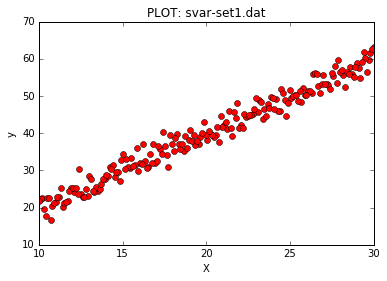

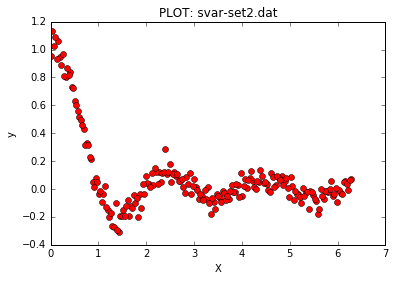

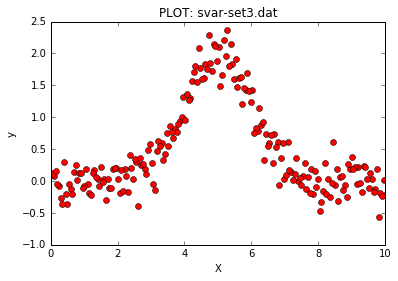

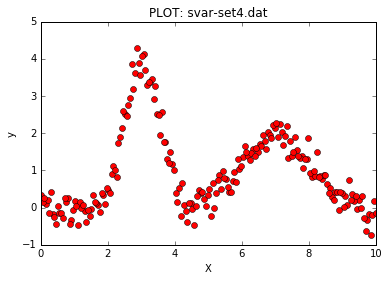

In [19]:
# plot data
def plot_data(fnames):
    for fname in fnames:
        s = read_file(fname)
        X = s[0]
        y = s[1]

        plt.plot(X, y, 'ro')
        plt.title('PLOT: ' + fname)
        plt.xlabel('X')
        plt.ylabel('y')
        plt.show()

plot_data(s_fnames)

#### (b) Fit a linear model to the data, Compute the training and test error, and compare them. Plot the regression model you obtained on top of the test data.

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=2.1140245	train_rse_avg=0.0018399	
	test_J_avg=2.1594711	test_rse_avg=0.0018803
RUN: svar-set1.dat (n = 1)
applied to all data (n = 1):
	J=2.1162853	rse=0.0018416
running time: 0.00249004364014


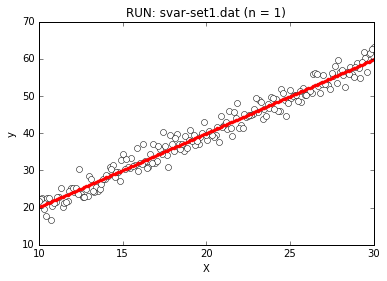

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.0297286	train_rse_avg=50.2327090	
	test_J_avg=0.0308833	test_rse_avg=53.0534250
RUN: svar-set2.dat (n = 1)
applied to all data (n = 1):
	J=0.0297863	rse=50.3872921
running time: 0.00373792648315


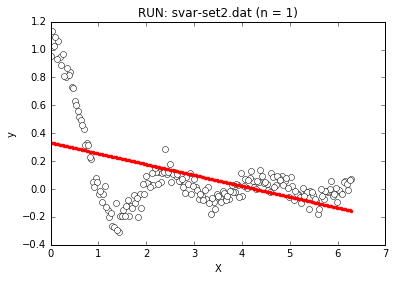

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.2491553	train_rse_avg=48.8988253	
	test_J_avg=0.2532173	test_rse_avg=49.8189369
RUN: svar-set3.dat (n = 1)
applied to all data (n = 1):
	J=0.2493569	rse=48.7861839
running time: 0.00371217727661


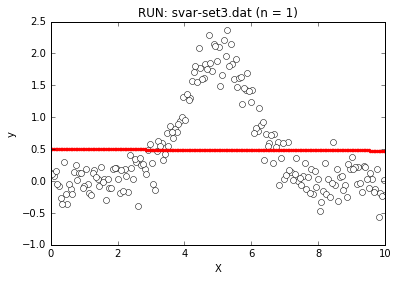

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.5996519	train_rse_avg=850.9687947	
	test_J_avg=0.6146807	test_rse_avg=906.1891410
RUN: svar-set4.dat (n = 1)
applied to all data (n = 1):
	J=0.6004040	rse=855.0362917
running time: 0.00189614295959


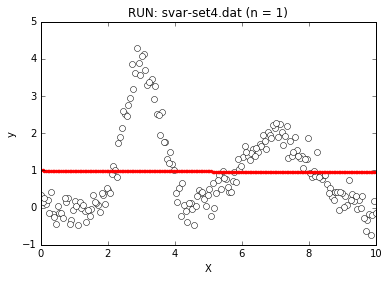

In [125]:
# fit linear regression model with degree 1
for fname in s_fnames:
    run(fname, 'explicit', 1, r_verbose=True, pl_verbose=True)

#### (c) Compare the result you obtain to the one obtained by the ready made Python function.

SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=2.1127463	train_rse_avg=0.0018367	
	test_J_avg=2.1843763	test_rse_avg=0.0019227
RUN: svar-set1.dat (n = 1)
applied to all data (n = 1):
	J=2.1162853	rse=0.0018416
running time: 0.00735592842102


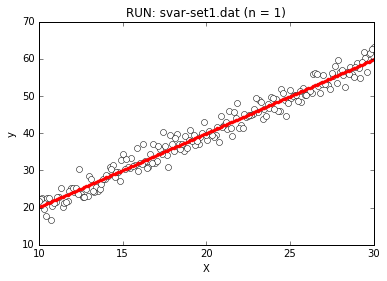

SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.0297436	train_rse_avg=50.1718258	
	test_J_avg=0.0306003	test_rse_avg=53.9032082
RUN: svar-set2.dat (n = 1)
applied to all data (n = 1):
	J=0.0297863	rse=50.3872921
running time: 0.00527286529541


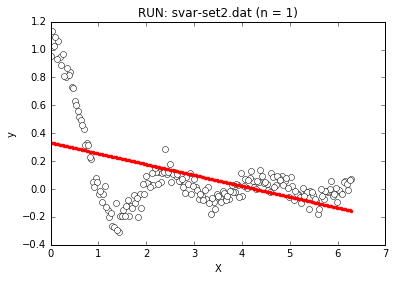

SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.2492086	train_rse_avg=48.7588106	
	test_J_avg=0.2521696	test_rse_avg=50.0269966
RUN: svar-set3.dat (n = 1)
applied to all data (n = 1):
	J=0.2493569	rse=48.7861839
running time: 0.00780987739563


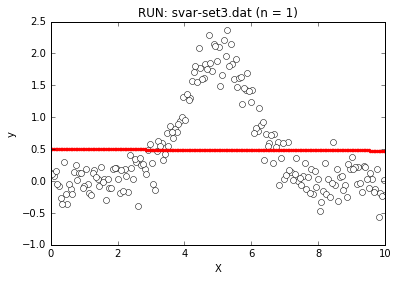

SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.6001013	train_rse_avg=859.7622905	
	test_J_avg=0.6061435	test_rse_avg=822.2437717
RUN: svar-set4.dat (n = 1)
applied to all data (n = 1):
	J=0.6004040	rse=855.0362917
running time: 0.00507688522339


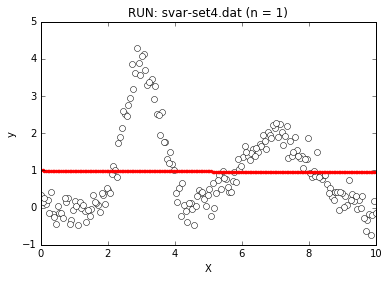

In [126]:
# fit sklearn linear regression model with degree 1
for fname in s_fnames:
    run(fname, 'sklearn', 1, r_verbose=True, pl_verbose=True)

#### (d) Test different polynomial models on different subsets of the data. Choose a single polynomial model and Justify your selection. Repeat the evaluation procedure above.

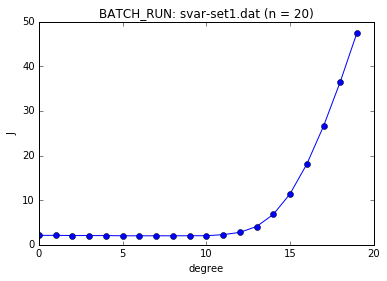

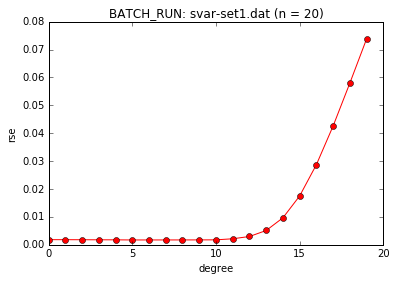

BATCH_RUN: svar-set1.dat (n = 20)
J_min = 2.0134392	n = 7
rse_min = 0.0017359	n = 6
running time: [0.0029969215393066406, 0.002023935317993164, 0.003423929214477539, 0.002376079559326172, 0.002550840377807617, 0.004678964614868164, 0.002897977828979492, 0.0036208629608154297, 0.004950046539306641, 0.004695892333984375, 0.004030942916870117, 0.007739067077636719, 0.0071070194244384766, 0.007951974868774414, 0.006799936294555664, 0.011208057403564453, 0.006560087203979492, 0.00834512710571289, 0.00580596923828125, 0.006697177886962891] 




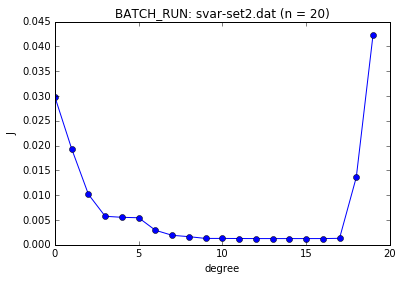

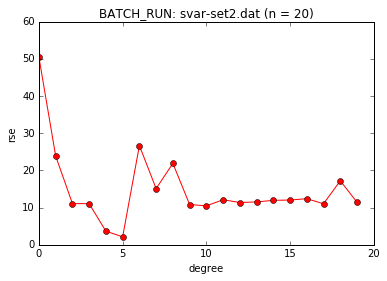

BATCH_RUN: svar-set2.dat (n = 20)
J_min = 0.0012537	n = 14
rse_min = 2.1442261	n = 6
running time: [0.0019099712371826172, 0.0024878978729248047, 0.003072023391723633, 0.0023779869079589844, 0.0025479793548583984, 0.0033349990844726562, 0.0031461715698242188, 0.003206014633178711, 0.0033960342407226562, 0.003770112991333008, 0.003968000411987305, 0.0063779354095458984, 0.006911039352416992, 0.005363941192626953, 0.006742000579833984, 0.007700920104980469, 0.006019115447998047, 0.005970954895019531, 0.005956888198852539, 0.006549835205078125] 




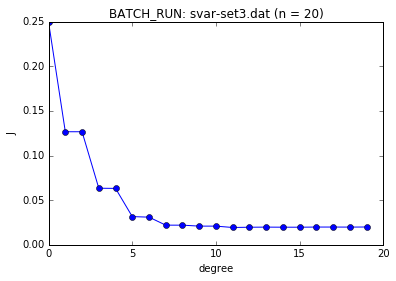

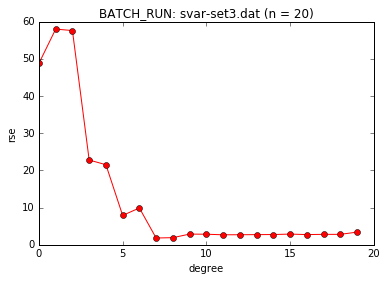

BATCH_RUN: svar-set3.dat (n = 20)
J_min = 0.0193919	n = 12
rse_min = 1.8246026	n = 8
running time: [0.002585172653198242, 0.002379179000854492, 0.002296924591064453, 0.003984928131103516, 0.002619028091430664, 0.003000020980834961, 0.003217935562133789, 0.003342151641845703, 0.003437042236328125, 0.003843069076538086, 0.003996133804321289, 0.004378080368041992, 0.0045201778411865234, 0.004739046096801758, 0.004904031753540039, 0.005339860916137695, 0.00545501708984375, 0.005650997161865234, 0.0058879852294921875, 0.006101846694946289] 




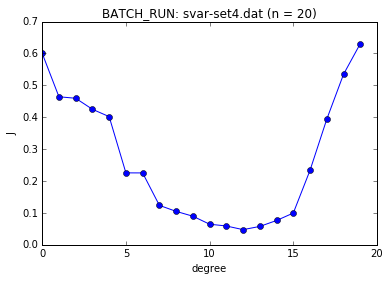

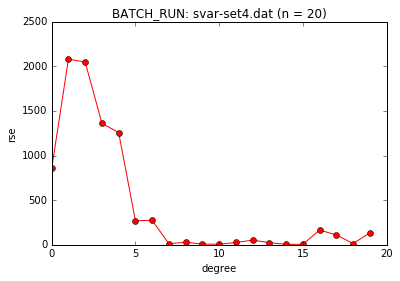

BATCH_RUN: svar-set4.dat (n = 20)
J_min = 0.0475288	n = 13
rse_min = 4.5023798	n = 15
running time: [0.0025529861450195312, 0.0031499862670898438, 0.0030438899993896484, 0.0030210018157958984, 0.0029439926147460938, 0.0027980804443359375, 0.00447392463684082, 0.00803685188293457, 0.0038890838623046875, 0.004229068756103516, 0.004415988922119141, 0.004513978958129883, 0.004498004913330078, 0.005388021469116211, 0.0049381256103515625, 0.005486011505126953, 0.00542902946472168, 0.0057010650634765625, 0.006855964660644531, 0.006133079528808594] 




In [127]:
# run all datasets, fit linear regression model with degree from 1 to 20
batch_run(s_fnames, 'explicit', 20, bpl_verbose=True)

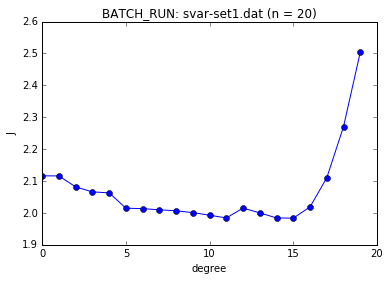

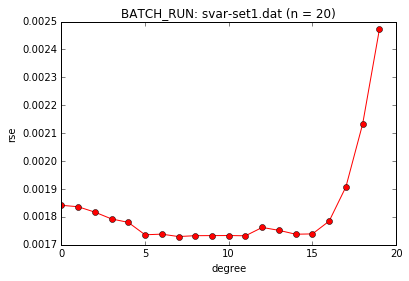

BATCH_RUN: svar-set1.dat (n = 20)
J_min = 1.9835461	n = 16
rse_min = 0.0017296	n = 8
running time: [0.005960941314697266, 0.005326986312866211, 0.005287885665893555, 0.0056171417236328125, 0.0055828094482421875, 0.005791902542114258, 0.00636601448059082, 0.008751869201660156, 0.00986790657043457, 0.010252952575683594, 0.009720087051391602, 0.01470494270324707, 0.010264873504638672, 0.007918834686279297, 0.009721040725708008, 0.008153915405273438, 0.008855819702148438, 0.009115934371948242, 0.008864879608154297, 0.009166955947875977] 




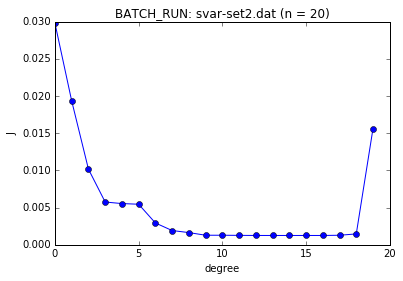

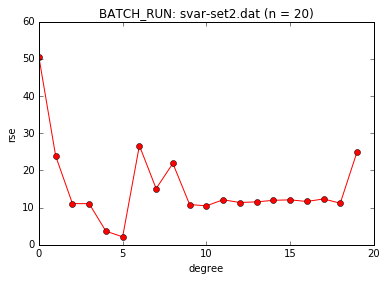

BATCH_RUN: svar-set2.dat (n = 20)
J_min = 0.0012535	n = 17
rse_min = 2.1442261	n = 6
running time: [0.005151033401489258, 0.0053517818450927734, 0.005312204360961914, 0.005430936813354492, 0.0063381195068359375, 0.00818014144897461, 0.007604122161865234, 0.009926080703735352, 0.008486032485961914, 0.009489059448242188, 0.00781702995300293, 0.00821685791015625, 0.007559061050415039, 0.008220911026000977, 0.007973909378051758, 0.008296966552734375, 0.008574962615966797, 0.008767843246459961, 0.008971929550170898, 0.009354829788208008] 




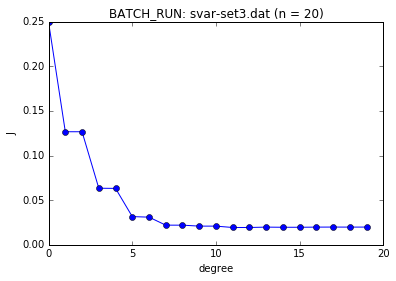

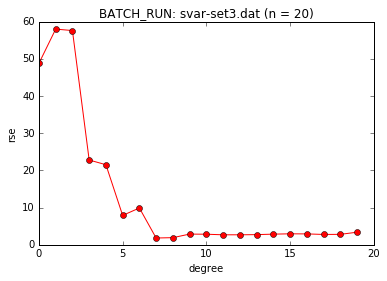

BATCH_RUN: svar-set3.dat (n = 20)
J_min = 0.0193883	n = 13
rse_min = 1.8246027	n = 8
running time: [0.005118846893310547, 0.005496025085449219, 0.0065190792083740234, 0.006386995315551758, 0.007659196853637695, 0.006231069564819336, 0.006620883941650391, 0.006574869155883789, 0.007099151611328125, 0.0069561004638671875, 0.007784843444824219, 0.008476018905639648, 0.008642911911010742, 0.008769035339355469, 0.010330915451049805, 0.009510993957519531, 0.009387969970703125, 0.008926153182983398, 0.009911060333251953, 0.009319067001342773] 




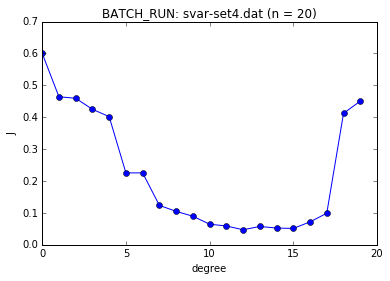

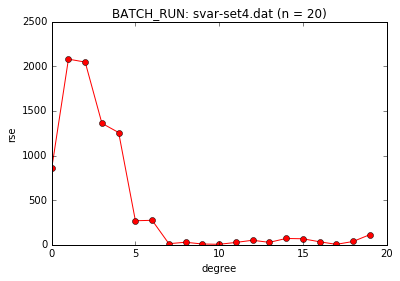

BATCH_RUN: svar-set4.dat (n = 20)
J_min = 0.0472079	n = 13
rse_min = 4.9942140	n = 18
running time: [0.006206989288330078, 0.005260944366455078, 0.0069751739501953125, 0.005558967590332031, 0.0065920352935791016, 0.006000995635986328, 0.006337881088256836, 0.006735086441040039, 0.006670951843261719, 0.0068891048431396484, 0.007075071334838867, 0.007299900054931641, 0.007536888122558594, 0.007781028747558594, 0.008130073547363281, 0.008188009262084961, 0.00842905044555664, 0.008661031723022461, 0.00889897346496582, 0.00917196273803711] 




In [128]:
# run all datasets, fit sklearn linear regression model with degree from 1 to 20
batch_run(s_fnames, 'sklearn', 20, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=2.1148345	train_rse_avg=0.0018407	
	test_J_avg=2.1438345	test_rse_avg=0.0018591
RUN: svar-set1.dat (n = 1)
applied to all data (n = 1):
	J=2.1162853	rse=0.0018416
running time: 0.00253295898438


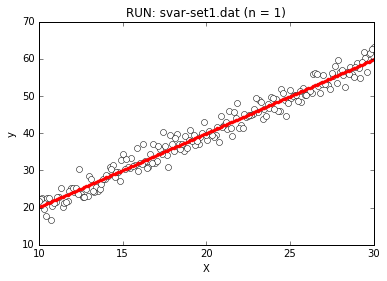

CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=2.1124460	train_rse_avg=0.0018324	
	test_J_avg=2.1846341	test_rse_avg=0.0019253
RUN: svar-set1.dat (n = 2)
applied to all data (n = 2):
	J=2.1160277	rse=0.0018365
running time: 0.00241684913635


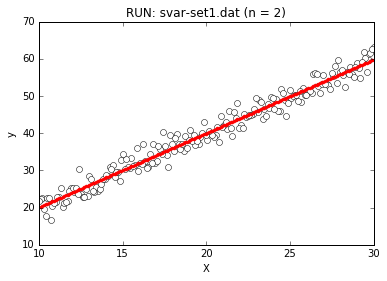

CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=2.0765671	train_rse_avg=0.0018082	
	test_J_avg=2.1783679	test_rse_avg=0.0019733
RUN: svar-set1.dat (n = 3)
applied to all data (n = 3):
	J=2.0815819	rse=0.0018171
running time: 0.00295686721802


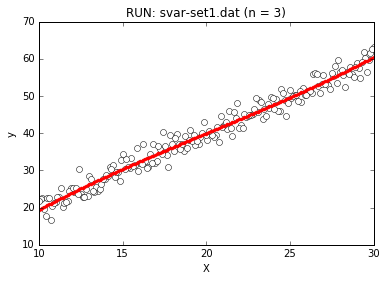

CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=2.0590872	train_rse_avg=0.0017873	
	test_J_avg=2.1981168	test_rse_avg=0.0019074
RUN: svar-set1.dat (n = 4)
applied to all data (n = 4):
	J=2.0659213	rse=0.0017927
running time: 0.00353384017944


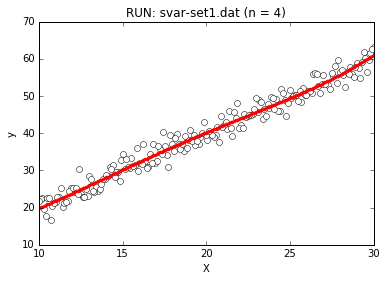

CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=2.0553275	train_rse_avg=0.0017710	
	test_J_avg=2.2133263	test_rse_avg=0.0019405
RUN: svar-set1.dat (n = 5)
applied to all data (n = 5):
	J=2.0629368	rse=0.0017803
running time: 0.00279998779297


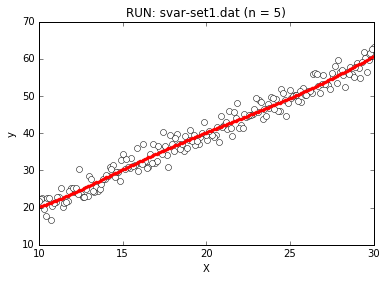

CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=2.0066111	train_rse_avg=0.0017271	
	test_J_avg=2.1746238	test_rse_avg=0.0018942
RUN: svar-set1.dat (n = 6)
applied to all data (n = 6):
	J=2.0147714	rse=0.0017359
running time: 0.00295495986938


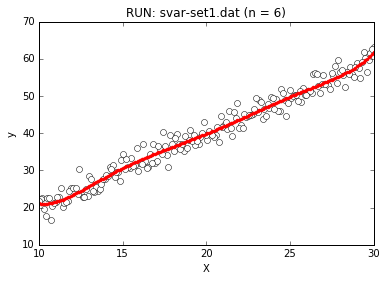

CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=2.0074039	train_rse_avg=0.0017304	
	test_J_avg=2.1301009	test_rse_avg=0.0018754
RUN: svar-set1.dat (n = 7)
applied to all data (n = 7):
	J=2.0134392	rse=0.0017382
running time: 0.00335121154785


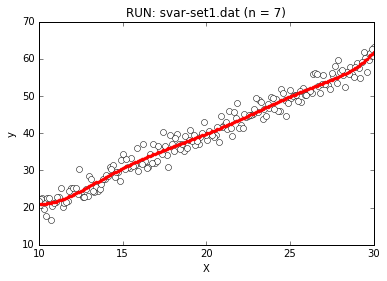

CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=2.0060903	train_rse_avg=0.0017327	
	test_J_avg=2.1683562	test_rse_avg=0.0019026
RUN: svar-set1.dat (n = 8)
applied to all data (n = 8):
	J=2.0140230	rse=0.0017409
running time: 0.00336694717407


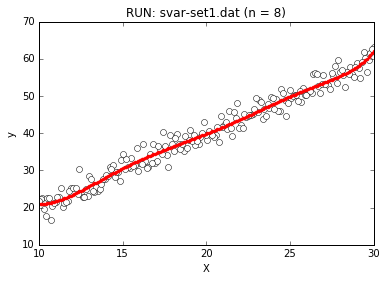

CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=2.0054249	train_rse_avg=0.0017364	
	test_J_avg=2.2434297	test_rse_avg=0.0019300
RUN: svar-set1.dat (n = 9)
applied to all data (n = 9):
	J=2.0171187	rse=0.0017468
running time: 0.0036768913269


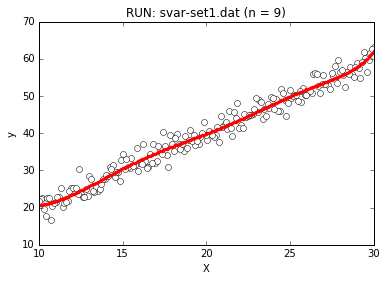

CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=2.0177460	train_rse_avg=0.0017514	
	test_J_avg=2.1547636	test_rse_avg=0.0018725
RUN: svar-set1.dat (n = 10)
applied to all data (n = 10):
	J=2.0244287	rse=0.0017574
running time: 0.00471711158752


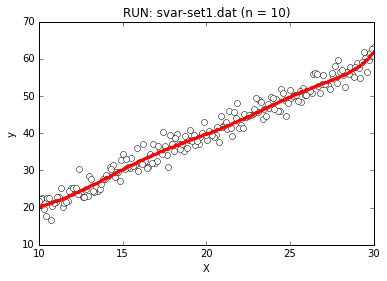

CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=2.0310833	train_rse_avg=0.0017710	
	test_J_avg=2.1963795	test_rse_avg=0.0019165
RUN: svar-set1.dat (n = 11)
applied to all data (n = 11):
	J=2.0391092	rse=0.0017781
running time: 0.00427508354187


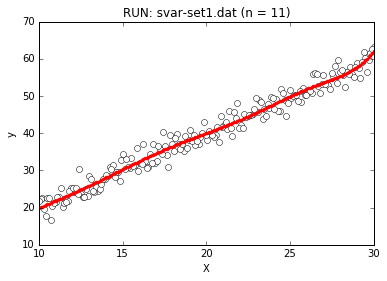

CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=2.2634443	train_rse_avg=0.0021519	
	test_J_avg=2.4204649	test_rse_avg=0.0022863
RUN: svar-set1.dat (n = 12)
applied to all data (n = 12):
	J=2.2712204	rse=0.0021591
running time: 0.00809001922607


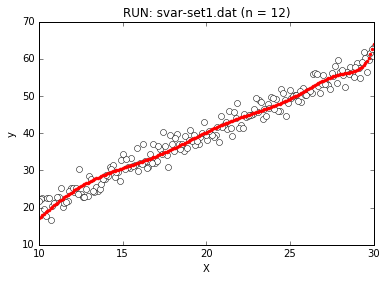

CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=2.7739216	train_rse_avg=0.0029722	
	test_J_avg=3.0054211	test_rse_avg=0.0031210
RUN: svar-set1.dat (n = 13)
applied to all data (n = 13):
	J=2.7847004	rse=0.0029816
running time: 0.00486397743225


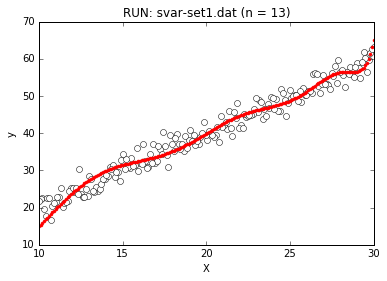

CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=4.0825338	train_rse_avg=0.0051114	
	test_J_avg=4.3554160	test_rse_avg=0.0053181
RUN: svar-set1.dat (n = 14)
applied to all data (n = 14):
	J=4.0956271	rse=0.0051269
running time: 0.00625586509705


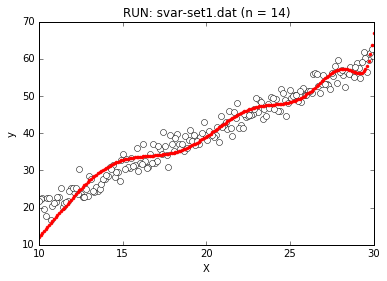

CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=6.7789330	train_rse_avg=0.0096422	
	test_J_avg=7.4469219	test_rse_avg=0.0100091
RUN: svar-set1.dat (n = 15)
applied to all data (n = 15):
	J=6.8070576	rse=0.0096793
running time: 0.00769305229187


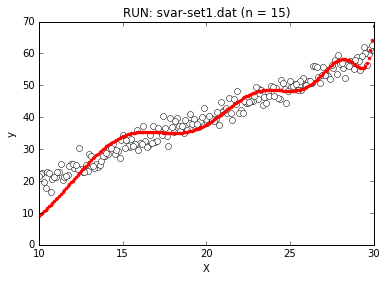

CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=11.3428648	train_rse_avg=0.0174052	
	test_J_avg=15.3756434	test_rse_avg=0.0186355
RUN: svar-set1.dat (n = 16)
applied to all data (n = 16):
	J=11.4147005	rse=0.0175210
running time: 0.00563716888428


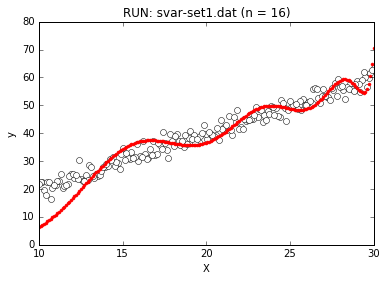

CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=18.0156111	train_rse_avg=0.0286618	
	test_J_avg=19.2712768	test_rse_avg=0.0295895
RUN: svar-set1.dat (n = 17)
applied to all data (n = 17):
	J=18.0717944	rse=0.0287503
running time: 0.00580716133118


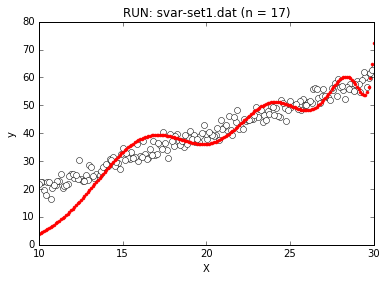

CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=26.5086507	train_rse_avg=0.0425200	
	test_J_avg=28.3100645	test_rse_avg=0.0433364
RUN: svar-set1.dat (n = 18)
applied to all data (n = 18):
	J=26.5774466	rse=0.0426201
running time: 0.00579118728638


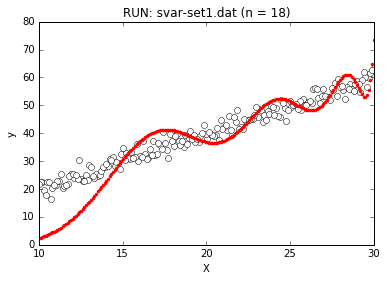

CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=36.4563779	train_rse_avg=0.0578924	
	test_J_avg=38.6419205	test_rse_avg=0.0588851
RUN: svar-set1.dat (n = 19)
applied to all data (n = 19):
	J=36.5364647	rse=0.0580021
running time: 0.00669503211975


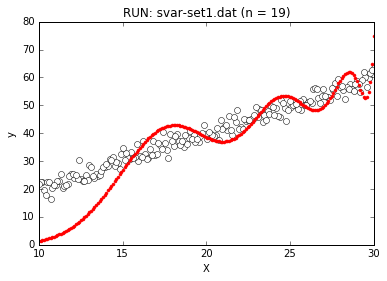

CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=68.5661385	train_rse_avg=0.0990783	
	test_J_avg=68.5843357	test_rse_avg=0.0955362
RUN: svar-set1.dat (n = 20)
applied to all data (n = 20):
	J=47.5231126	rse=0.0738420
running time: 0.00673294067383


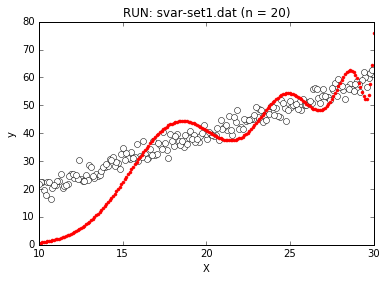

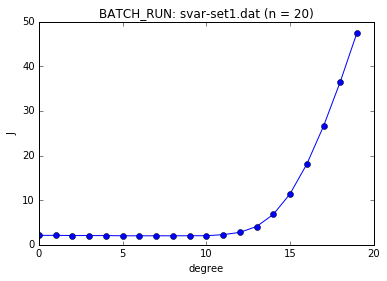

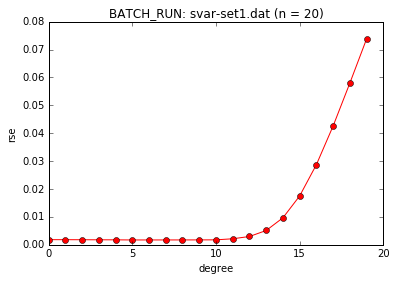

BATCH_RUN: svar-set1.dat (n = 20)
J_min = 2.0134392	n = 7
rse_min = 0.0017359	n = 6
running time: [0.002532958984375, 0.002416849136352539, 0.002956867218017578, 0.0035338401794433594, 0.00279998779296875, 0.0029549598693847656, 0.0033512115478515625, 0.0033669471740722656, 0.003676891326904297, 0.004717111587524414, 0.004275083541870117, 0.008090019226074219, 0.0048639774322509766, 0.0062558650970458984, 0.007693052291870117, 0.005637168884277344, 0.005807161331176758, 0.005791187286376953, 0.0066950321197509766, 0.006732940673828125] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.0297285	train_rse_avg=49.6814666	
	test_J_avg=0.0309059	test_rse_avg=59.5788888
RUN: svar-set2.dat (n = 1)
applied to all data (n = 1):
	J=0.0297863	rse=50.3872921
running time: 0.00269103050232


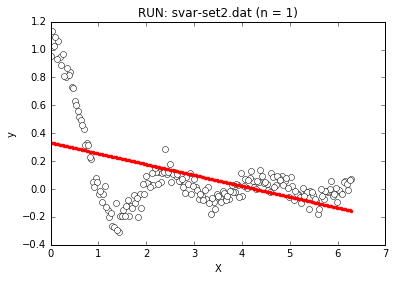

CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.0192948	train_rse_avg=23.9720349	
	test_J_avg=0.0201987	test_rse_avg=25.1825989
RUN: svar-set2.dat (n = 2)
applied to all data (n = 2):
	J=0.0193392	rse=23.8525883
running time: 0.00228691101074


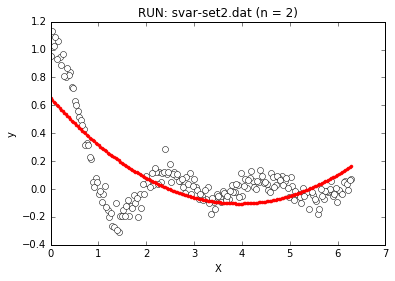

CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.0101491	train_rse_avg=11.2718104	
	test_J_avg=0.0106261	test_rse_avg=11.0099515
RUN: svar-set2.dat (n = 3)
applied to all data (n = 3):
	J=0.0101726	rse=11.0875431
running time: 0.00366711616516


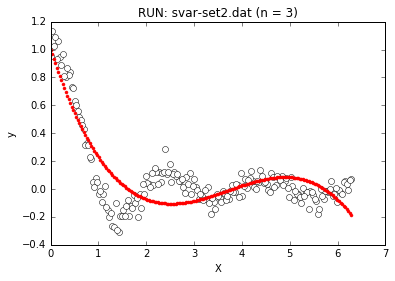

CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.0057313	train_rse_avg=11.1154872	
	test_J_avg=0.0061123	test_rse_avg=11.4044256
RUN: svar-set2.dat (n = 4)
applied to all data (n = 4):
	J=0.0057495	rse=11.0441311
running time: 0.0026228427887


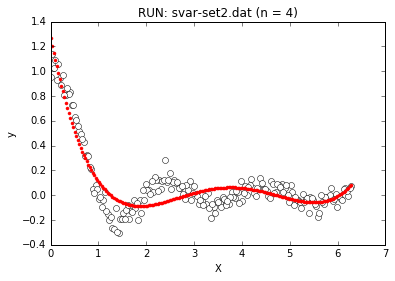

CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.0055102	train_rse_avg=3.6473234	
	test_J_avg=0.0061725	test_rse_avg=4.2261662
RUN: svar-set2.dat (n = 5)
applied to all data (n = 5):
	J=0.0055424	rse=3.6574201
running time: 0.00394201278687


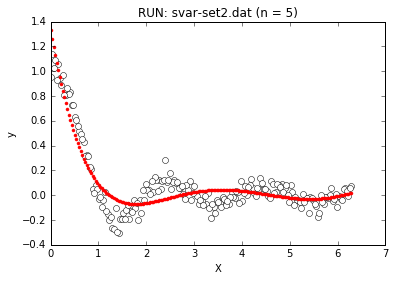

CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.0054173	train_rse_avg=2.2421891	
	test_J_avg=0.0061894	test_rse_avg=2.0964024
RUN: svar-set2.dat (n = 6)
applied to all data (n = 6):
	J=0.0054522	rse=2.1442261
running time: 0.00299501419067


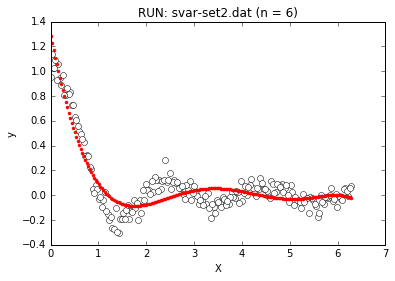

CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.0029222	train_rse_avg=26.5393988	
	test_J_avg=0.0031670	test_rse_avg=30.1736386
RUN: svar-set2.dat (n = 7)
applied to all data (n = 7):
	J=0.0029339	rse=26.6634246
running time: 0.00318217277527


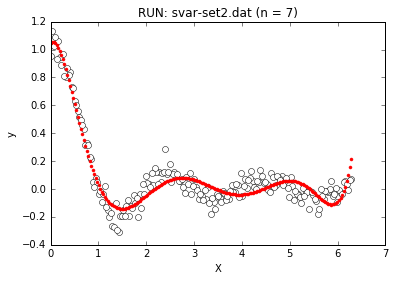

CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.0019068	train_rse_avg=15.1548727	
	test_J_avg=0.0021293	test_rse_avg=18.1082423
RUN: svar-set2.dat (n = 8)
applied to all data (n = 8):
	J=0.0019174	rse=15.1082472
running time: 0.0042519569397


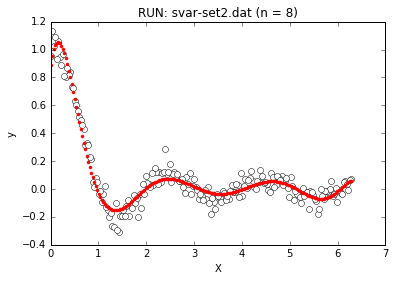

CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.0016293	train_rse_avg=21.7077812	
	test_J_avg=0.0018785	test_rse_avg=24.4671051
RUN: svar-set2.dat (n = 9)
applied to all data (n = 9):
	J=0.0016409	rse=21.8854920
running time: 0.00486707687378


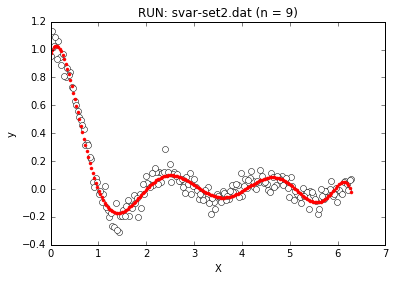

CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0012760	train_rse_avg=10.9126018	
	test_J_avg=0.0014994	test_rse_avg=10.6813974
RUN: svar-set2.dat (n = 10)
applied to all data (n = 10):
	J=0.0012859	rse=10.8319258
running time: 0.00601100921631


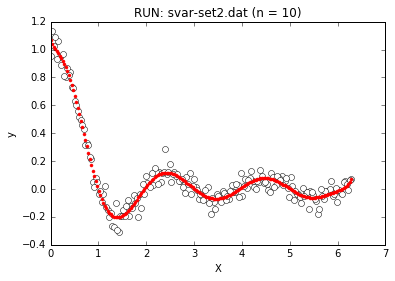

CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0012727	train_rse_avg=10.3312296	
	test_J_avg=0.0015662	test_rse_avg=14.0148027
RUN: svar-set2.dat (n = 11)
applied to all data (n = 11):
	J=0.0012852	rse=10.4715127
running time: 0.00564193725586


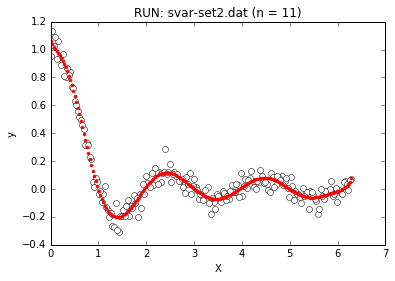

CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0012565	train_rse_avg=11.9434168	
	test_J_avg=0.0015243	test_rse_avg=14.3646573
RUN: svar-set2.dat (n = 12)
applied to all data (n = 12):
	J=0.0012681	rse=12.1112193
running time: 0.00453495979309


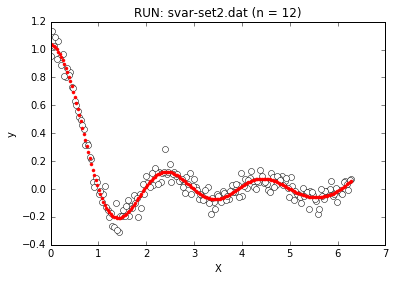

CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0012400	train_rse_avg=11.3111495	
	test_J_avg=0.0015936	test_rse_avg=13.3898692
RUN: svar-set2.dat (n = 13)
applied to all data (n = 13):
	J=0.0012548	rse=11.3663752
running time: 0.0064389705658


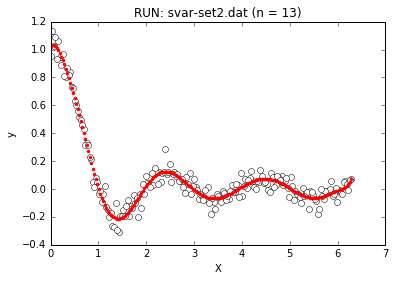

CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0012387	train_rse_avg=11.3793266	
	test_J_avg=0.0016063	test_rse_avg=14.8481779
RUN: svar-set2.dat (n = 14)
applied to all data (n = 14):
	J=0.0012537	rse=11.5248858
running time: 0.00504684448242


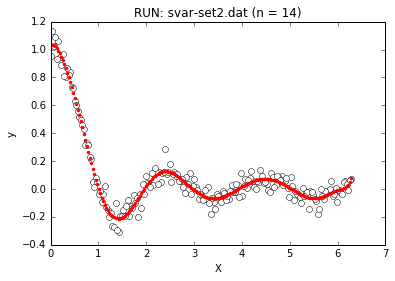

CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0012427	train_rse_avg=11.6865577	
	test_J_avg=0.0015113	test_rse_avg=15.5357810
RUN: svar-set2.dat (n = 15)
applied to all data (n = 15):
	J=0.0012538	rse=11.9512380
running time: 0.00516986846924


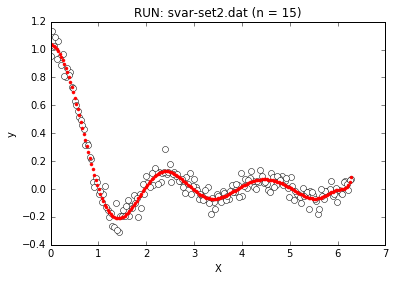

CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0012419	train_rse_avg=11.8740880	
	test_J_avg=0.0015062	test_rse_avg=13.2392943
RUN: svar-set2.dat (n = 16)
applied to all data (n = 16):
	J=0.0012539	rse=12.0341948
running time: 0.00536108016968


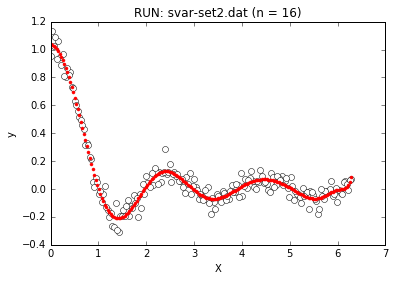

CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.0012442	train_rse_avg=12.4505530	
	test_J_avg=0.0014958	test_rse_avg=9.0938155
RUN: svar-set2.dat (n = 17)
applied to all data (n = 17):
	J=0.0012558	rse=12.3985460
running time: 0.00757384300232


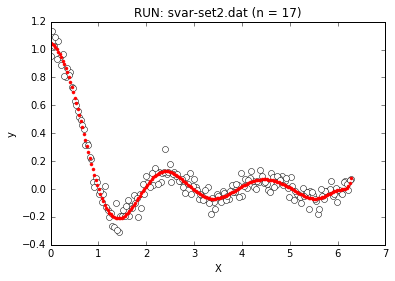

CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.0013012	train_rse_avg=10.4806073	
	test_J_avg=0.0015321	test_rse_avg=13.9007286
RUN: svar-set2.dat (n = 18)
applied to all data (n = 18):
	J=0.0013034	rse=11.0353798
running time: 0.00735306739807


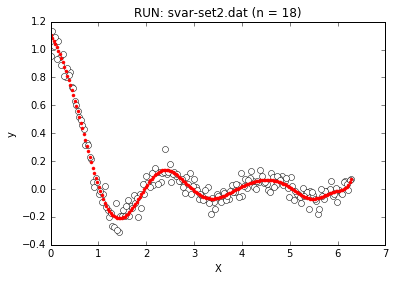

CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.0135752	train_rse_avg=18.3659449	
	test_J_avg=0.0163290	test_rse_avg=22.5152390
RUN: svar-set2.dat (n = 19)
applied to all data (n = 19):
	J=0.0136029	rse=17.1980874
running time: 0.00784301757812


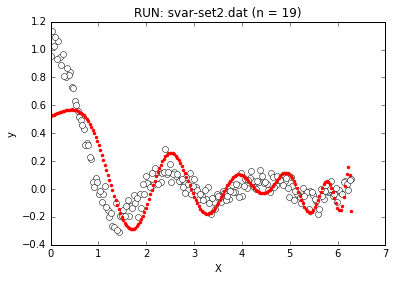

CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.0422977	train_rse_avg=11.5127123	
	test_J_avg=0.0425046	test_rse_avg=15.9828640
RUN: svar-set2.dat (n = 20)
applied to all data (n = 20):
	J=0.0422855	rse=11.4602461
running time: 0.00798511505127


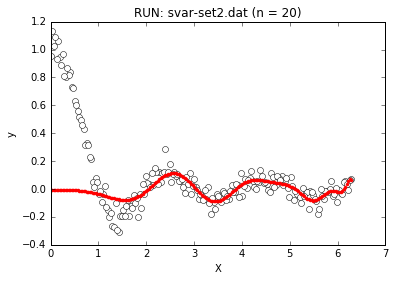

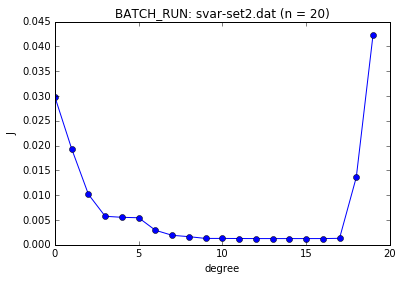

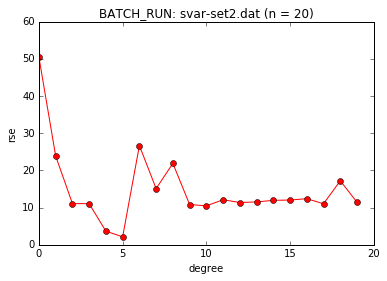

BATCH_RUN: svar-set2.dat (n = 20)
J_min = 0.0012537	n = 14
rse_min = 2.1442261	n = 6
running time: [0.002691030502319336, 0.0022869110107421875, 0.003667116165161133, 0.002622842788696289, 0.003942012786865234, 0.002995014190673828, 0.0031821727752685547, 0.004251956939697266, 0.004867076873779297, 0.006011009216308594, 0.005641937255859375, 0.00453495979309082, 0.0064389705657958984, 0.005046844482421875, 0.005169868469238281, 0.005361080169677734, 0.007573843002319336, 0.007353067398071289, 0.007843017578125, 0.007985115051269531] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.2490881	train_rse_avg=48.9879753	
	test_J_avg=0.2544650	test_rse_avg=48.6165895
RUN: svar-set3.dat (n = 1)
applied to all data (n = 1):
	J=0.2493569	rse=48.7861839
running time: 0.00192284584045


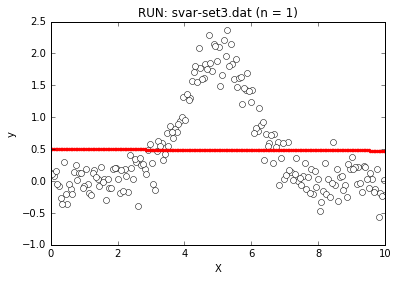

CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.1264938	train_rse_avg=57.6523178	
	test_J_avg=0.1294352	test_rse_avg=62.5762107
RUN: svar-set3.dat (n = 2)
applied to all data (n = 2):
	J=0.1266392	rse=57.9834839
running time: 0.00210404396057


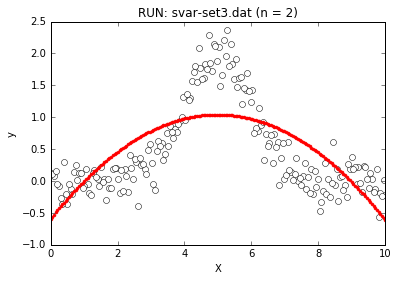

CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.1263453	train_rse_avg=57.7819335	
	test_J_avg=0.1322791	test_rse_avg=59.2237461
RUN: svar-set3.dat (n = 3)
applied to all data (n = 3):
	J=0.1266376	rse=57.5942205
running time: 0.00236892700195


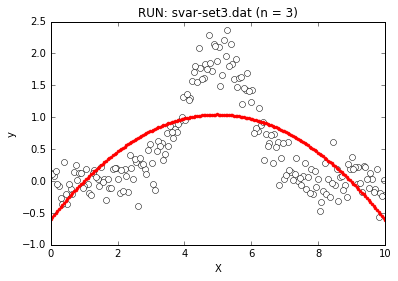

CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.0631588	train_rse_avg=22.7960767	
	test_J_avg=0.0671844	test_rse_avg=23.7020963
RUN: svar-set3.dat (n = 4)
applied to all data (n = 4):
	J=0.0633565	rse=22.7893430
running time: 0.00265598297119


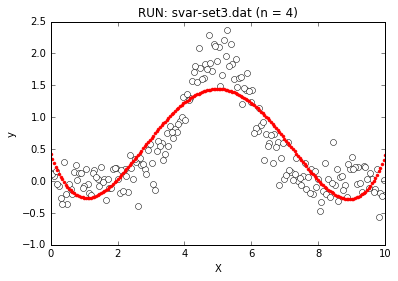

CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.0629398	train_rse_avg=21.5374628	
	test_J_avg=0.0680263	test_rse_avg=23.7510967
RUN: svar-set3.dat (n = 5)
applied to all data (n = 5):
	J=0.0631844	rse=21.5313993
running time: 0.00286388397217


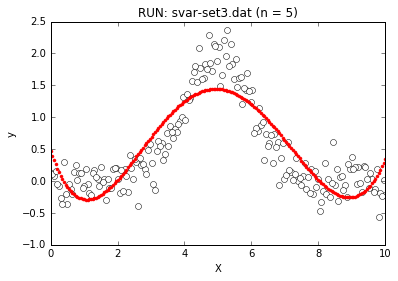

CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.0314542	train_rse_avg=7.8965738	
	test_J_avg=0.0339881	test_rse_avg=8.5807205
RUN: svar-set3.dat (n = 6)
applied to all data (n = 6):
	J=0.0315778	rse=7.8991745
running time: 0.00397801399231


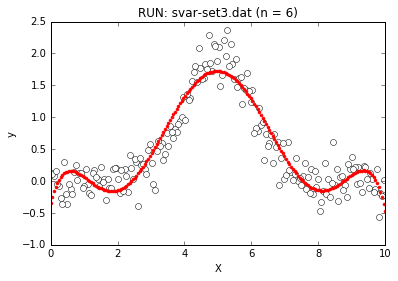

CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.0308015	train_rse_avg=9.7528762	
	test_J_avg=0.0344356	test_rse_avg=13.4536373
RUN: svar-set3.dat (n = 7)
applied to all data (n = 7):
	J=0.0309723	rse=9.8969299
running time: 0.00318598747253


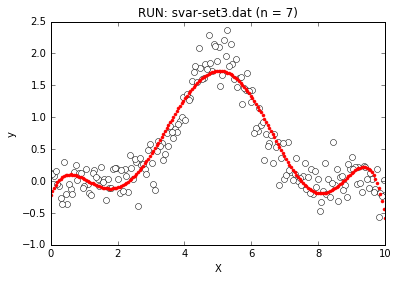

CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.0219164	train_rse_avg=1.8057837	
	test_J_avg=0.0237447	test_rse_avg=2.5452367
RUN: svar-set3.dat (n = 8)
applied to all data (n = 8):
	J=0.0220054	rse=1.8246026
running time: 0.00338101387024


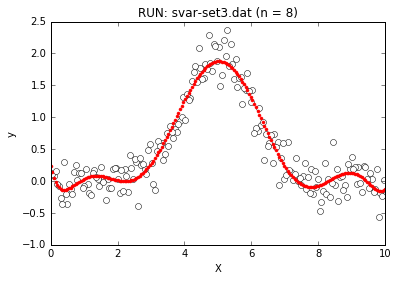

CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.0219004	train_rse_avg=1.8977678	
	test_J_avg=0.0238404	test_rse_avg=3.0824294
RUN: svar-set3.dat (n = 9)
applied to all data (n = 9):
	J=0.0219938	rse=1.9217622
running time: 0.00385904312134


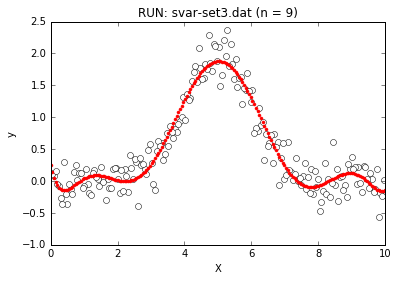

CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0207610	train_rse_avg=2.7616903	
	test_J_avg=0.0247543	test_rse_avg=10.5074895
RUN: svar-set3.dat (n = 10)
applied to all data (n = 10):
	J=0.0209283	rse=2.8771192
running time: 0.00439095497131


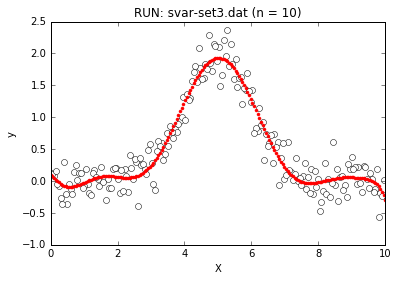

CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0207627	train_rse_avg=2.7845927	
	test_J_avg=0.0238830	test_rse_avg=4.5779720
RUN: svar-set3.dat (n = 11)
applied to all data (n = 11):
	J=0.0209110	rse=2.8436557
running time: 0.0058159828186


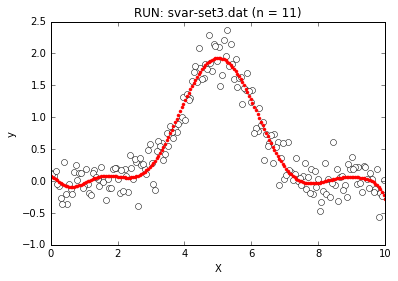

CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0192808	train_rse_avg=2.6944163	
	test_J_avg=0.0216055	test_rse_avg=2.9725267
RUN: svar-set3.dat (n = 12)
applied to all data (n = 12):
	J=0.0193919	rse=2.6888762
running time: 0.00620579719543


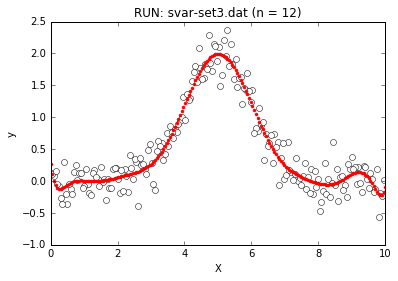

CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0195315	train_rse_avg=2.6812943	
	test_J_avg=0.0226661	test_rse_avg=3.9327213
RUN: svar-set3.dat (n = 13)
applied to all data (n = 13):
	J=0.0196784	rse=2.7061340
running time: 0.00464105606079


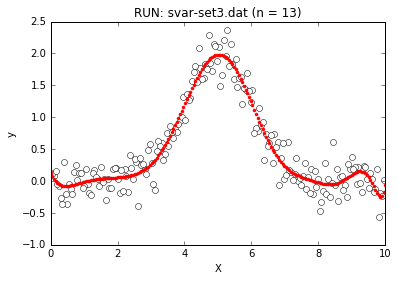

CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0196711	train_rse_avg=2.6351665	
	test_J_avg=0.0226558	test_rse_avg=4.1140519
RUN: svar-set3.dat (n = 14)
applied to all data (n = 14):
	J=0.0198080	rse=2.7347632
running time: 0.00529408454895


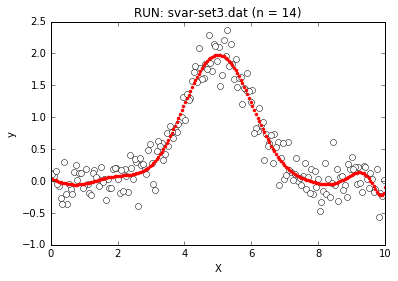

CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0196128	train_rse_avg=2.6478020	
	test_J_avg=0.0219595	test_rse_avg=4.1119999
RUN: svar-set3.dat (n = 15)
applied to all data (n = 15):
	J=0.0197192	rse=2.7610020
running time: 0.00512790679932


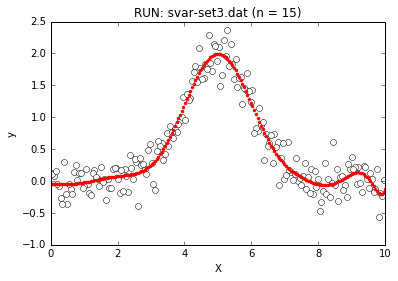

CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0195687	train_rse_avg=2.8198017	
	test_J_avg=0.0223406	test_rse_avg=3.8676432
RUN: svar-set3.dat (n = 16)
applied to all data (n = 16):
	J=0.0197007	rse=2.8772298
running time: 0.00540113449097


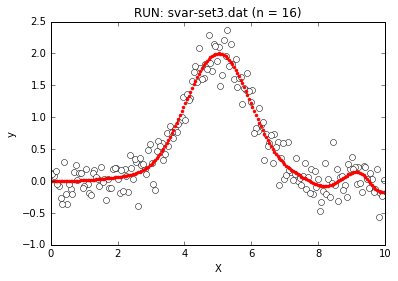

CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.0197811	train_rse_avg=2.6885586	
	test_J_avg=0.0218224	test_rse_avg=3.6566495
RUN: svar-set3.dat (n = 17)
applied to all data (n = 17):
	J=0.0198779	rse=2.7483297
running time: 0.00561189651489


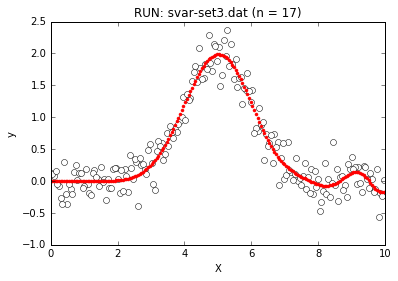

CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.0197899	train_rse_avg=2.6952085	
	test_J_avg=0.0217428	test_rse_avg=3.9542419
RUN: svar-set3.dat (n = 18)
applied to all data (n = 18):
	J=0.0198831	rse=2.8071241
running time: 0.00658583641052


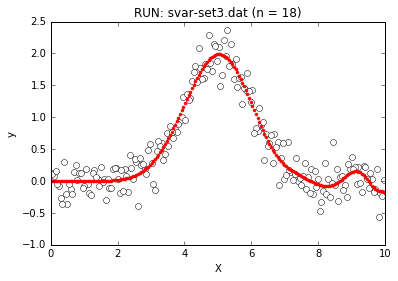

CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.0197167	train_rse_avg=2.7335300	
	test_J_avg=0.0218902	test_rse_avg=3.2948501
RUN: svar-set3.dat (n = 19)
applied to all data (n = 19):
	J=0.0198182	rse=2.8053081
running time: 0.00778985023499


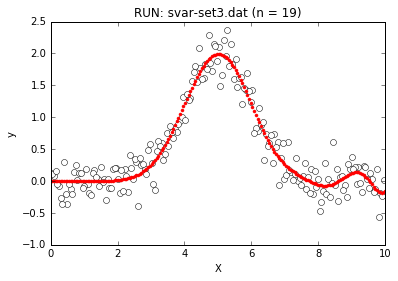

CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.0198207	train_rse_avg=3.0926295	
	test_J_avg=0.0229963	test_rse_avg=5.5469301
RUN: svar-set3.dat (n = 20)
applied to all data (n = 20):
	J=0.0199419	rse=3.4085975
running time: 0.00839400291443


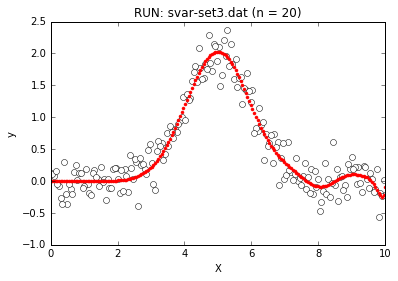

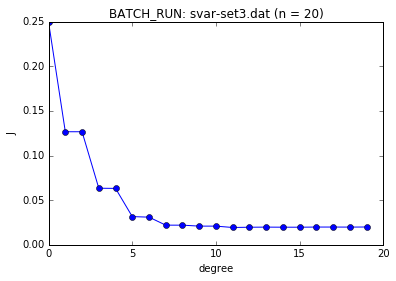

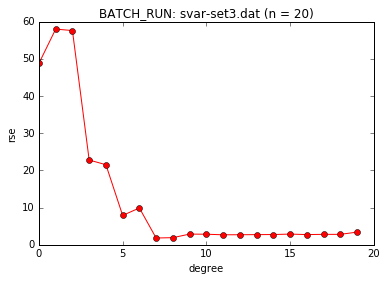

BATCH_RUN: svar-set3.dat (n = 20)
J_min = 0.0193919	n = 12
rse_min = 1.8246026	n = 8
running time: [0.0019228458404541016, 0.002104043960571289, 0.002368927001953125, 0.0026559829711914062, 0.0028638839721679688, 0.00397801399230957, 0.0031859874725341797, 0.003381013870239258, 0.0038590431213378906, 0.0043909549713134766, 0.005815982818603516, 0.00620579719543457, 0.004641056060791016, 0.005294084548950195, 0.005127906799316406, 0.005401134490966797, 0.005611896514892578, 0.006585836410522461, 0.0077898502349853516, 0.008394002914428711] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.5997399	train_rse_avg=852.3005161	
	test_J_avg=0.6129760	test_rse_avg=891.8694765
RUN: svar-set4.dat (n = 1)
applied to all data (n = 1):
	J=0.6004040	rse=855.0362917
running time: 0.00201606750488


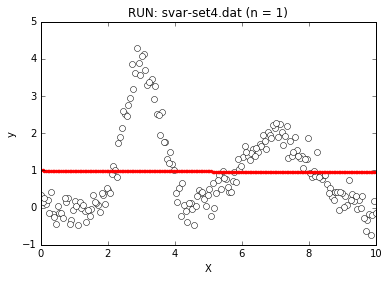

CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.4637774	train_rse_avg=2066.9233997	
	test_J_avg=0.4731740	test_rse_avg=2222.0998417
RUN: svar-set4.dat (n = 2)
applied to all data (n = 2):
	J=0.4642465	rse=2079.5649952
running time: 0.00211501121521


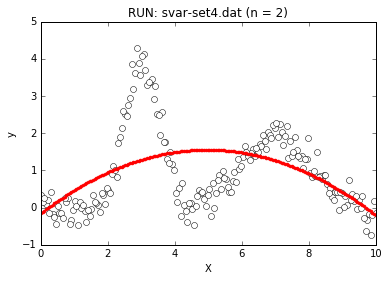

CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.4586865	train_rse_avg=2031.7695846	
	test_J_avg=0.4765043	test_rse_avg=2179.7340368
RUN: svar-set4.dat (n = 3)
applied to all data (n = 3):
	J=0.4595738	rse=2046.5999411
running time: 0.00247478485107


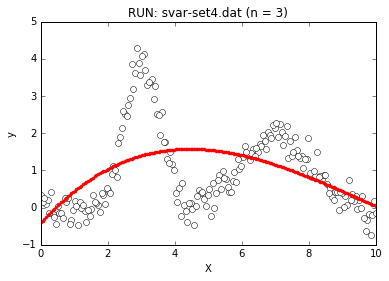

CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.4240606	train_rse_avg=1360.1911012	
	test_J_avg=0.4427228	test_rse_avg=1376.7789866
RUN: svar-set4.dat (n = 4)
applied to all data (n = 4):
	J=0.4249857	rse=1360.7441152
running time: 0.0027859210968


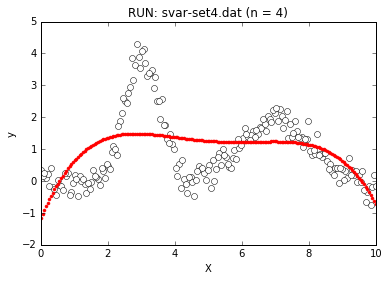

CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.4007594	train_rse_avg=1254.8254915	
	test_J_avg=0.4253750	test_rse_avg=1285.3261370
RUN: svar-set4.dat (n = 5)
applied to all data (n = 5):
	J=0.4019738	rse=1257.1636155
running time: 0.00333905220032


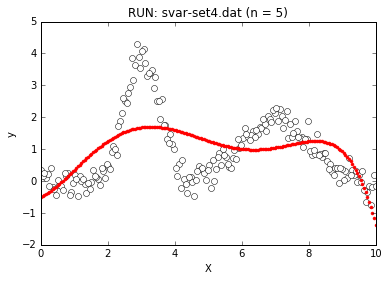

CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.2246345	train_rse_avg=264.8810882	
	test_J_avg=0.2441486	test_rse_avg=308.2914723
RUN: svar-set4.dat (n = 6)
applied to all data (n = 6):
	J=0.2255884	rse=269.4587897
running time: 0.00300002098083


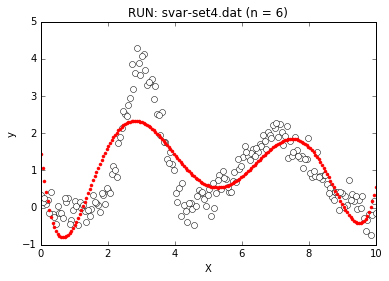

CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.2243736	train_rse_avg=272.3096691	
	test_J_avg=0.2469531	test_rse_avg=277.2006238
RUN: svar-set4.dat (n = 7)
applied to all data (n = 7):
	J=0.2254291	rse=274.2486206
running time: 0.00433206558228


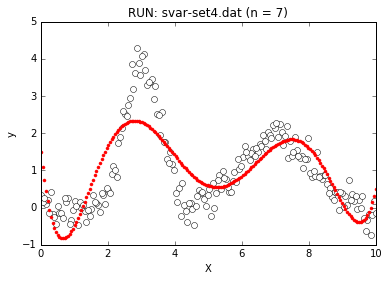

CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.1230101	train_rse_avg=12.5497842	
	test_J_avg=0.1365221	test_rse_avg=16.2233246
RUN: svar-set4.dat (n = 8)
applied to all data (n = 8):
	J=0.1236514	rse=12.4624807
running time: 0.00337100028992


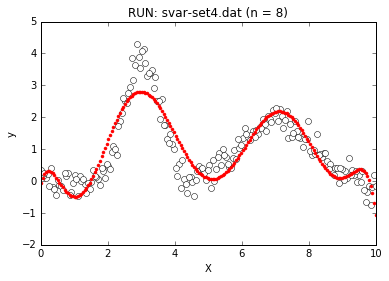

CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.1039029	train_rse_avg=29.1460894	
	test_J_avg=0.1249998	test_rse_avg=29.3803998
RUN: svar-set4.dat (n = 9)
applied to all data (n = 9):
	J=0.1048585	rse=28.6144668
running time: 0.0036358833313


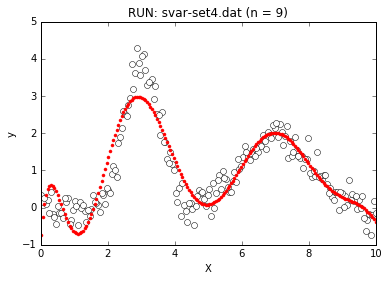

CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0892508	train_rse_avg=9.2980058	
	test_J_avg=0.0978498	test_rse_avg=8.9054062
RUN: svar-set4.dat (n = 10)
applied to all data (n = 10):
	J=0.0896451	rse=8.7697612
running time: 0.00405097007751


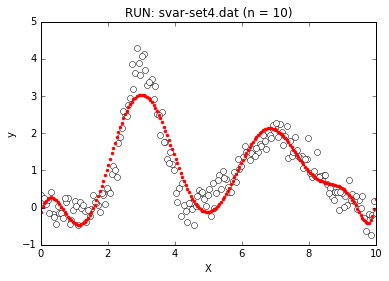

CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0641868	train_rse_avg=5.6269243	
	test_J_avg=0.0731588	test_rse_avg=9.1696811
RUN: svar-set4.dat (n = 11)
applied to all data (n = 11):
	J=0.0646073	rse=5.6429848
running time: 0.00416088104248


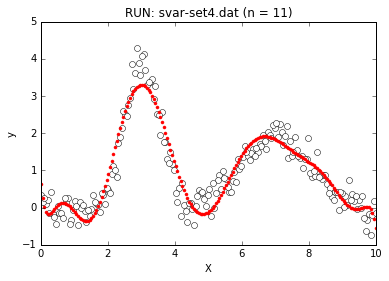

CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0584018	train_rse_avg=27.5938551	
	test_J_avg=0.0731071	test_rse_avg=26.1648316
RUN: svar-set4.dat (n = 12)
applied to all data (n = 12):
	J=0.0589892	rse=26.5076061
running time: 0.00457811355591


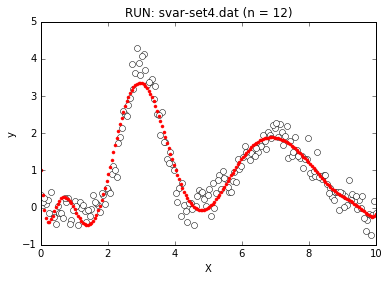

CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0470973	train_rse_avg=54.9370989	
	test_J_avg=0.0570498	test_rse_avg=37.6020999
RUN: svar-set4.dat (n = 13)
applied to all data (n = 13):
	J=0.0475288	rse=51.6735155
running time: 0.00601816177368


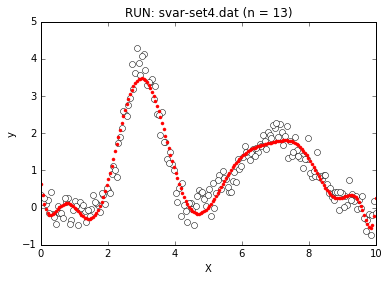

CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0571337	train_rse_avg=25.7485403	
	test_J_avg=0.0702816	test_rse_avg=32.7278246
RUN: svar-set4.dat (n = 14)
applied to all data (n = 14):
	J=0.0576496	rse=24.9576057
running time: 0.00502514839172


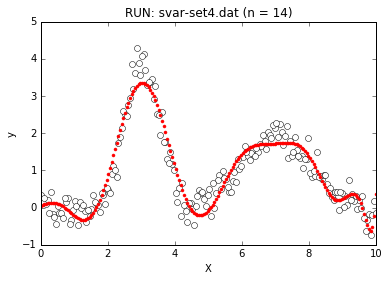

CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0756336	train_rse_avg=5.5149287	
	test_J_avg=0.0920153	test_rse_avg=5.0209507
RUN: svar-set4.dat (n = 15)
applied to all data (n = 15):
	J=0.0762688	rse=4.5023798
running time: 0.00520706176758


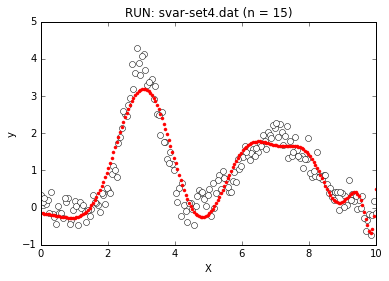

CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0989538	train_rse_avg=6.3362578	
	test_J_avg=0.1162766	test_rse_avg=8.0520788
RUN: svar-set4.dat (n = 16)
applied to all data (n = 16):
	J=0.0995785	rse=4.9062637
running time: 0.00535202026367


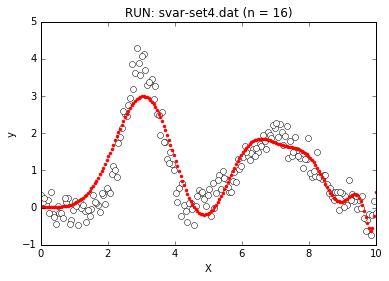

CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.2316129	train_rse_avg=156.2312475	
	test_J_avg=0.2904093	test_rse_avg=306.4913772
RUN: svar-set4.dat (n = 17)
applied to all data (n = 17):
	J=0.2337071	rse=165.1541738
running time: 0.00575709342957


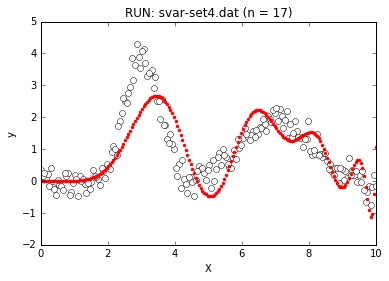

CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.3916843	train_rse_avg=121.7146224	
	test_J_avg=0.4727211	test_rse_avg=77.2005518
RUN: svar-set4.dat (n = 18)
applied to all data (n = 18):
	J=0.3939959	rse=110.8154270
running time: 0.0058319568634


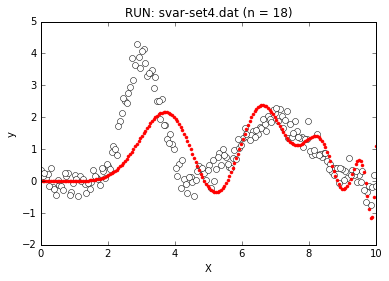

CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.5319331	train_rse_avg=16.8303479	
	test_J_avg=0.6248087	test_rse_avg=39.4953772
RUN: svar-set4.dat (n = 19)
applied to all data (n = 19):
	J=0.5346580	rse=13.8437687
running time: 0.00615310668945


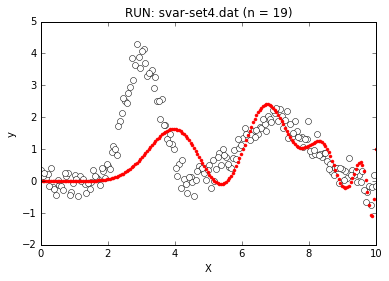

CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.6285228	train_rse_avg=133.0361218	
	test_J_avg=0.8634308	test_rse_avg=90.5824011
RUN: svar-set4.dat (n = 20)
applied to all data (n = 20):
	J=0.6306607	rse=132.4616621
running time: 0.00841307640076


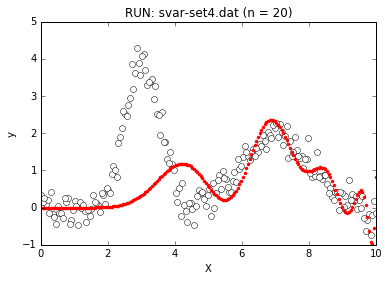

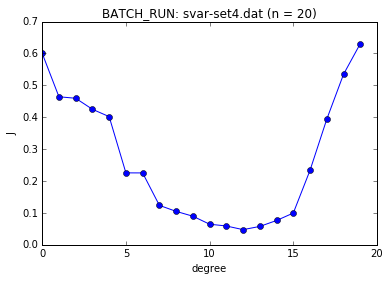

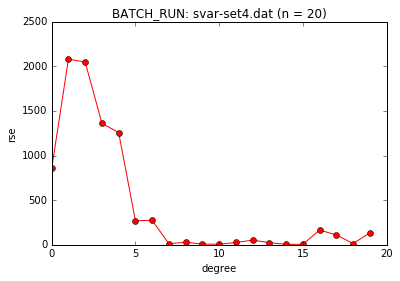

BATCH_RUN: svar-set4.dat (n = 20)
J_min = 0.0475288	n = 13
rse_min = 4.5023798	n = 15
running time: [0.0020160675048828125, 0.002115011215209961, 0.0024747848510742188, 0.002785921096801758, 0.003339052200317383, 0.003000020980834961, 0.004332065582275391, 0.003371000289916992, 0.003635883331298828, 0.0040509700775146484, 0.004160881042480469, 0.004578113555908203, 0.006018161773681641, 0.005025148391723633, 0.005207061767578125, 0.005352020263671875, 0.00575709342956543, 0.00583195686340332, 0.006153106689453125, 0.008413076400756836] 




In [129]:
# run all datasets, fit linear regression model with degree from 1 to 20
# plot all results and graphs
batch_run(s_fnames, 'explicit', 20, \
          r_verbose=True, pl_verbose=True, bpl_verbose=True)

SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=2.1127463	train_rse_avg=0.0018367	
	test_J_avg=2.1843763	test_rse_avg=0.0019227
RUN: svar-set1.dat (n = 1)
applied to all data (n = 1):
	J=2.1162853	rse=0.0018416
running time: 0.00698184967041


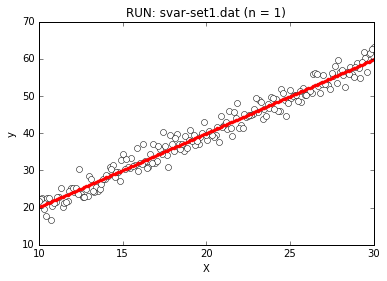

SKLEARN_CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=2.1108911	train_rse_avg=0.0018298	
	test_J_avg=2.2153754	test_rse_avg=0.0019556
RUN: svar-set1.dat (n = 2)
applied to all data (n = 2):
	J=2.1160277	rse=0.0018365
running time: 0.0053129196167


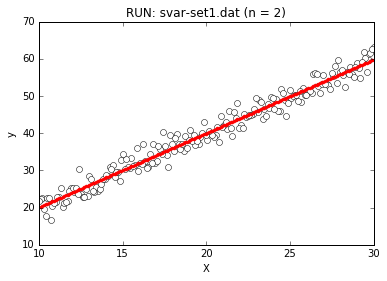

SKLEARN_CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=2.0743363	train_rse_avg=0.0018076	
	test_J_avg=2.2248829	test_rse_avg=0.0020009
RUN: svar-set1.dat (n = 3)
applied to all data (n = 3):
	J=2.0815819	rse=0.0018171
running time: 0.00556707382202


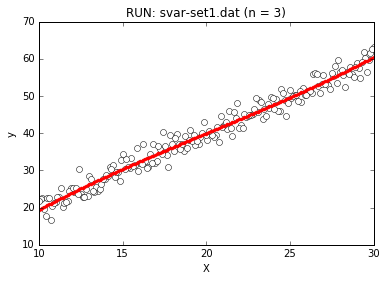

SKLEARN_CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=2.0572416	train_rse_avg=0.0017810	
	test_J_avg=2.2385920	test_rse_avg=0.0020115
RUN: svar-set1.dat (n = 4)
applied to all data (n = 4):
	J=2.0659213	rse=0.0017927
running time: 0.00763082504272


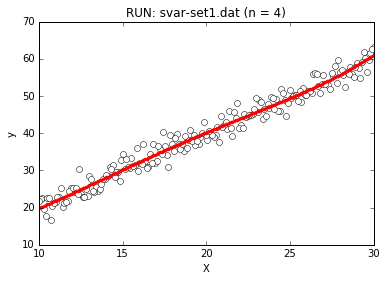

SKLEARN_CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=2.0522475	train_rse_avg=0.0017667	
	test_J_avg=2.2778388	test_rse_avg=0.0020410
RUN: svar-set1.dat (n = 5)
applied to all data (n = 5):
	J=2.0629368	rse=0.0017803
running time: 0.00922989845276


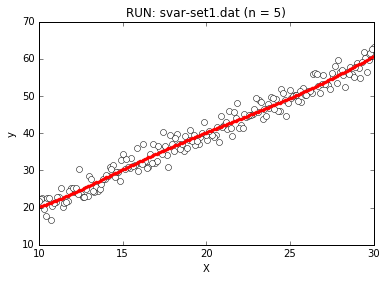

SKLEARN_CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=2.0040397	train_rse_avg=0.0017224	
	test_J_avg=2.2307314	test_rse_avg=0.0019871
RUN: svar-set1.dat (n = 6)
applied to all data (n = 6):
	J=2.0147714	rse=0.0017359
running time: 0.00607991218567


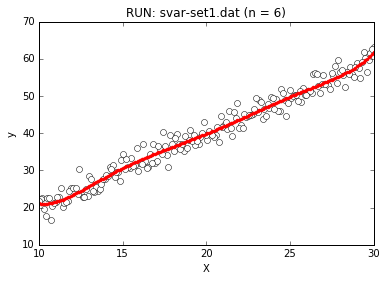

SKLEARN_CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=2.0013186	train_rse_avg=0.0017236	
	test_J_avg=2.2574889	test_rse_avg=0.0020133
RUN: svar-set1.dat (n = 7)
applied to all data (n = 7):
	J=2.0134392	rse=0.0017382
running time: 0.0066192150116


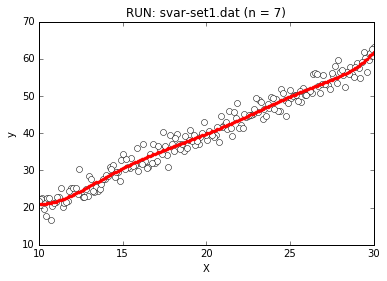

SKLEARN_CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=1.9961091	train_rse_avg=0.0017141	
	test_J_avg=2.2887515	test_rse_avg=0.0020391
RUN: svar-set1.dat (n = 8)
applied to all data (n = 8):
	J=2.0097337	rse=0.0017296
running time: 0.00667309761047


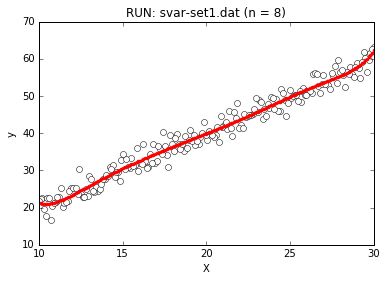

SKLEARN_CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=1.9928741	train_rse_avg=0.0017167	
	test_J_avg=2.2864944	test_rse_avg=0.0020354
RUN: svar-set1.dat (n = 9)
applied to all data (n = 9):
	J=2.0066390	rse=0.0017327
running time: 0.00777387619019


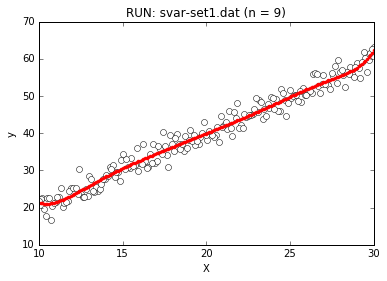

SKLEARN_CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=1.9871606	train_rse_avg=0.0017180	
	test_J_avg=2.2769751	test_rse_avg=0.0020245
RUN: svar-set1.dat (n = 10)
applied to all data (n = 10):
	J=2.0009368	rse=0.0017330
running time: 0.00829696655273


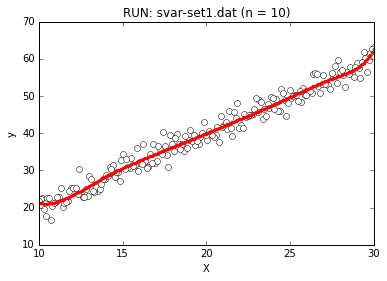

SKLEARN_CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=1.9791025	train_rse_avg=0.0017183	
	test_J_avg=2.2652084	test_rse_avg=0.0020154
RUN: svar-set1.dat (n = 11)
applied to all data (n = 11):
	J=1.9927778	rse=0.0017332
running time: 0.00824904441833


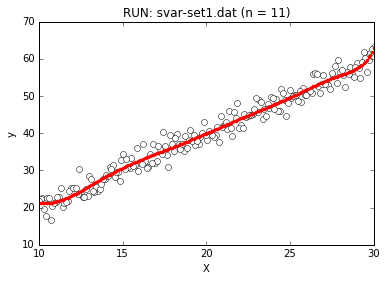

SKLEARN_CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=1.9978999	train_rse_avg=0.0017384	
	test_J_avg=2.2785616	test_rse_avg=0.0020340
RUN: svar-set1.dat (n = 12)
applied to all data (n = 12):
	J=1.9841856	rse=0.0017323
running time: 0.00744104385376


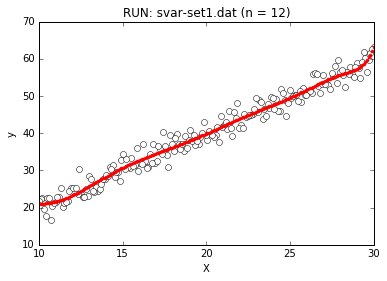

SKLEARN_CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=2.0013293	train_rse_avg=0.0017473	
	test_J_avg=2.2946209	test_rse_avg=0.0020530
RUN: svar-set1.dat (n = 13)
applied to all data (n = 13):
	J=2.0152121	rse=0.0017622
running time: 0.00850200653076


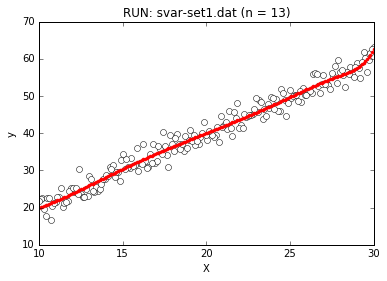

SKLEARN_CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=1.9863497	train_rse_avg=0.0017377	
	test_J_avg=2.2734138	test_rse_avg=0.0020226
RUN: svar-set1.dat (n = 14)
applied to all data (n = 14):
	J=2.0000023	rse=0.0017518
running time: 0.00801491737366


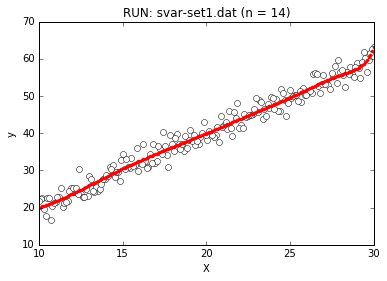

SKLEARN_CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=1.9710186	train_rse_avg=0.0017250	
	test_J_avg=2.2480250	test_rse_avg=0.0019788
RUN: svar-set1.dat (n = 15)
applied to all data (n = 15):
	J=1.9842240	rse=0.0017379
running time: 0.0108599662781


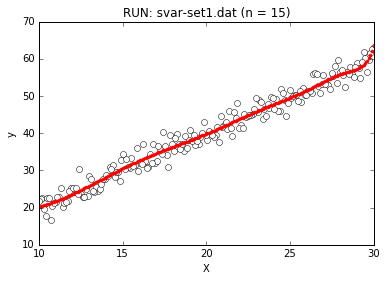

SKLEARN_CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=1.9706862	train_rse_avg=0.0017275	
	test_J_avg=2.2418121	test_rse_avg=0.0019489
RUN: svar-set1.dat (n = 16)
applied to all data (n = 16):
	J=1.9835461	rse=0.0017391
running time: 0.0123071670532


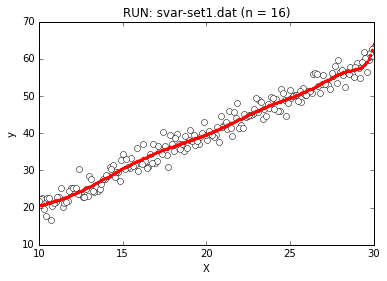

SKLEARN_CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=2.0059733	train_rse_avg=0.0017741	
	test_J_avg=2.2818794	test_rse_avg=0.0019700
RUN: svar-set1.dat (n = 17)
applied to all data (n = 17):
	J=2.0188528	rse=0.0017849
running time: 0.0108098983765


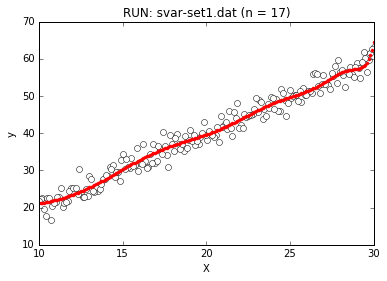

SKLEARN_CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=2.0967703	train_rse_avg=0.0018972	
	test_J_avg=2.3891164	test_rse_avg=0.0020780
RUN: svar-set1.dat (n = 18)
applied to all data (n = 18):
	J=2.1101050	rse=0.0019077
running time: 0.00905513763428


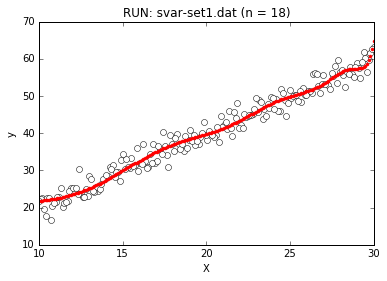

SKLEARN_CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=2.2563858	train_rse_avg=0.0021220	
	test_J_avg=2.5744610	test_rse_avg=0.0022982
RUN: svar-set1.dat (n = 19)
applied to all data (n = 19):
	J=2.2705103	rse=0.0021329
running time: 0.00980091094971


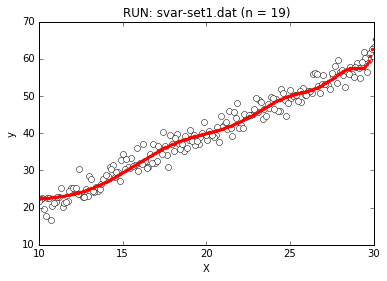

SKLEARN_CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=2.4886500	train_rse_avg=0.0024604	
	test_J_avg=2.8371780	test_rse_avg=0.0026399
RUN: svar-set1.dat (n = 20)
applied to all data (n = 20):
	J=2.5037388	rse=0.0024719
running time: 0.0112428665161


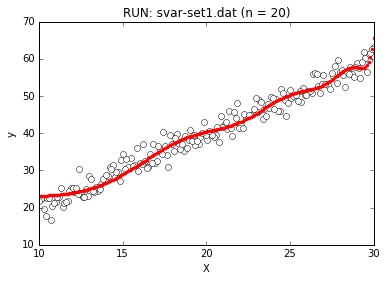

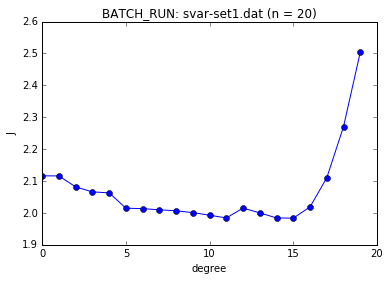

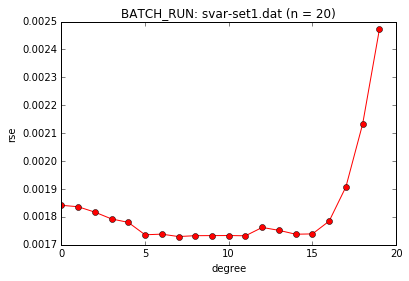

BATCH_RUN: svar-set1.dat (n = 20)
J_min = 1.9835461	n = 16
rse_min = 0.0017296	n = 8
running time: [0.006981849670410156, 0.005312919616699219, 0.005567073822021484, 0.007630825042724609, 0.009229898452758789, 0.006079912185668945, 0.00661921501159668, 0.006673097610473633, 0.007773876190185547, 0.008296966552734375, 0.008249044418334961, 0.007441043853759766, 0.008502006530761719, 0.008014917373657227, 0.010859966278076172, 0.012307167053222656, 0.010809898376464844, 0.009055137634277344, 0.009800910949707031, 0.011242866516113281] 


SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.0297436	train_rse_avg=50.1718258	
	test_J_avg=0.0306003	test_rse_avg=53.9032082
RUN: svar-set2.dat (n = 1)
applied to all data (n = 1):
	J=0.0297863	rse=50.3872921
running time: 0.00511598587036


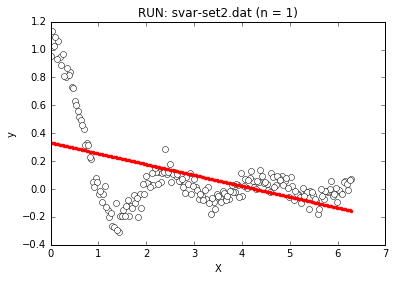

SKLEARN_CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.0193021	train_rse_avg=24.0622446	
	test_J_avg=0.0200540	test_rse_avg=24.5885930
RUN: svar-set2.dat (n = 2)
applied to all data (n = 2):
	J=0.0193392	rse=23.8525883
running time: 0.00594305992126


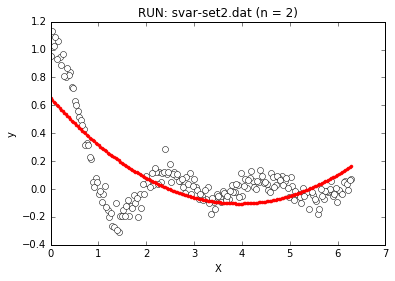

SKLEARN_CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.0101460	train_rse_avg=11.2089839	
	test_J_avg=0.0106852	test_rse_avg=11.5615509
RUN: svar-set2.dat (n = 3)
applied to all data (n = 3):
	J=0.0101726	rse=11.0875431
running time: 0.00569009780884


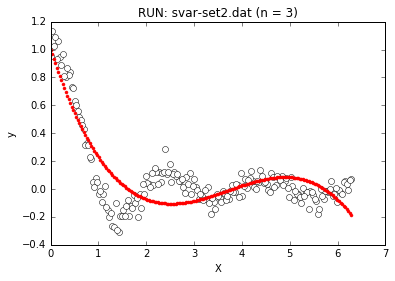

SKLEARN_CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.0057312	train_rse_avg=11.0998927	
	test_J_avg=0.0060999	test_rse_avg=11.0520243
RUN: svar-set2.dat (n = 4)
applied to all data (n = 4):
	J=0.0057495	rse=11.0441311
running time: 0.00574803352356


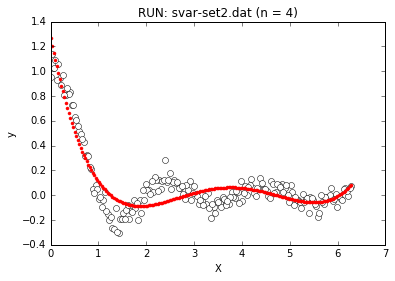

SKLEARN_CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.0055212	train_rse_avg=3.7795150	
	test_J_avg=0.0059530	test_rse_avg=3.2990571
RUN: svar-set2.dat (n = 5)
applied to all data (n = 5):
	J=0.0055424	rse=3.6574201
running time: 0.00592517852783


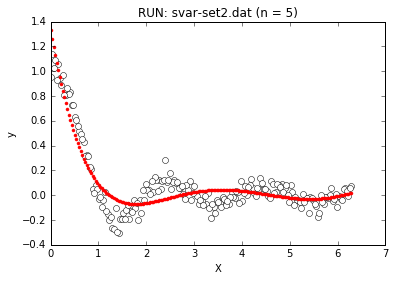

SKLEARN_CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.0054273	train_rse_avg=2.3365573	
	test_J_avg=0.0059405	test_rse_avg=2.0755368
RUN: svar-set2.dat (n = 6)
applied to all data (n = 6):
	J=0.0054522	rse=2.1442261
running time: 0.00625801086426


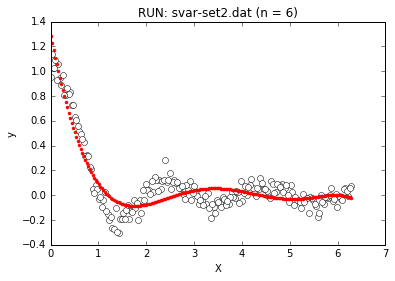

SKLEARN_CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.0029174	train_rse_avg=27.0807031	
	test_J_avg=0.0032639	test_rse_avg=27.3328801
RUN: svar-set2.dat (n = 7)
applied to all data (n = 7):
	J=0.0029339	rse=26.6634246
running time: 0.00854992866516


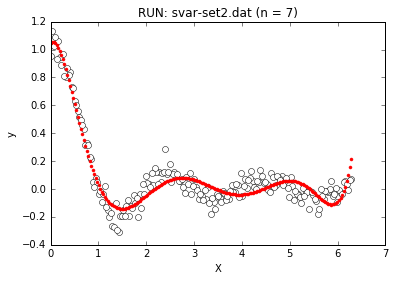

SKLEARN_CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.0019057	train_rse_avg=15.1568526	
	test_J_avg=0.0021477	test_rse_avg=15.8754743
RUN: svar-set2.dat (n = 8)
applied to all data (n = 8):
	J=0.0019174	rse=15.1082472
running time: 0.00658988952637


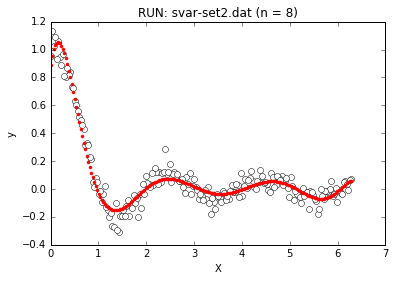

SKLEARN_CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.0016301	train_rse_avg=21.7497818	
	test_J_avg=0.0018614	test_rse_avg=23.0802011
RUN: svar-set2.dat (n = 9)
applied to all data (n = 9):
	J=0.0016409	rse=21.8854921
running time: 0.00926303863525


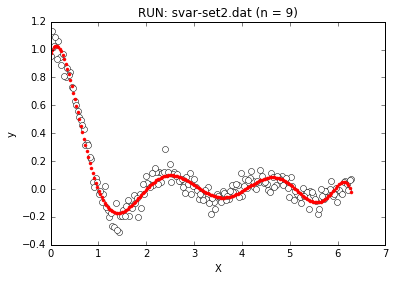

SKLEARN_CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0012749	train_rse_avg=10.8076909	
	test_J_avg=0.0015251	test_rse_avg=11.5829448
RUN: svar-set2.dat (n = 10)
applied to all data (n = 10):
	J=0.0012859	rse=10.8319294
running time: 0.0101270675659


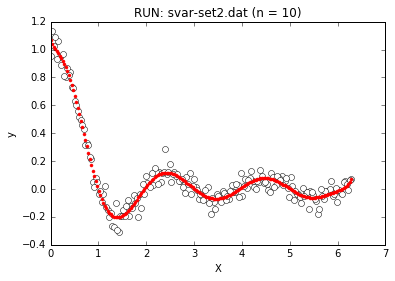

SKLEARN_CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0012735	train_rse_avg=10.5108998	
	test_J_avg=0.0015428	test_rse_avg=11.3109358
RUN: svar-set2.dat (n = 11)
applied to all data (n = 11):
	J=0.0012852	rse=10.4715039
running time: 0.00751399993896


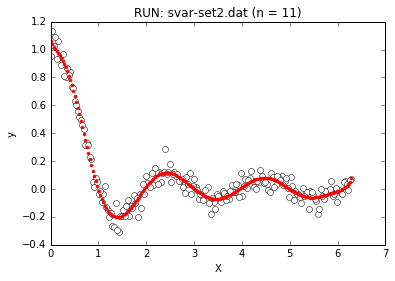

SKLEARN_CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0012557	train_rse_avg=12.0873428	
	test_J_avg=0.0015474	test_rse_avg=13.7053944
RUN: svar-set2.dat (n = 12)
applied to all data (n = 12):
	J=0.0012681	rse=12.1111291
running time: 0.00794386863708


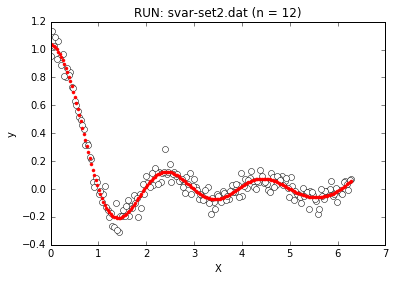

SKLEARN_CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0012424	train_rse_avg=11.3737899	
	test_J_avg=0.0015364	test_rse_avg=12.8081548
RUN: svar-set2.dat (n = 13)
applied to all data (n = 13):
	J=0.0012548	rse=11.3694123
running time: 0.00985097885132


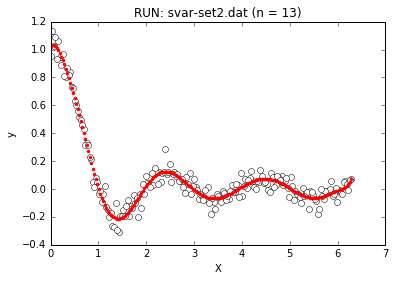

SKLEARN_CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0012398	train_rse_avg=11.6123088	
	test_J_avg=0.0016013	test_rse_avg=12.7878923
RUN: svar-set2.dat (n = 14)
applied to all data (n = 14):
	J=0.0012537	rse=11.5425916
running time: 0.00824213027954


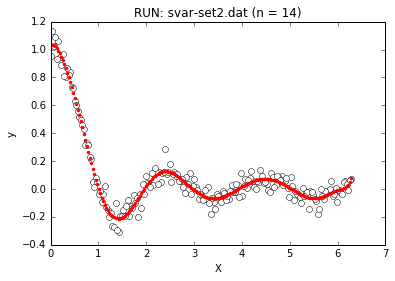

SKLEARN_CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0012405	train_rse_avg=12.0237676	
	test_J_avg=0.0015570	test_rse_avg=13.2543220
RUN: svar-set2.dat (n = 15)
applied to all data (n = 15):
	J=0.0012538	rse=11.9563550
running time: 0.00846314430237


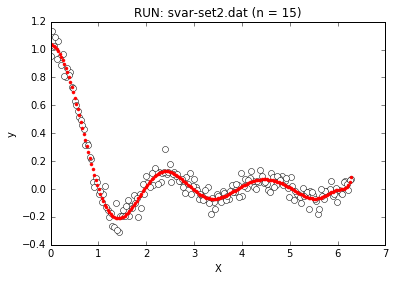

SKLEARN_CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0012417	train_rse_avg=12.1302987	
	test_J_avg=0.0015155	test_rse_avg=13.3903679
RUN: svar-set2.dat (n = 16)
applied to all data (n = 16):
	J=0.0012538	rse=12.0829321
running time: 0.00916409492493


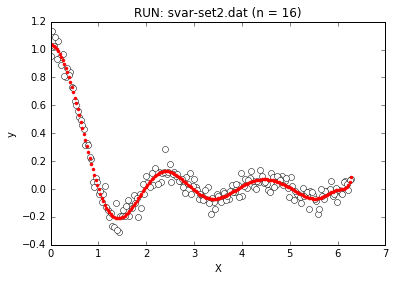

SKLEARN_CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.0012426	train_rse_avg=11.6671248	
	test_J_avg=0.0014814	test_rse_avg=12.7388764
RUN: svar-set2.dat (n = 17)
applied to all data (n = 17):
	J=0.0012535	rse=11.6484019
running time: 0.0111129283905


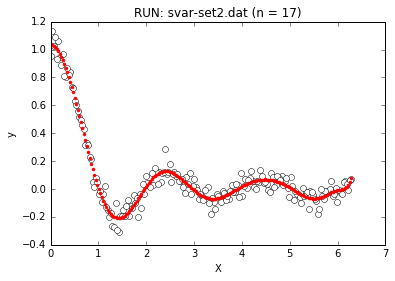

SKLEARN_CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.0012722	train_rse_avg=12.1683548	
	test_J_avg=0.0014932	test_rse_avg=13.4284537
RUN: svar-set2.dat (n = 18)
applied to all data (n = 18):
	J=0.0012824	rse=12.3219418
running time: 0.0105538368225


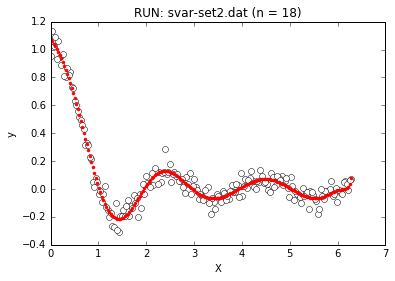

SKLEARN_CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.0015199	train_rse_avg=15.2257425	
	test_J_avg=0.0017165	test_rse_avg=23.1498155
RUN: svar-set2.dat (n = 19)
applied to all data (n = 19):
	J=0.0014634	rse=11.1905676
running time: 0.0123591423035


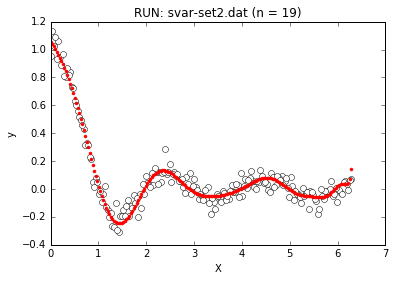

SKLEARN_CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.0142582	train_rse_avg=24.4304847	
	test_J_avg=0.0172248	test_rse_avg=25.2864638
RUN: svar-set2.dat (n = 20)
applied to all data (n = 20):
	J=0.0156271	rse=24.9487699
running time: 0.0137948989868


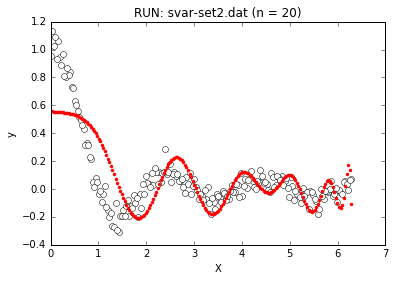

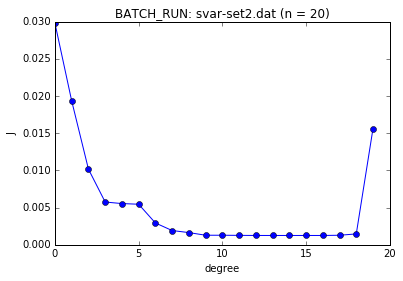

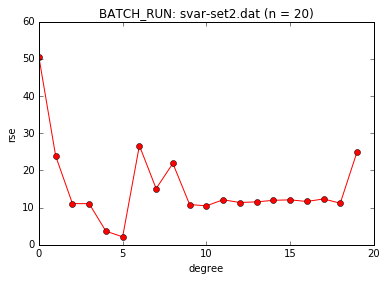

BATCH_RUN: svar-set2.dat (n = 20)
J_min = 0.0012535	n = 17
rse_min = 2.1442261	n = 6
running time: [0.005115985870361328, 0.0059430599212646484, 0.005690097808837891, 0.00574803352355957, 0.005925178527832031, 0.0062580108642578125, 0.008549928665161133, 0.0065898895263671875, 0.009263038635253906, 0.010127067565917969, 0.007513999938964844, 0.007943868637084961, 0.00985097885131836, 0.008242130279541016, 0.008463144302368164, 0.009164094924926758, 0.01111292839050293, 0.010553836822509766, 0.012359142303466797, 0.013794898986816406] 


SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.2492086	train_rse_avg=48.7588106	
	test_J_avg=0.2521696	test_rse_avg=50.0269966
RUN: svar-set3.dat (n = 1)
applied to all data (n = 1):
	J=0.2493569	rse=48.7861839
running time: 0.00567007064819


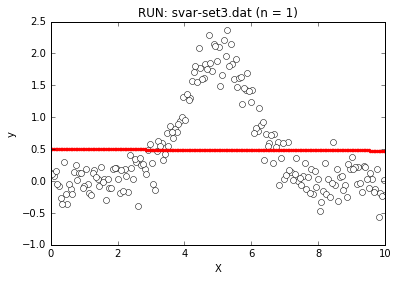

SKLEARN_CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.1264482	train_rse_avg=57.7192058	
	test_J_avg=0.1302928	test_rse_avg=61.5825284
RUN: svar-set3.dat (n = 2)
applied to all data (n = 2):
	J=0.1266392	rse=57.9834839
running time: 0.00532913208008


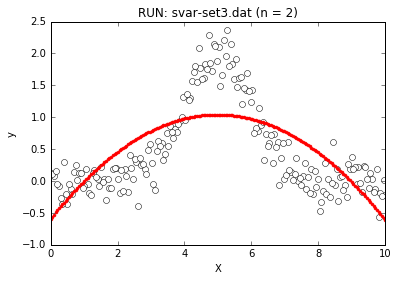

SKLEARN_CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.1264048	train_rse_avg=57.4214001	
	test_J_avg=0.1310914	test_rse_avg=61.5703116
RUN: svar-set3.dat (n = 3)
applied to all data (n = 3):
	J=0.1266376	rse=57.5942205
running time: 0.00798606872559


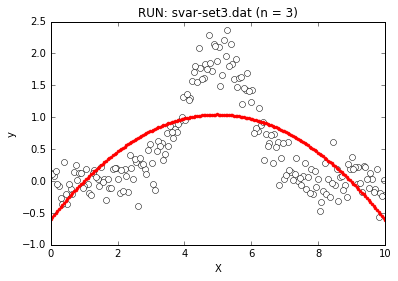

SKLEARN_CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.0631845	train_rse_avg=22.6065735	
	test_J_avg=0.0666902	test_rse_avg=26.1412643
RUN: svar-set3.dat (n = 4)
applied to all data (n = 4):
	J=0.0633565	rse=22.7893430
running time: 0.00570201873779


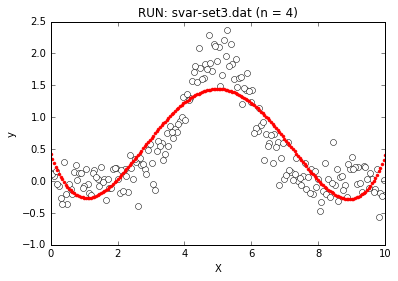

SKLEARN_CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.0629907	train_rse_avg=21.4360121	
	test_J_avg=0.0669447	test_rse_avg=24.4782641
RUN: svar-set3.dat (n = 5)
applied to all data (n = 5):
	J=0.0631844	rse=21.5313993
running time: 0.00588607788086


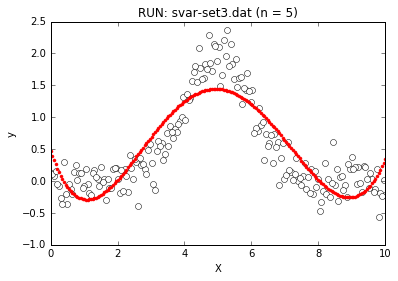

SKLEARN_CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.0314088	train_rse_avg=7.7587742	
	test_J_avg=0.0349307	test_rse_avg=11.2924854
RUN: svar-set3.dat (n = 6)
applied to all data (n = 6):
	J=0.0315778	rse=7.8991745
running time: 0.0062301158905


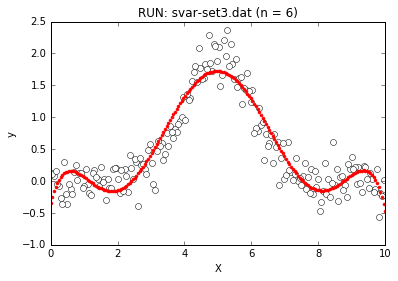

SKLEARN_CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.0307885	train_rse_avg=9.6856453	
	test_J_avg=0.0346770	test_rse_avg=15.4272472
RUN: svar-set3.dat (n = 7)
applied to all data (n = 7):
	J=0.0309723	rse=9.8969299
running time: 0.00886011123657


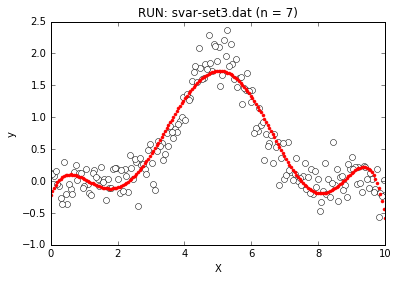

SKLEARN_CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.0218922	train_rse_avg=1.8113212	
	test_J_avg=0.0242217	test_rse_avg=2.3370329
RUN: svar-set3.dat (n = 8)
applied to all data (n = 8):
	J=0.0220054	rse=1.8246027
running time: 0.00669503211975


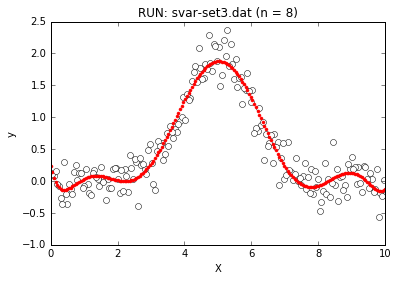

SKLEARN_CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.0218667	train_rse_avg=1.9034509	
	test_J_avg=0.0245127	test_rse_avg=2.4451061
RUN: svar-set3.dat (n = 9)
applied to all data (n = 9):
	J=0.0219938	rse=1.9217610
running time: 0.00676703453064


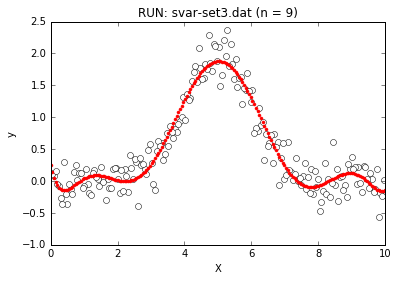

SKLEARN_CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0208017	train_rse_avg=2.8494497	
	test_J_avg=0.0234069	test_rse_avg=4.2291181
RUN: svar-set3.dat (n = 10)
applied to all data (n = 10):
	J=0.0209283	rse=2.8771330
running time: 0.006991147995


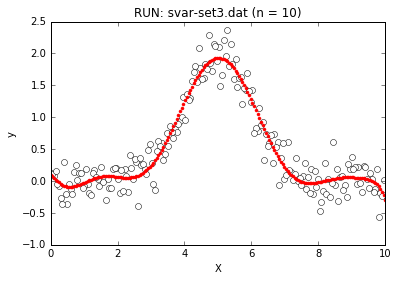

SKLEARN_CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0207765	train_rse_avg=2.7955946	
	test_J_avg=0.0235450	test_rse_avg=4.4530712
RUN: svar-set3.dat (n = 11)
applied to all data (n = 11):
	J=0.0209110	rse=2.8444068
running time: 0.00763702392578


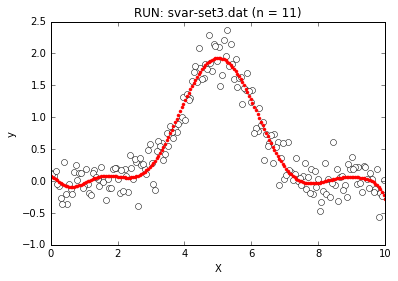

SKLEARN_CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0192600	train_rse_avg=2.6047823	
	test_J_avg=0.0220510	test_rse_avg=3.9987400
RUN: svar-set3.dat (n = 12)
applied to all data (n = 12):
	J=0.0193919	rse=2.6866938
running time: 0.00759410858154


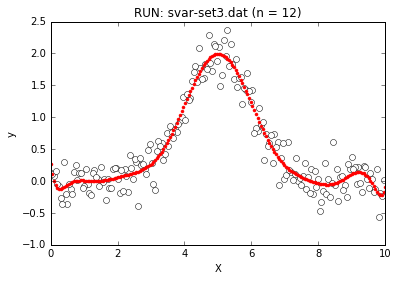

SKLEARN_CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0192433	train_rse_avg=2.5957297	
	test_J_avg=0.0223544	test_rse_avg=3.9501713
RUN: svar-set3.dat (n = 13)
applied to all data (n = 13):
	J=0.0193883	rse=2.6887479
running time: 0.00902986526489


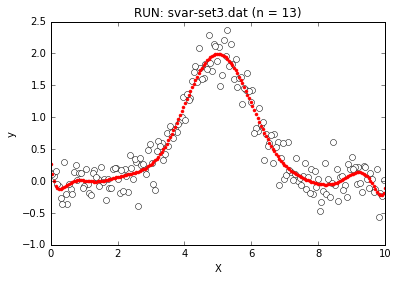

SKLEARN_CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0196686	train_rse_avg=2.6363622	
	test_J_avg=0.0225216	test_rse_avg=4.0893600
RUN: svar-set3.dat (n = 14)
applied to all data (n = 14):
	J=0.0198041	rse=2.7333574
running time: 0.0090000629425


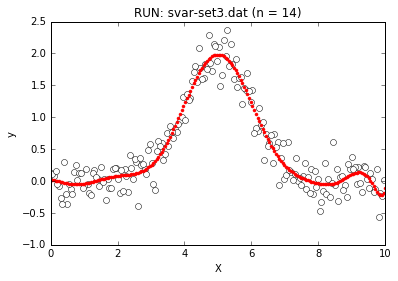

SKLEARN_CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0195029	train_rse_avg=2.7596200	
	test_J_avg=0.0223038	test_rse_avg=4.0200754
RUN: svar-set3.dat (n = 15)
applied to all data (n = 15):
	J=0.0196343	rse=2.8629788
running time: 0.0087308883667


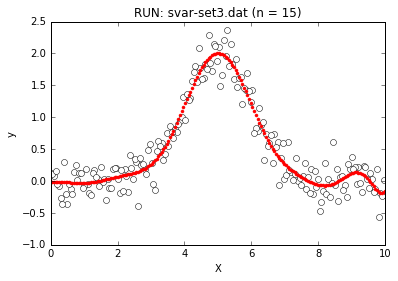

SKLEARN_CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0195119	train_rse_avg=2.8833593	
	test_J_avg=0.0222009	test_rse_avg=3.7462237
RUN: svar-set3.dat (n = 16)
applied to all data (n = 16):
	J=0.0196416	rse=2.9532081
running time: 0.0105559825897


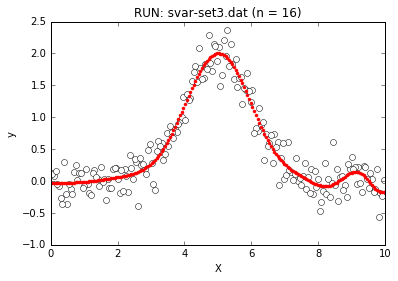

SKLEARN_CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.0196772	train_rse_avg=2.8872936	
	test_J_avg=0.0222369	test_rse_avg=3.5638095
RUN: svar-set3.dat (n = 17)
applied to all data (n = 17):
	J=0.0198019	rse=2.9299420
running time: 0.0103211402893


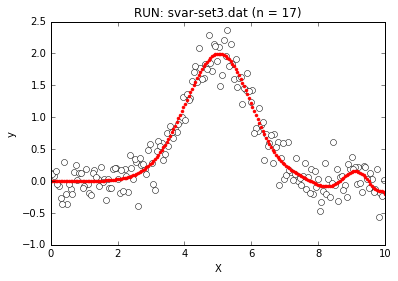

SKLEARN_CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.0197367	train_rse_avg=2.7215274	
	test_J_avg=0.0224832	test_rse_avg=3.5613351
RUN: svar-set3.dat (n = 18)
applied to all data (n = 18):
	J=0.0198688	rse=2.7837748
running time: 0.00904202461243


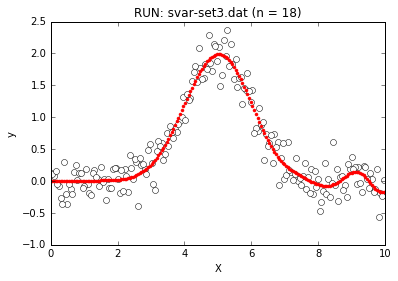

SKLEARN_CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.0196917	train_rse_avg=2.7226300	
	test_J_avg=0.0222270	test_rse_avg=3.7724614
RUN: svar-set3.dat (n = 19)
applied to all data (n = 19):
	J=0.0198122	rse=2.8066658
running time: 0.0102989673615


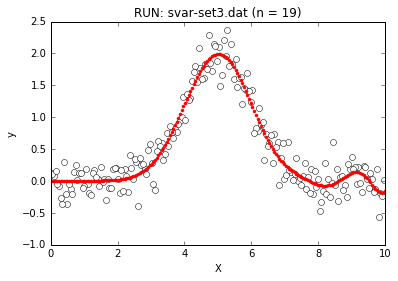

SKLEARN_CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.0197241	train_rse_avg=3.2025956	
	test_J_avg=0.0227795	test_rse_avg=5.3014939
RUN: svar-set3.dat (n = 20)
applied to all data (n = 20):
	J=0.0198550	rse=3.3858174
running time: 0.00931596755981


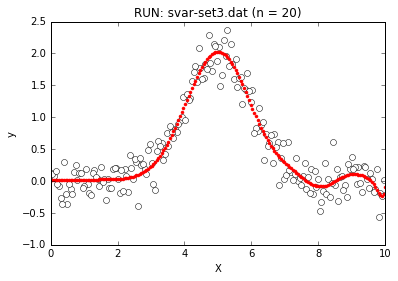

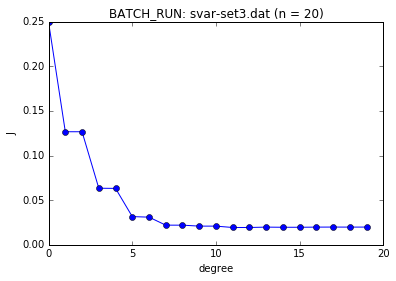

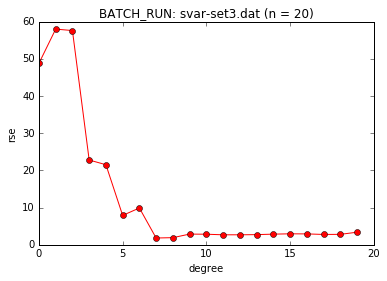

BATCH_RUN: svar-set3.dat (n = 20)
J_min = 0.0193883	n = 13
rse_min = 1.8246027	n = 8
running time: [0.005670070648193359, 0.005329132080078125, 0.007986068725585938, 0.005702018737792969, 0.005886077880859375, 0.00623011589050293, 0.008860111236572266, 0.0066950321197509766, 0.0067670345306396484, 0.006991147994995117, 0.00763702392578125, 0.007594108581542969, 0.009029865264892578, 0.009000062942504883, 0.008730888366699219, 0.01055598258972168, 0.01032114028930664, 0.009042024612426758, 0.010298967361450195, 0.009315967559814453] 


SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.6001013	train_rse_avg=859.7622905	
	test_J_avg=0.6061435	test_rse_avg=822.2437717
RUN: svar-set4.dat (n = 1)
applied to all data (n = 1):
	J=0.6004040	rse=855.0362917
running time: 0.00507497787476


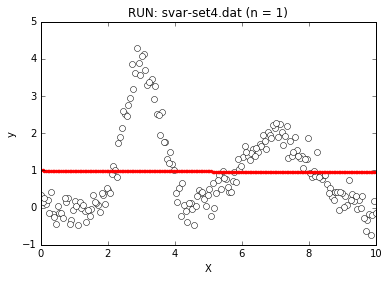

SKLEARN_CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.4639214	train_rse_avg=2087.6439714	
	test_J_avg=0.4704152	test_rse_avg=2023.4044681
RUN: svar-set4.dat (n = 2)
applied to all data (n = 2):
	J=0.4642465	rse=2079.5649952
running time: 0.00529599189758


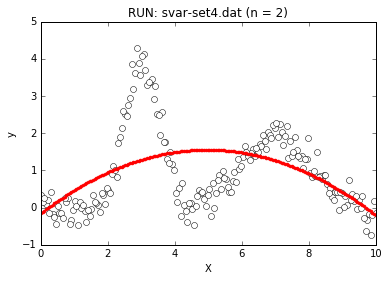

SKLEARN_CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.4590720	train_rse_avg=2052.8461536	
	test_J_avg=0.4691017	test_rse_avg=1996.3140163
RUN: svar-set4.dat (n = 3)
applied to all data (n = 3):
	J=0.4595738	rse=2046.5999411
running time: 0.00575089454651


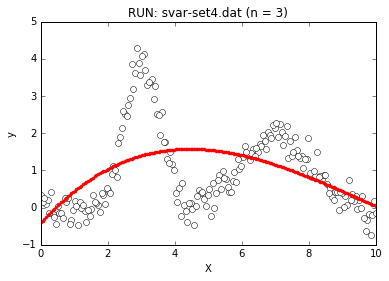

SKLEARN_CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.4242886	train_rse_avg=1361.7278136	
	test_J_avg=0.4382153	test_rse_avg=1353.8536967
RUN: svar-set4.dat (n = 4)
applied to all data (n = 4):
	J=0.4249857	rse=1360.7441152
running time: 0.0059380531311


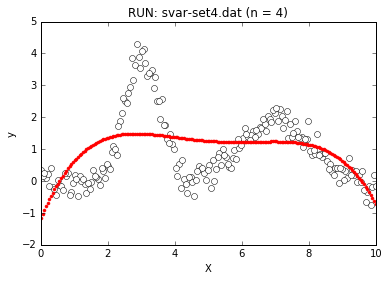

SKLEARN_CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.4010205	train_rse_avg=1258.8423453	
	test_J_avg=0.4201535	test_rse_avg=1225.0055502
RUN: svar-set4.dat (n = 5)
applied to all data (n = 5):
	J=0.4019738	rse=1257.1636155
running time: 0.00830292701721


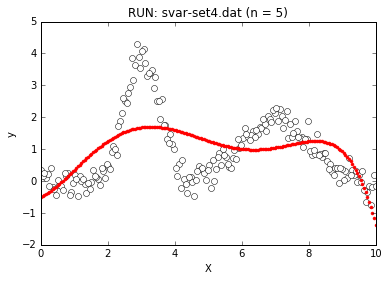

SKLEARN_CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.2248908	train_rse_avg=267.6026144	
	test_J_avg=0.2390450	test_rse_avg=281.3145123
RUN: svar-set4.dat (n = 6)
applied to all data (n = 6):
	J=0.2255884	rse=269.4587895
running time: 0.00628805160522


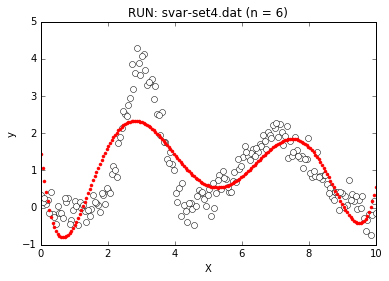

SKLEARN_CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.2244760	train_rse_avg=272.3100081	
	test_J_avg=0.2439608	test_rse_avg=277.4401133
RUN: svar-set4.dat (n = 7)
applied to all data (n = 7):
	J=0.2254291	rse=274.2486226
running time: 0.00830698013306


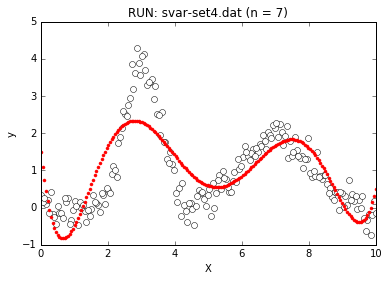

SKLEARN_CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.1230222	train_rse_avg=12.5071640	
	test_J_avg=0.1360910	test_rse_avg=15.3475658
RUN: svar-set4.dat (n = 8)
applied to all data (n = 8):
	J=0.1236514	rse=12.4624805
running time: 0.00834894180298


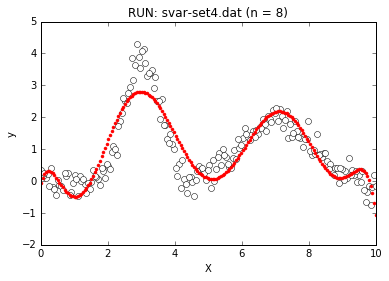

SKLEARN_CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.1042002	train_rse_avg=27.7654106	
	test_J_avg=0.1185357	test_rse_avg=35.6803239
RUN: svar-set4.dat (n = 9)
applied to all data (n = 9):
	J=0.1048585	rse=28.6144896
running time: 0.00897097587585


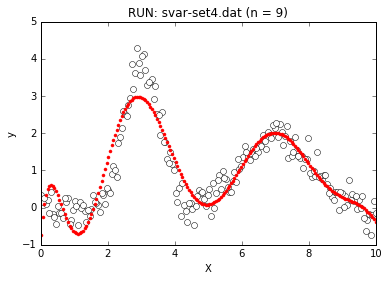

SKLEARN_CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0891618	train_rse_avg=9.2311780	
	test_J_avg=0.0996096	test_rse_avg=9.0893129
RUN: svar-set4.dat (n = 10)
applied to all data (n = 10):
	J=0.0896451	rse=8.7697209
running time: 0.00744414329529


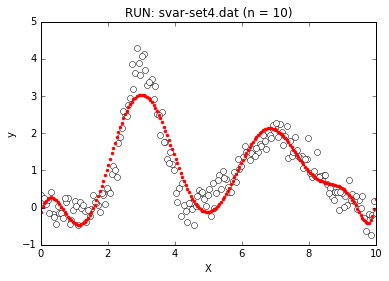

SKLEARN_CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0641564	train_rse_avg=5.7586696	
	test_J_avg=0.0738994	test_rse_avg=12.0103172
RUN: svar-set4.dat (n = 11)
applied to all data (n = 11):
	J=0.0646073	rse=5.6416205
running time: 0.00956916809082


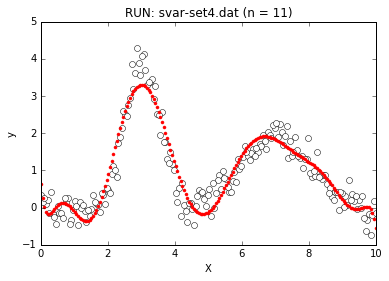

SKLEARN_CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0584577	train_rse_avg=26.6086315	
	test_J_avg=0.0706199	test_rse_avg=35.7827188
RUN: svar-set4.dat (n = 12)
applied to all data (n = 12):
	J=0.0589895	rse=26.4438500
running time: 0.00770711898804


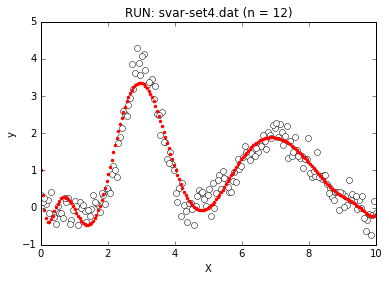

SKLEARN_CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0467990	train_rse_avg=50.2351186	
	test_J_avg=0.0564976	test_rse_avg=79.7158669
RUN: svar-set4.dat (n = 13)
applied to all data (n = 13):
	J=0.0472079	rse=50.9352014
running time: 0.0106289386749


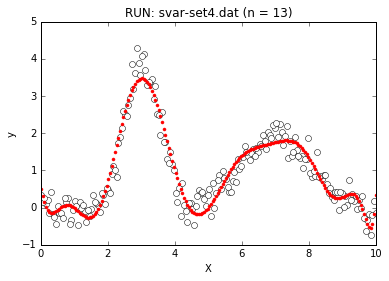

SKLEARN_CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0569515	train_rse_avg=27.1021445	
	test_J_avg=0.0693197	test_rse_avg=45.1339466
RUN: svar-set4.dat (n = 14)
applied to all data (n = 14):
	J=0.0574586	rse=27.3043828
running time: 0.0106270313263


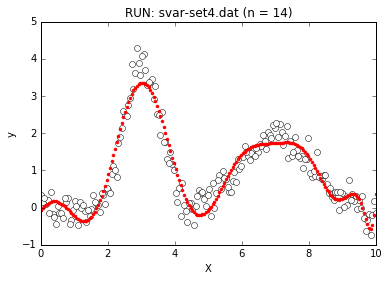

SKLEARN_CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0514250	train_rse_avg=62.2334860	
	test_J_avg=0.0592280	test_rse_avg=70.0361224
RUN: svar-set4.dat (n = 15)
applied to all data (n = 15):
	J=0.0525567	rse=70.8169152
running time: 0.0179619789124


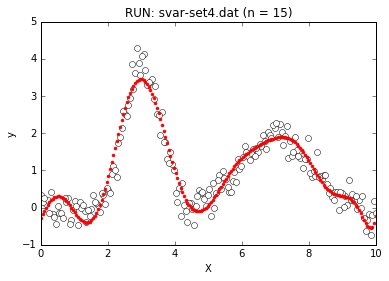

SKLEARN_CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0516636	train_rse_avg=76.7248246	
	test_J_avg=0.0594211	test_rse_avg=107.4933455
RUN: svar-set4.dat (n = 16)
applied to all data (n = 16):
	J=0.0513043	rse=67.6340368
running time: 0.0118060112


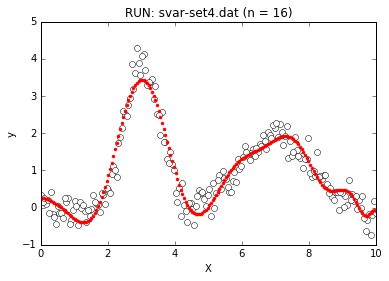

SKLEARN_CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.0714866	train_rse_avg=33.2339111	
	test_J_avg=0.0786990	test_rse_avg=43.9518477
RUN: svar-set4.dat (n = 17)
applied to all data (n = 17):
	J=0.0718783	rse=33.9802938
running time: 0.00898480415344


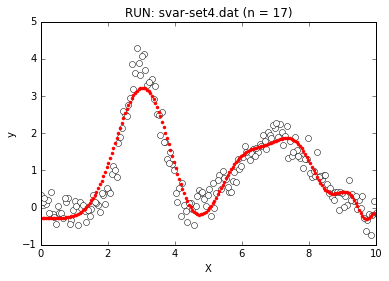

SKLEARN_CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.0984414	train_rse_avg=5.7905049	
	test_J_avg=0.1122284	test_rse_avg=12.5634444
RUN: svar-set4.dat (n = 18)
applied to all data (n = 18):
	J=0.0990040	rse=4.9942140
running time: 0.0123500823975


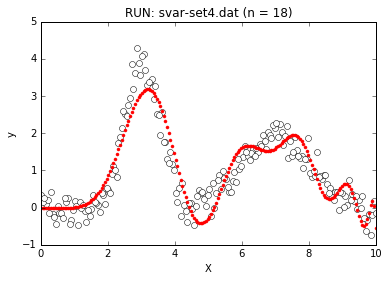

SKLEARN_CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.4109606	train_rse_avg=37.7764397	
	test_J_avg=0.4533483	test_rse_avg=39.7086663
RUN: svar-set4.dat (n = 19)
applied to all data (n = 19):
	J=0.4123379	rse=37.1869568
running time: 0.00949716567993


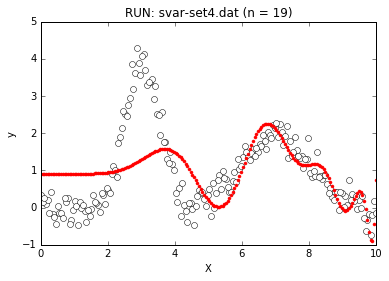

SKLEARN_CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.4495631	train_rse_avg=112.1847824	
	test_J_avg=0.4812252	test_rse_avg=109.2539113
RUN: svar-set4.dat (n = 20)
applied to all data (n = 20):
	J=0.4505865	rse=113.2108573
running time: 0.00936102867126


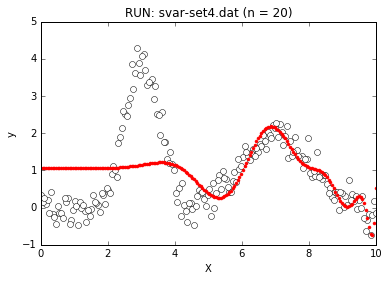

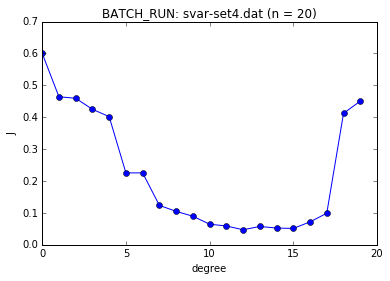

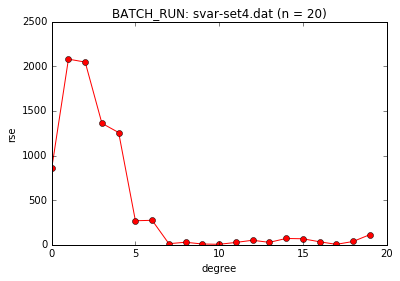

BATCH_RUN: svar-set4.dat (n = 20)
J_min = 0.0472079	n = 13
rse_min = 4.9942140	n = 18
running time: [0.005074977874755859, 0.005295991897583008, 0.005750894546508789, 0.005938053131103516, 0.008302927017211914, 0.006288051605224609, 0.00830698013305664, 0.008348941802978516, 0.008970975875854492, 0.007444143295288086, 0.009569168090820312, 0.007707118988037109, 0.010628938674926758, 0.010627031326293945, 0.017961978912353516, 0.011806011199951172, 0.008984804153442383, 0.012350082397460938, 0.00949716567993164, 0.009361028671264648] 




In [130]:
# run all datasets, fit sklearn linear regression model with degree from 1 to 20
# plot all results and graphs
batch_run(s_fnames, 'sklearn', 20, \
          r_verbose=True, pl_verbose=True, bpl_verbose=True)

#### (e) Reduce the amount of training data you use and observe the effect of performance of the linear and polynomial models

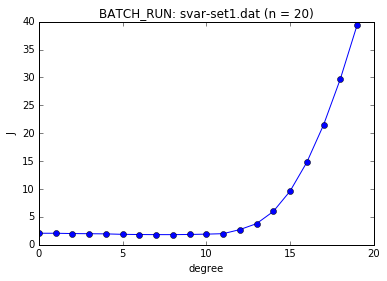

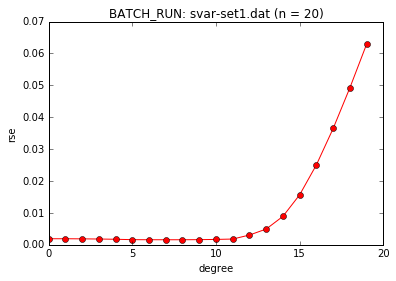

BATCH_RUN: svar-set1.dat (n = 20)
J_min = 1.8214318	n = 9
rse_min = 0.0015829	n = 8
running time: [0.002919912338256836, 0.002504110336303711, 0.0028429031372070312, 0.0021719932556152344, 0.0023229122161865234, 0.002871990203857422, 0.00255584716796875, 0.002732992172241211, 0.0028541088104248047, 0.0036079883575439453, 0.0033121109008789062, 0.005449056625366211, 0.006165027618408203, 0.005202054977416992, 0.0073168277740478516, 0.0052700042724609375, 0.005831003189086914, 0.0048980712890625, 0.005158901214599609, 0.0051000118255615234] 




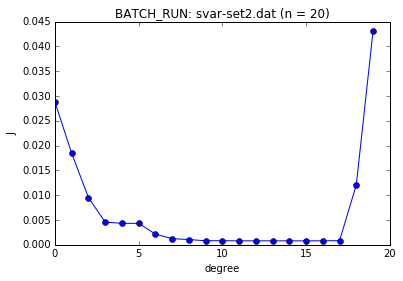

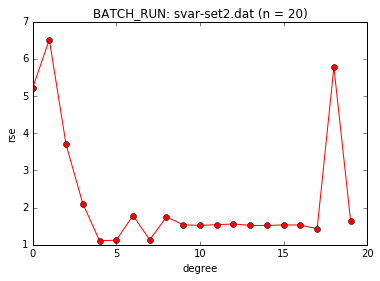

BATCH_RUN: svar-set2.dat (n = 20)
J_min = 0.0007938	n = 14
rse_min = 1.1099932	n = 5
running time: [0.002048015594482422, 0.0018019676208496094, 0.003011941909790039, 0.0033130645751953125, 0.002295970916748047, 0.0024628639221191406, 0.003259897232055664, 0.0027511119842529297, 0.0029249191284179688, 0.0032150745391845703, 0.0035181045532226562, 0.006887912750244141, 0.0065882205963134766, 0.006818056106567383, 0.00705409049987793, 0.005900144577026367, 0.005527973175048828, 0.0049211978912353516, 0.005096912384033203, 0.005411863327026367] 




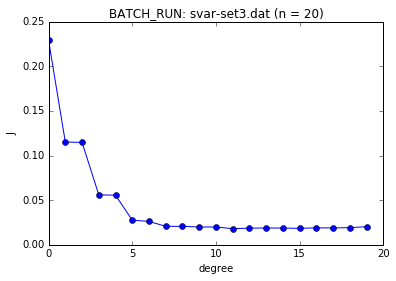

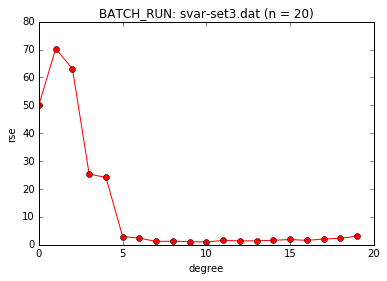

BATCH_RUN: svar-set3.dat (n = 20)
J_min = 0.0180816	n = 12
rse_min = 1.0274905	n = 11
running time: [0.001708984375, 0.002574920654296875, 0.0034151077270507812, 0.0029189586639404297, 0.0024750232696533203, 0.0026891231536865234, 0.0028429031372070312, 0.0039598941802978516, 0.003016948699951172, 0.003268003463745117, 0.0036780834197998047, 0.003840923309326172, 0.005362987518310547, 0.004517078399658203, 0.0044209957122802734, 0.00450897216796875, 0.004701137542724609, 0.0048639774322509766, 0.005013942718505859, 0.0051729679107666016] 




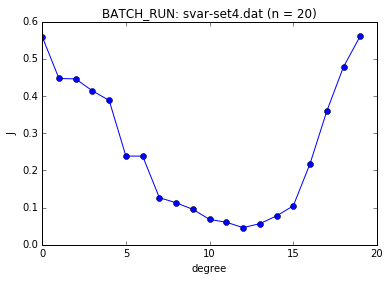

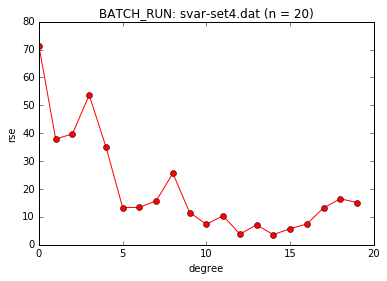

BATCH_RUN: svar-set4.dat (n = 20)
J_min = 0.0461803	n = 13
rse_min = 3.6592190	n = 15
running time: [0.0026369094848632812, 0.0022780895233154297, 0.001995086669921875, 0.002986907958984375, 0.0035619735717773438, 0.004083156585693359, 0.004839897155761719, 0.004173994064331055, 0.004474163055419922, 0.003407001495361328, 0.004479169845581055, 0.004824161529541016, 0.006831169128417969, 0.005897045135498047, 0.007915019989013672, 0.00742793083190918, 0.0065190792083740234, 0.004929065704345703, 0.007157087326049805, 0.005788087844848633] 




In [131]:
# run all datasets, fit linear regression model with degree from 1 to 20, truncate data to 50%
batch_run(s_fnames, 'explicit', 20, truncate=0.5, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=2.0636794	train_rse_avg=0.0018918	
	test_J_avg=2.1815313	test_rse_avg=0.0020210
RUN: svar-set1.dat (n = 1)
applied to all data (n = 1):
	J=2.0694722	rse=0.0018983
running time: 0.00235795974731


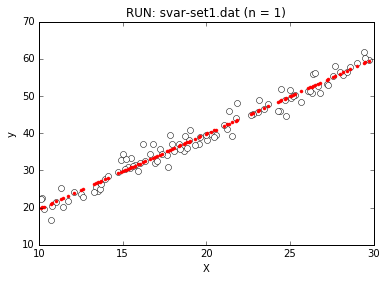

CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=2.0618280	train_rse_avg=0.0018905	
	test_J_avg=2.2176964	test_rse_avg=0.0020530
RUN: svar-set1.dat (n = 2)
applied to all data (n = 2):
	J=2.0694477	rse=0.0019003
running time: 0.00198793411255


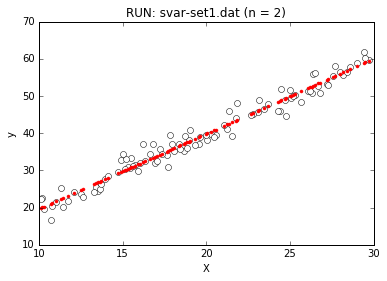

CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=2.0019015	train_rse_avg=0.0018486	
	test_J_avg=2.2491878	test_rse_avg=0.0021908
RUN: svar-set1.dat (n = 3)
applied to all data (n = 3):
	J=2.0135952	rse=0.0018674
running time: 0.00258302688599


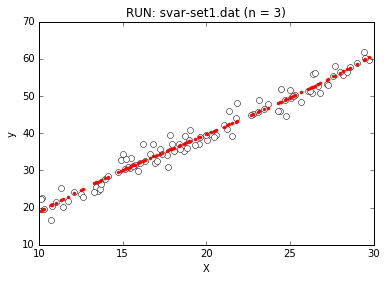

CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=1.9763699	train_rse_avg=0.0018058	
	test_J_avg=2.2177218	test_rse_avg=0.0019941
RUN: svar-set1.dat (n = 4)
applied to all data (n = 4):
	J=1.9875761	rse=0.0018128
running time: 0.00326800346375


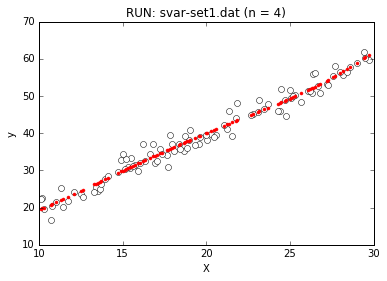

CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=1.9426688	train_rse_avg=0.0017178	
	test_J_avg=2.2654967	test_rse_avg=0.0020501
RUN: svar-set1.dat (n = 5)
applied to all data (n = 5):
	J=1.9581699	rse=0.0017349
running time: 0.00245380401611


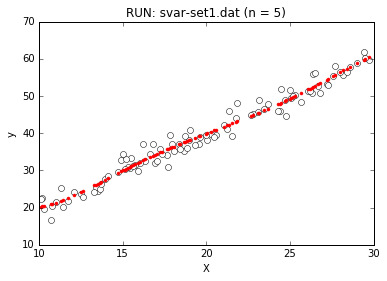

CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=1.8606075	train_rse_avg=0.0015972	
	test_J_avg=2.1587033	test_rse_avg=0.0019530
RUN: svar-set1.dat (n = 6)
applied to all data (n = 6):
	J=1.8745809	rse=0.0016137
running time: 0.00263285636902


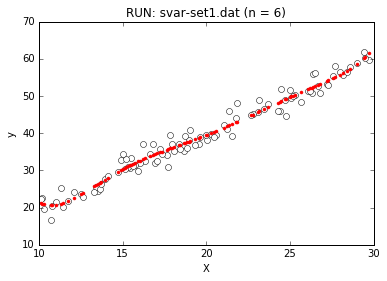

CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=1.8212070	train_rse_avg=0.0015721	
	test_J_avg=2.2218150	test_rse_avg=0.0019832
RUN: svar-set1.dat (n = 7)
applied to all data (n = 7):
	J=1.8401503	rse=0.0015911
running time: 0.0028989315033


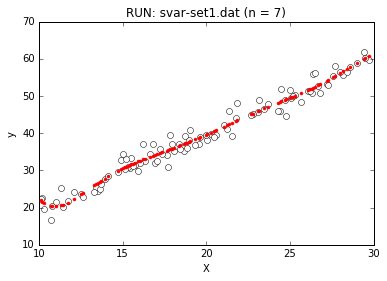

CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=1.8105204	train_rse_avg=0.0015685	
	test_J_avg=2.0546858	test_rse_avg=0.0018606
RUN: svar-set1.dat (n = 8)
applied to all data (n = 8):
	J=1.8223066	rse=0.0015829
running time: 0.00391292572021


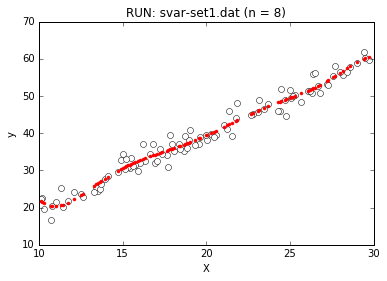

CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=1.8081823	train_rse_avg=0.0015689	
	test_J_avg=2.0895949	test_rse_avg=0.0018854
RUN: svar-set1.dat (n = 9)
applied to all data (n = 9):
	J=1.8214318	rse=0.0015868
running time: 0.00430083274841


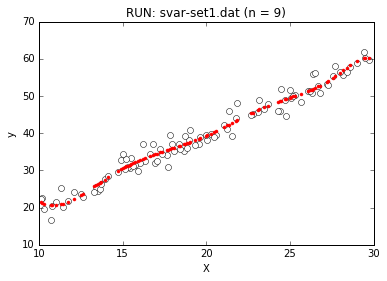

CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=1.8387605	train_rse_avg=0.0016031	
	test_J_avg=2.0997042	test_rse_avg=0.0018564
RUN: svar-set1.dat (n = 10)
applied to all data (n = 10):
	J=1.8514236	rse=0.0016169
running time: 0.00335788726807


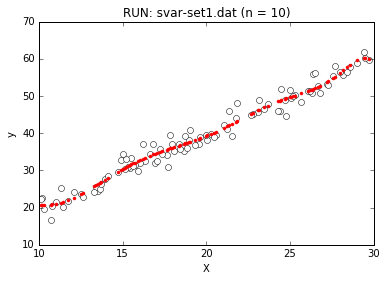

CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=1.8913562	train_rse_avg=0.0016645	
	test_J_avg=2.3455236	test_rse_avg=0.0022157
RUN: svar-set1.dat (n = 11)
applied to all data (n = 11):
	J=1.9104666	rse=0.0016885
running time: 0.00362801551819


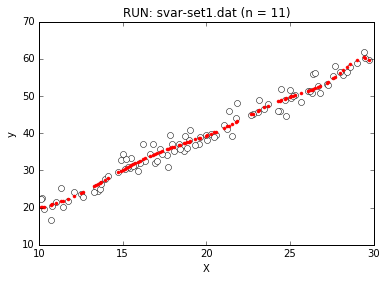

CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=2.0895482	train_rse_avg=0.0019809	
	test_J_avg=2.4365689	test_rse_avg=0.0023326
RUN: svar-set1.dat (n = 12)
applied to all data (n = 12):
	J=1.9931393	rse=0.0018042
running time: 0.00388288497925


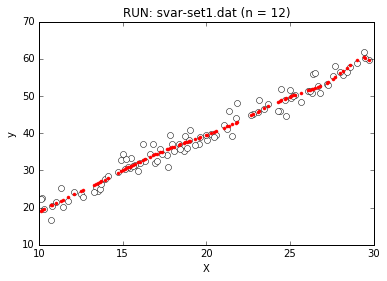

CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=2.7030328	train_rse_avg=0.0030447	
	test_J_avg=3.1850650	test_rse_avg=0.0034014
RUN: svar-set1.dat (n = 13)
applied to all data (n = 13):
	J=2.7235042	rse=0.0030643
running time: 0.00395202636719


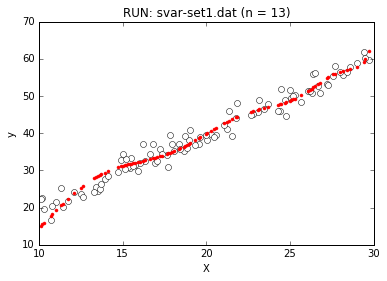

CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=3.7587107	train_rse_avg=0.0048987	
	test_J_avg=4.6377024	test_rse_avg=0.0055691
RUN: svar-set1.dat (n = 14)
applied to all data (n = 14):
	J=3.7944363	rse=0.0049380
running time: 0.00580310821533


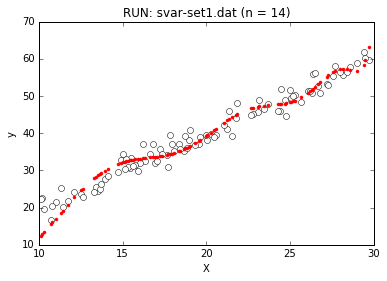

CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=5.9225542	train_rse_avg=0.0088512	
	test_J_avg=7.5735787	test_rse_avg=0.0096340
RUN: svar-set1.dat (n = 15)
applied to all data (n = 15):
	J=5.9772412	rse=0.0089249
running time: 0.00425601005554


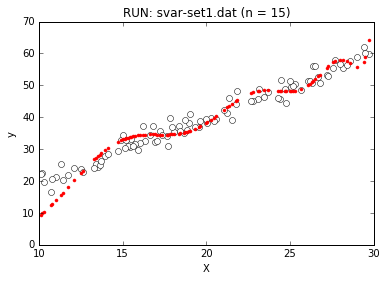

CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=9.5382562	train_rse_avg=0.0155860	
	test_J_avg=11.8255319	test_rse_avg=0.0164058
RUN: svar-set1.dat (n = 16)
applied to all data (n = 16):
	J=9.6085827	rse=0.0156889
running time: 0.00445199012756


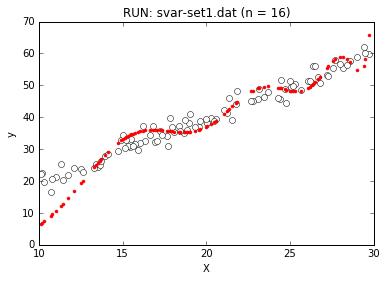

CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=14.6663822	train_rse_avg=0.0249226	
	test_J_avg=18.5593126	test_rse_avg=0.0263626
RUN: svar-set1.dat (n = 17)
applied to all data (n = 17):
	J=14.7794622	rse=0.0250835
running time: 0.00465512275696


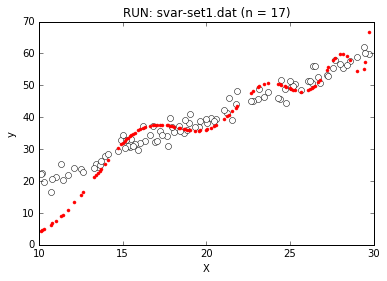

CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=21.2611044	train_rse_avg=0.0361899	
	test_J_avg=30.8938970	test_rse_avg=0.0392462
RUN: svar-set1.dat (n = 18)
applied to all data (n = 18):
	J=21.4769919	rse=0.0364796
running time: 0.00499296188354


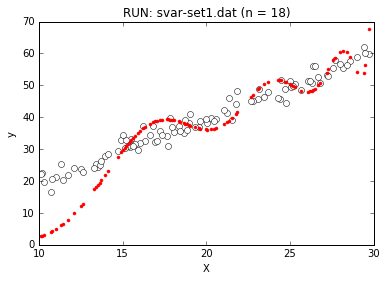

CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=29.4254291	train_rse_avg=0.0489417	
	test_J_avg=40.0285005	test_rse_avg=0.0527873
RUN: svar-set1.dat (n = 19)
applied to all data (n = 19):
	J=29.6821179	rse=0.0492580
running time: 0.00636291503906


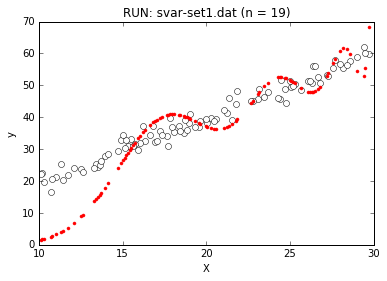

CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=38.9810212	train_rse_avg=0.0625543	
	test_J_avg=75.2518352	test_rse_avg=0.0734024
RUN: svar-set1.dat (n = 20)
applied to all data (n = 20):
	J=39.3290942	rse=0.0629433
running time: 0.00531506538391


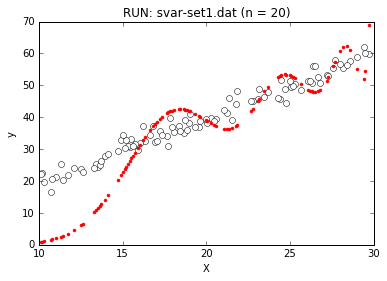

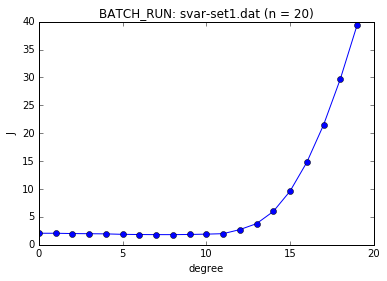

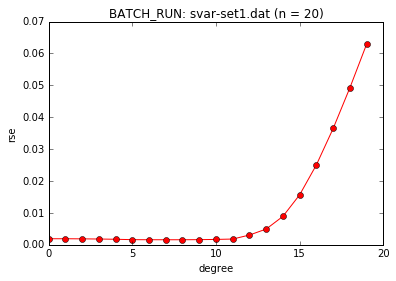

BATCH_RUN: svar-set1.dat (n = 20)
J_min = 1.8214318	n = 9
rse_min = 0.0015829	n = 8
running time: [0.002357959747314453, 0.001987934112548828, 0.002583026885986328, 0.003268003463745117, 0.0024538040161132812, 0.0026328563690185547, 0.0028989315032958984, 0.003912925720214844, 0.004300832748413086, 0.0033578872680664062, 0.0036280155181884766, 0.003882884979248047, 0.0039520263671875, 0.005803108215332031, 0.004256010055541992, 0.0044519901275634766, 0.004655122756958008, 0.004992961883544922, 0.0063629150390625, 0.005315065383911133] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.0286443	train_rse_avg=5.2365183	
	test_J_avg=0.0312781	test_rse_avg=5.4518990
RUN: svar-set2.dat (n = 1)
applied to all data (n = 1):
	J=0.0287758	rse=5.2097647
running time: 0.00191593170166


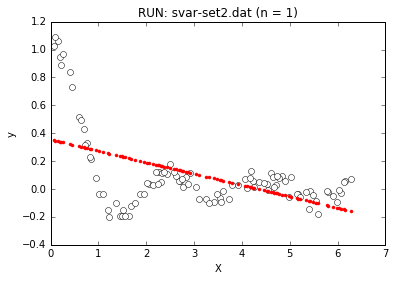

CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.0183719	train_rse_avg=6.5178836	
	test_J_avg=0.0197570	test_rse_avg=6.4843413
RUN: svar-set2.dat (n = 2)
applied to all data (n = 2):
	J=0.0184402	rse=6.5149939
running time: 0.00198006629944


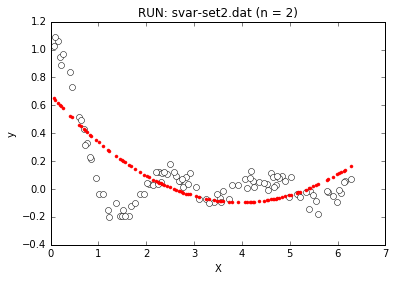

CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.0094837	train_rse_avg=3.6992388	
	test_J_avg=0.0102263	test_rse_avg=4.1991231
RUN: svar-set2.dat (n = 3)
applied to all data (n = 3):
	J=0.0095203	rse=3.6971767
running time: 0.00325608253479


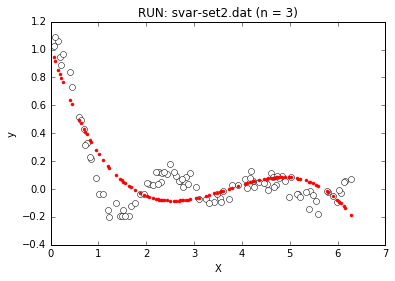

CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.0045426	train_rse_avg=2.1283125	
	test_J_avg=0.0049980	test_rse_avg=2.0853582
RUN: svar-set2.dat (n = 4)
applied to all data (n = 4):
	J=0.0045647	rse=2.1084881
running time: 0.00261282920837


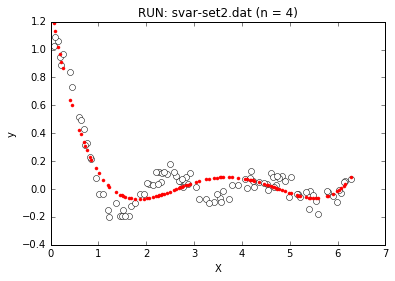

CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.0043007	train_rse_avg=1.1267413	
	test_J_avg=0.0049647	test_rse_avg=1.1736296
RUN: svar-set2.dat (n = 5)
applied to all data (n = 5):
	J=0.0043313	rse=1.1099932
running time: 0.00255393981934


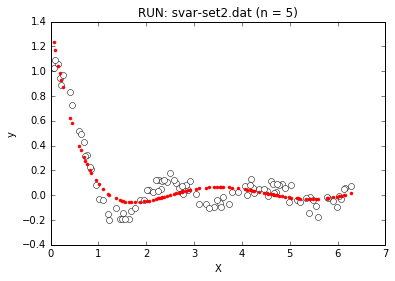

CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.0042963	train_rse_avg=1.1399414	
	test_J_avg=0.0049515	test_rse_avg=1.1577375
RUN: svar-set2.dat (n = 6)
applied to all data (n = 6):
	J=0.0043253	rse=1.1236189
running time: 0.00273394584656


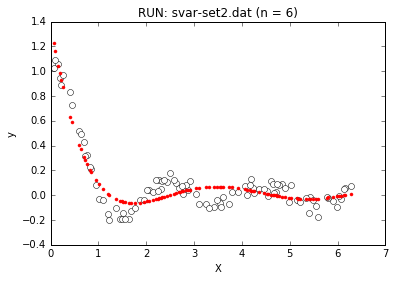

CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.0021169	train_rse_avg=1.8032952	
	test_J_avg=0.0032957	test_rse_avg=2.3847168
RUN: svar-set2.dat (n = 7)
applied to all data (n = 7):
	J=0.0021606	rse=1.7876160
running time: 0.00315713882446


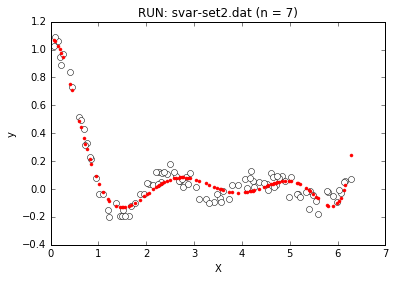

CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.0012260	train_rse_avg=1.1263419	
	test_J_avg=0.0015434	test_rse_avg=1.4128922
RUN: svar-set2.dat (n = 8)
applied to all data (n = 8):
	J=0.0012404	rse=1.1322853
running time: 0.00453400611877


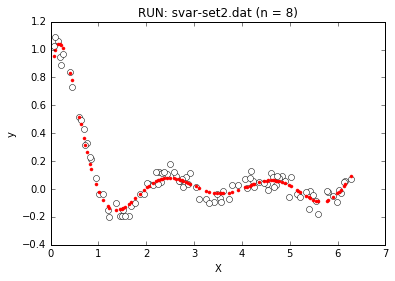

CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.0010386	train_rse_avg=1.7184179	
	test_J_avg=0.0016326	test_rse_avg=2.3819675
RUN: svar-set2.dat (n = 9)
applied to all data (n = 9):
	J=0.0010567	rse=1.7504877
running time: 0.00371193885803


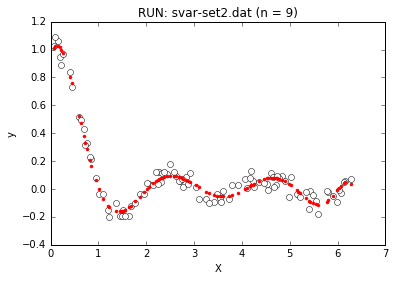

CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0008068	train_rse_avg=1.5213621	
	test_J_avg=0.0010931	test_rse_avg=1.7537367
RUN: svar-set2.dat (n = 10)
applied to all data (n = 10):
	J=0.0008189	rse=1.5377518
running time: 0.00389099121094


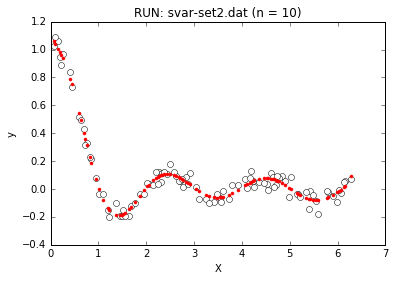

CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0008048	train_rse_avg=1.5269069	
	test_J_avg=0.0013264	test_rse_avg=1.7084095
RUN: svar-set2.dat (n = 11)
applied to all data (n = 11):
	J=0.0008186	rse=1.5213102
running time: 0.00402188301086


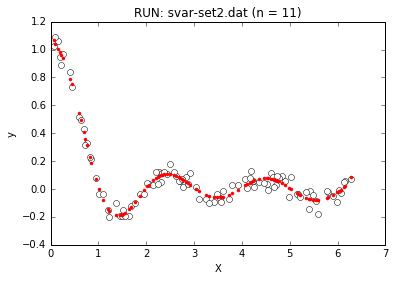

CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0007872	train_rse_avg=1.5099134	
	test_J_avg=0.0011657	test_rse_avg=2.1768821
RUN: svar-set2.dat (n = 12)
applied to all data (n = 12):
	J=0.0008020	rse=1.5415906
running time: 0.00392913818359


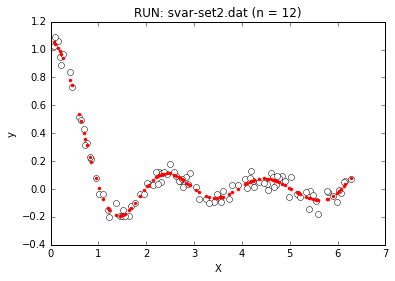

CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0007874	train_rse_avg=1.5292725	
	test_J_avg=0.0012683	test_rse_avg=2.0149632
RUN: svar-set2.dat (n = 13)
applied to all data (n = 13):
	J=0.0008017	rse=1.5596265
running time: 0.00398707389832


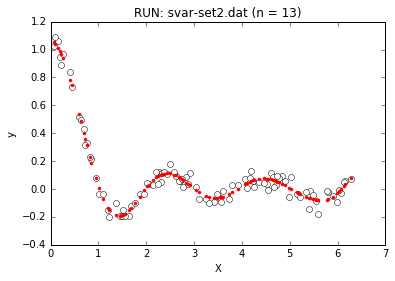

CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0007722	train_rse_avg=1.4691189	
	test_J_avg=0.0107589	test_rse_avg=4.4174598
RUN: svar-set2.dat (n = 14)
applied to all data (n = 14):
	J=0.0007938	rse=1.5215045
running time: 0.0045108795166


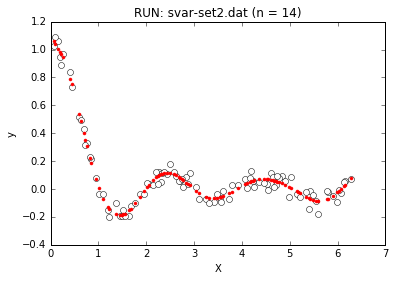

CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0007813	train_rse_avg=1.4904151	
	test_J_avg=0.0027725	test_rse_avg=2.2222642
RUN: svar-set2.dat (n = 15)
applied to all data (n = 15):
	J=0.0007972	rse=1.5195540
running time: 0.00524711608887


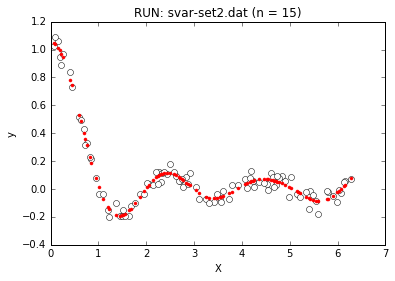

CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0007811	train_rse_avg=1.4998231	
	test_J_avg=0.0055122	test_rse_avg=2.7652334
RUN: svar-set2.dat (n = 16)
applied to all data (n = 16):
	J=0.0007971	rse=1.5351965
running time: 0.00504183769226


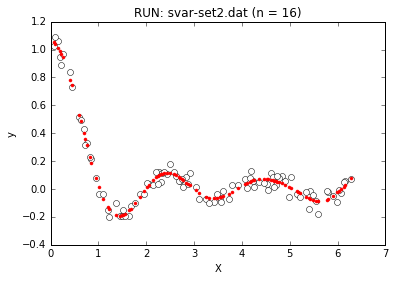

CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.0007867	train_rse_avg=1.4973516	
	test_J_avg=0.0090545	test_rse_avg=3.4168169
RUN: svar-set2.dat (n = 17)
applied to all data (n = 17):
	J=0.0008047	rse=1.5307889
running time: 0.00699496269226


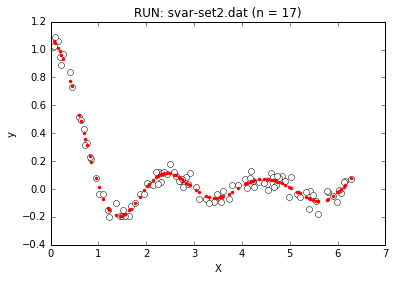

CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.0008205	train_rse_avg=1.4488263	
	test_J_avg=0.0053166	test_rse_avg=2.7848242
RUN: svar-set2.dat (n = 18)
applied to all data (n = 18):
	J=0.0008347	rse=1.4310677
running time: 0.00500893592834


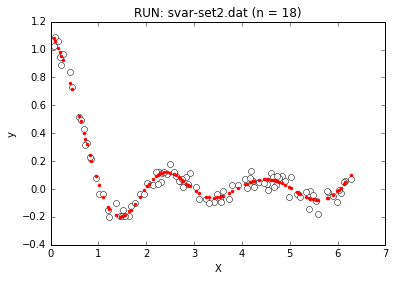

CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.0117367	train_rse_avg=5.3437149	
	test_J_avg=0.1844170	test_rse_avg=39.4942881
RUN: svar-set2.dat (n = 19)
applied to all data (n = 19):
	J=0.0120357	rse=5.7734948
running time: 0.00504112243652


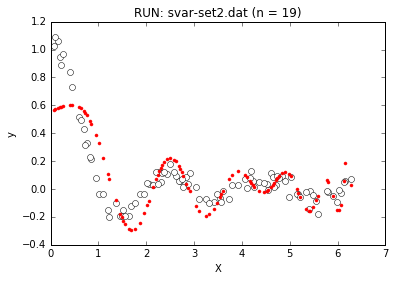

CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.0430889	train_rse_avg=1.7896077	
	test_J_avg=0.0520703	test_rse_avg=3.6556491
RUN: svar-set2.dat (n = 20)
applied to all data (n = 20):
	J=0.0430047	rse=1.6396772
running time: 0.0055410861969


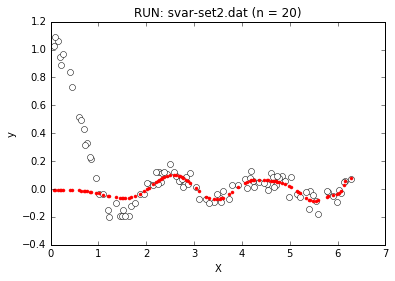

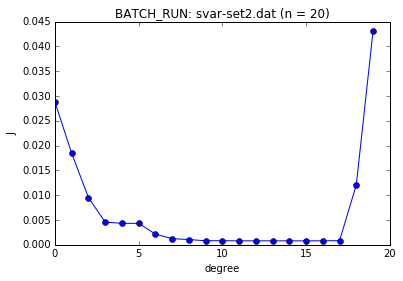

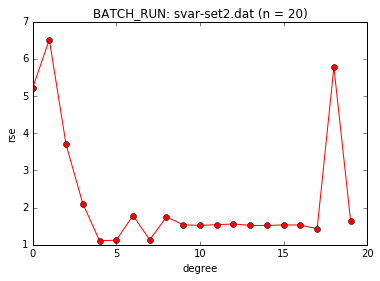

BATCH_RUN: svar-set2.dat (n = 20)
J_min = 0.0007938	n = 14
rse_min = 1.1099932	n = 5
running time: [0.0019159317016601562, 0.0019800662994384766, 0.003256082534790039, 0.0026128292083740234, 0.0025539398193359375, 0.002733945846557617, 0.0031571388244628906, 0.004534006118774414, 0.0037119388580322266, 0.0038909912109375, 0.004021883010864258, 0.00392913818359375, 0.00398707389831543, 0.0045108795166015625, 0.0052471160888671875, 0.005041837692260742, 0.006994962692260742, 0.0050089359283447266, 0.0050411224365234375, 0.005541086196899414] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.2286388	train_rse_avg=49.4212299	
	test_J_avg=0.2379412	test_rse_avg=62.4593440
RUN: svar-set3.dat (n = 1)
applied to all data (n = 1):
	J=0.2290910	rse=50.1815958
running time: 0.00269389152527


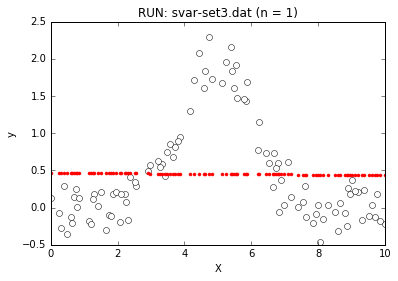

CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.1146810	train_rse_avg=69.2357241	
	test_J_avg=0.1242038	test_rse_avg=81.7121065
RUN: svar-set3.dat (n = 2)
applied to all data (n = 2):
	J=0.1151508	rse=70.2664711
running time: 0.00231194496155


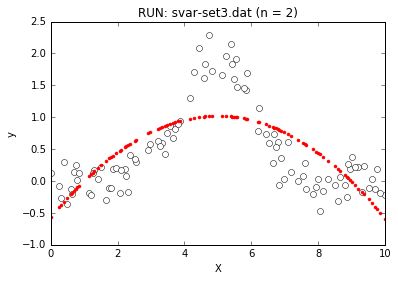

CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.1141728	train_rse_avg=62.6712911	
	test_J_avg=0.1242000	test_rse_avg=69.4999671
RUN: svar-set3.dat (n = 3)
applied to all data (n = 3):
	J=0.1146650	rse=63.1183518
running time: 0.00329399108887


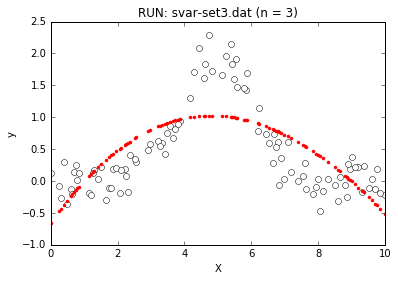

CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.0557241	train_rse_avg=25.2299881	
	test_J_avg=0.0628015	test_rse_avg=26.2624980
RUN: svar-set3.dat (n = 4)
applied to all data (n = 4):
	J=0.0560557	rse=25.3282794
running time: 0.00241088867188


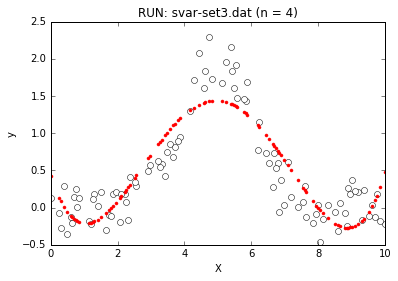

CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.0550943	train_rse_avg=23.9895073	
	test_J_avg=0.0634791	test_rse_avg=25.4532237
RUN: svar-set3.dat (n = 5)
applied to all data (n = 5):
	J=0.0554907	rse=24.1668667
running time: 0.00352907180786


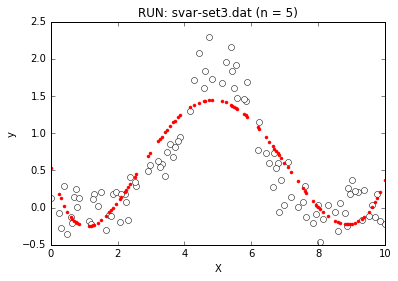

CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.0272741	train_rse_avg=3.0299650	
	test_J_avg=0.0355607	test_rse_avg=3.0030544
RUN: svar-set3.dat (n = 6)
applied to all data (n = 6):
	J=0.0276046	rse=2.9284690
running time: 0.00265789031982


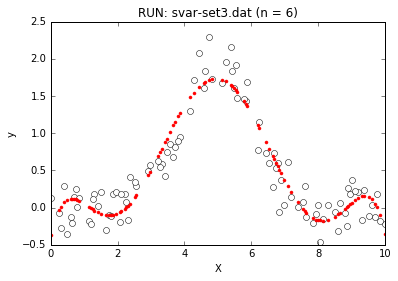

CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.0257495	train_rse_avg=2.5701335	
	test_J_avg=0.0365438	test_rse_avg=3.1885676
RUN: svar-set3.dat (n = 7)
applied to all data (n = 7):
	J=0.0261758	rse=2.3931988
running time: 0.00395393371582


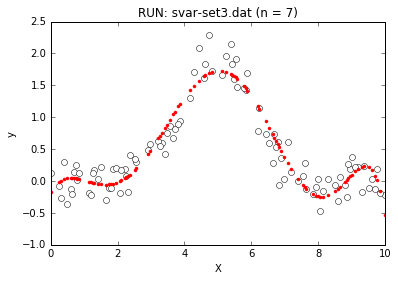

CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.0206137	train_rse_avg=1.2464367	
	test_J_avg=0.0228976	test_rse_avg=1.1854959
RUN: svar-set3.dat (n = 8)
applied to all data (n = 8):
	J=0.0207178	rse=1.2032168
running time: 0.00296592712402


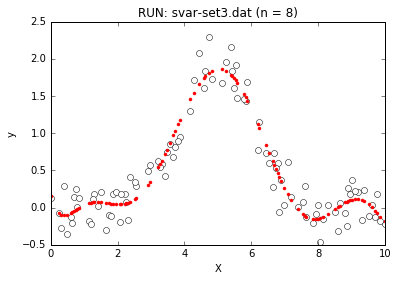

CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.0204821	train_rse_avg=1.3661051	
	test_J_avg=0.0246656	test_rse_avg=1.7119359
RUN: svar-set3.dat (n = 9)
applied to all data (n = 9):
	J=0.0206779	rse=1.3044423
running time: 0.00374794006348


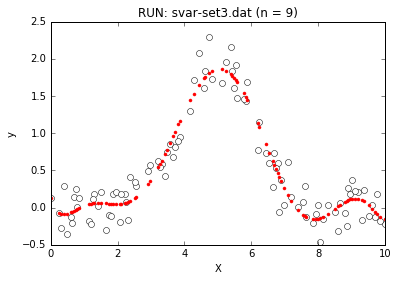

CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0196715	train_rse_avg=1.2277090	
	test_J_avg=0.0255864	test_rse_avg=1.6177280
RUN: svar-set3.dat (n = 10)
applied to all data (n = 10):
	J=0.0199225	rse=1.1173959
running time: 0.00484991073608


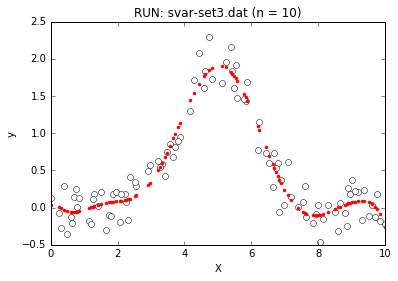

CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0195988	train_rse_avg=1.1447873	
	test_J_avg=0.0368601	test_rse_avg=1.7963615
RUN: svar-set3.dat (n = 11)
applied to all data (n = 11):
	J=0.0198935	rse=1.0274905
running time: 0.00367283821106


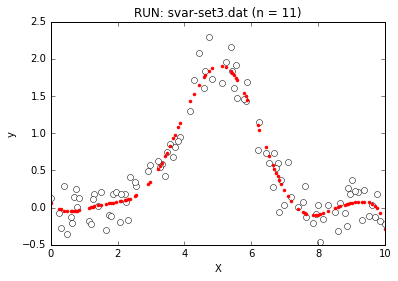

CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0177965	train_rse_avg=1.7638084	
	test_J_avg=0.0335479	test_rse_avg=2.8642677
RUN: svar-set3.dat (n = 12)
applied to all data (n = 12):
	J=0.0180816	rse=1.5628616
running time: 0.00390601158142


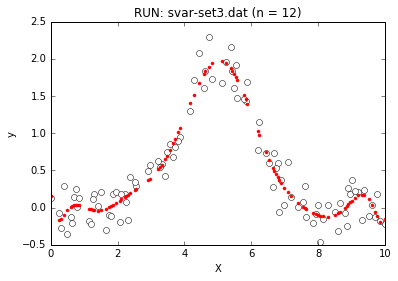

CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0182867	train_rse_avg=1.4579288	
	test_J_avg=0.0330395	test_rse_avg=3.9285825
RUN: svar-set3.dat (n = 13)
applied to all data (n = 13):
	J=0.0186137	rse=1.4118809
running time: 0.00547504425049


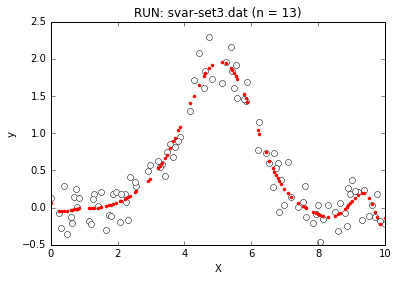

CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0186358	train_rse_avg=1.5955648	
	test_J_avg=0.0252426	test_rse_avg=1.8263229
RUN: svar-set3.dat (n = 14)
applied to all data (n = 14):
	J=0.0188747	rse=1.4390941
running time: 0.00587296485901


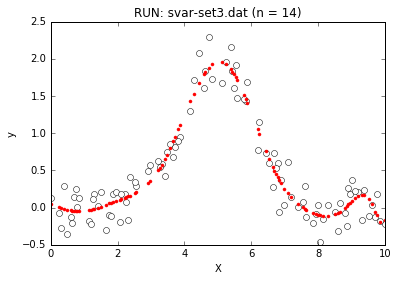

CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0184076	train_rse_avg=1.5742234	
	test_J_avg=0.0293016	test_rse_avg=4.0806170
RUN: svar-set3.dat (n = 15)
applied to all data (n = 15):
	J=0.0187079	rse=1.5948158
running time: 0.00447106361389


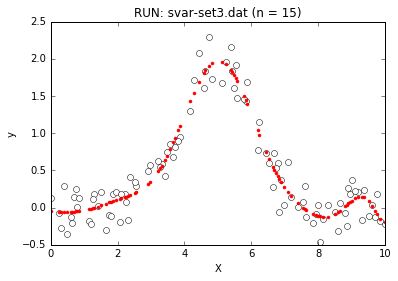

CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0182509	train_rse_avg=1.9803293	
	test_J_avg=0.0232232	test_rse_avg=2.8677473
RUN: svar-set3.dat (n = 16)
applied to all data (n = 16):
	J=0.0184611	rse=1.9062714
running time: 0.00498199462891


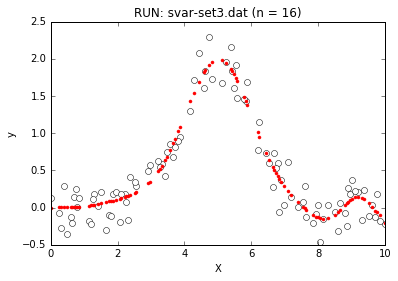

CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.0188492	train_rse_avg=1.6569437	
	test_J_avg=0.0221880	test_rse_avg=2.7246392
RUN: svar-set3.dat (n = 17)
applied to all data (n = 17):
	J=0.0189808	rse=1.5750408
running time: 0.00494599342346


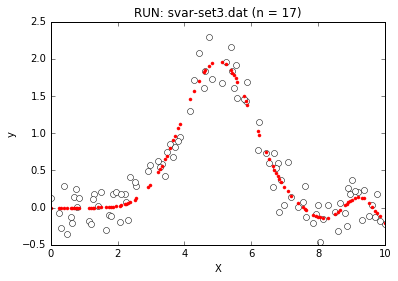

CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.0187710	train_rse_avg=2.1247221	
	test_J_avg=0.0231401	test_rse_avg=2.7731236
RUN: svar-set3.dat (n = 18)
applied to all data (n = 18):
	J=0.0189087	rse=2.0734510
running time: 0.00509095191956


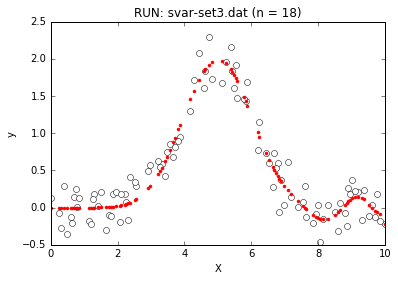

CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.0190828	train_rse_avg=2.3326271	
	test_J_avg=0.0220889	test_rse_avg=3.2710059
RUN: svar-set3.dat (n = 19)
applied to all data (n = 19):
	J=0.0192145	rse=2.3560689
running time: 0.00518894195557


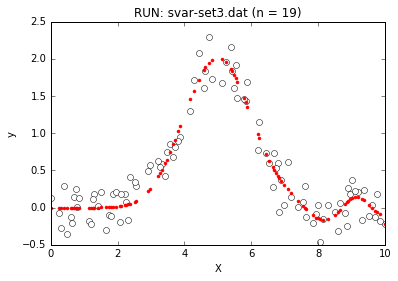

CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.0215138	train_rse_avg=4.2270381	
	test_J_avg=0.0259953	test_rse_avg=4.8237845
RUN: svar-set3.dat (n = 20)
applied to all data (n = 20):
	J=0.0202591	rse=3.0970968
running time: 0.00739908218384


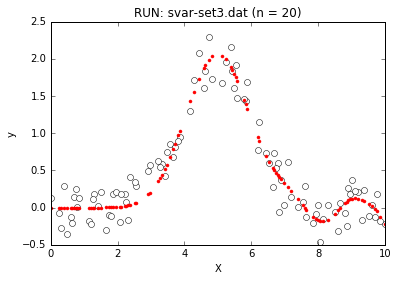

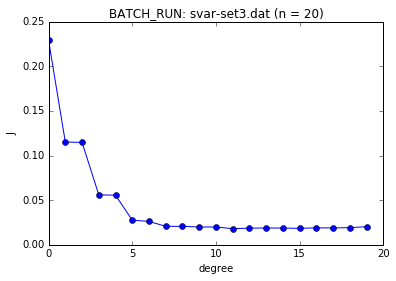

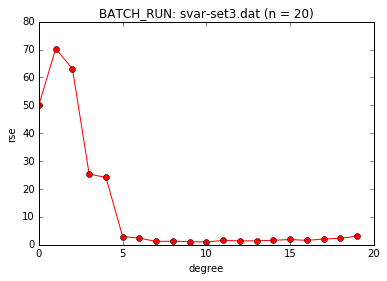

BATCH_RUN: svar-set3.dat (n = 20)
J_min = 0.0180816	n = 12
rse_min = 1.0274905	n = 11
running time: [0.0026938915252685547, 0.0023119449615478516, 0.0032939910888671875, 0.002410888671875, 0.003529071807861328, 0.0026578903198242188, 0.0039539337158203125, 0.0029659271240234375, 0.0037479400634765625, 0.004849910736083984, 0.0036728382110595703, 0.0039060115814208984, 0.005475044250488281, 0.005872964859008789, 0.0044710636138916016, 0.00498199462890625, 0.004945993423461914, 0.005090951919555664, 0.005188941955566406, 0.007399082183837891] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.5582120	train_rse_avg=71.4334292	
	test_J_avg=0.5860852	test_rse_avg=72.5009132
RUN: svar-set4.dat (n = 1)
applied to all data (n = 1):
	J=0.5595999	rse=71.1868910
running time: 0.00191211700439


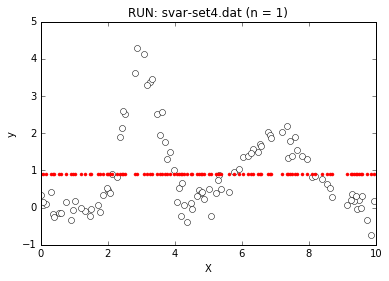

CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.4466150	train_rse_avg=38.0276676	
	test_J_avg=0.4573643	test_rse_avg=38.0879017
RUN: svar-set4.dat (n = 2)
applied to all data (n = 2):
	J=0.4471481	rse=37.9125617
running time: 0.00204396247864


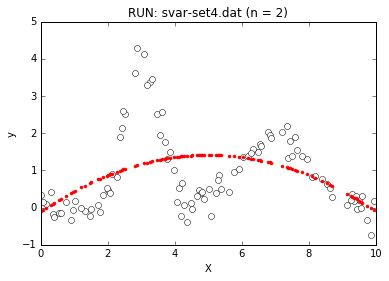

CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.4436516	train_rse_avg=39.9036684	
	test_J_avg=0.4898179	test_rse_avg=39.9998844
RUN: svar-set4.dat (n = 3)
applied to all data (n = 3):
	J=0.4459183	rse=39.7282392
running time: 0.00224184989929


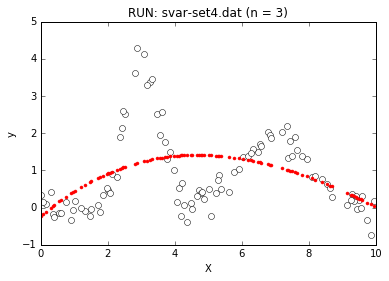

CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.4108763	train_rse_avg=53.5337717	
	test_J_avg=0.4711922	test_rse_avg=62.1755111
RUN: svar-set4.dat (n = 4)
applied to all data (n = 4):
	J=0.4138121	rse=53.7050457
running time: 0.00274920463562


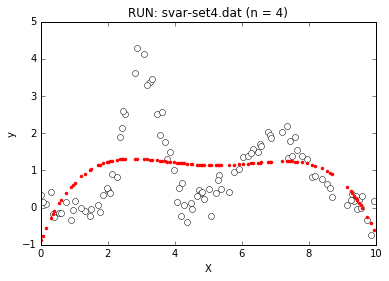

CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.3849927	train_rse_avg=34.7480073	
	test_J_avg=0.4560429	test_rse_avg=42.3424066
RUN: svar-set4.dat (n = 5)
applied to all data (n = 5):
	J=0.3881810	rse=35.1514362
running time: 0.00256514549255


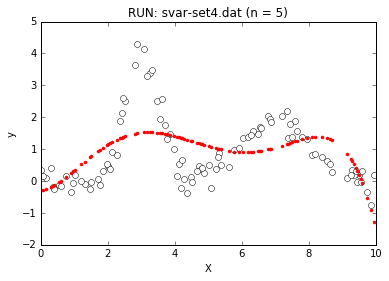

CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.2370190	train_rse_avg=13.4986879	
	test_J_avg=0.2688298	test_rse_avg=14.6753424
RUN: svar-set4.dat (n = 6)
applied to all data (n = 6):
	J=0.2384964	rse=13.3370489
running time: 0.00336289405823


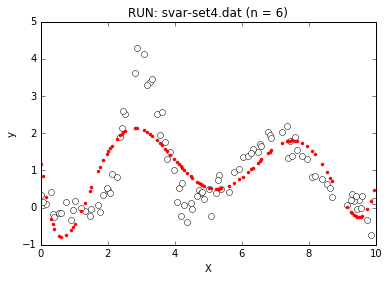

CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.2365283	train_rse_avg=13.3677022	
	test_J_avg=0.2768521	test_rse_avg=16.2756741
RUN: svar-set4.dat (n = 7)
applied to all data (n = 7):
	J=0.2384277	rse=13.4301897
running time: 0.00394201278687


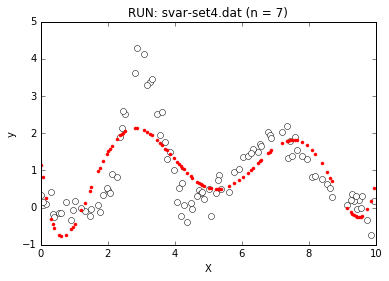

CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.1247034	train_rse_avg=15.7059948	
	test_J_avg=0.1692922	test_rse_avg=19.3325392
RUN: svar-set4.dat (n = 8)
applied to all data (n = 8):
	J=0.1264949	rse=15.7266913
running time: 0.00297904014587


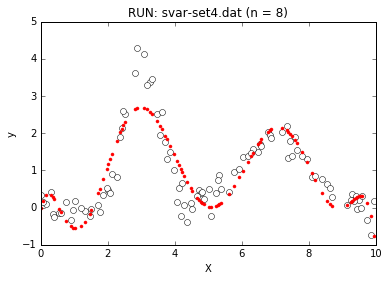

CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.1118143	train_rse_avg=25.0125373	
	test_J_avg=0.1430477	test_rse_avg=31.6875515
RUN: svar-set4.dat (n = 9)
applied to all data (n = 9):
	J=0.1130436	rse=25.6327337
running time: 0.0040168762207


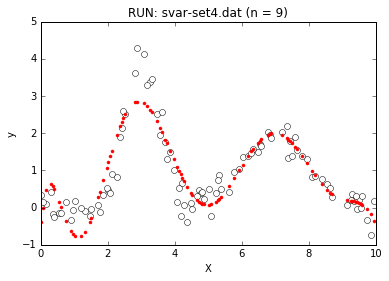

CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0944644	train_rse_avg=11.6312294	
	test_J_avg=0.1126777	test_rse_avg=12.9405338
RUN: svar-set4.dat (n = 10)
applied to all data (n = 10):
	J=0.0953119	rse=11.5578404
running time: 0.00383901596069


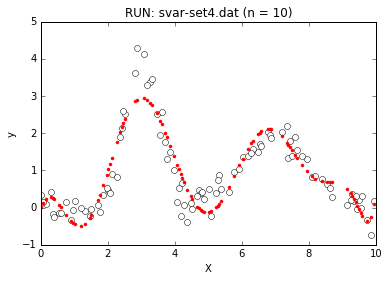

CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0666848	train_rse_avg=7.4915244	
	test_J_avg=0.1171849	test_rse_avg=9.5840391
RUN: svar-set4.dat (n = 11)
applied to all data (n = 11):
	J=0.0681635	rse=7.3931006
running time: 0.00417518615723


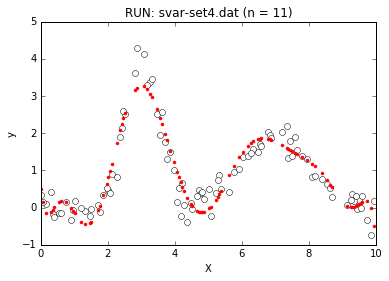

CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0582500	train_rse_avg=9.6142683	
	test_J_avg=0.2388108	test_rse_avg=16.0822982
RUN: svar-set4.dat (n = 12)
applied to all data (n = 12):
	J=0.0606376	rse=10.4045206
running time: 0.00557613372803


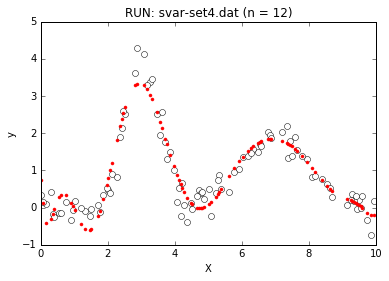

CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0456897	train_rse_avg=3.8332357	
	test_J_avg=0.0571161	test_rse_avg=5.0141454
RUN: svar-set4.dat (n = 13)
applied to all data (n = 13):
	J=0.0461803	rse=3.8475848
running time: 0.00559306144714


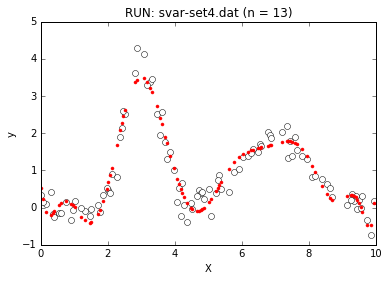

CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0561391	train_rse_avg=7.0644525	
	test_J_avg=0.0705310	test_rse_avg=8.9442521
RUN: svar-set4.dat (n = 14)
applied to all data (n = 14):
	J=0.0568192	rse=7.1267988
running time: 0.00460886955261


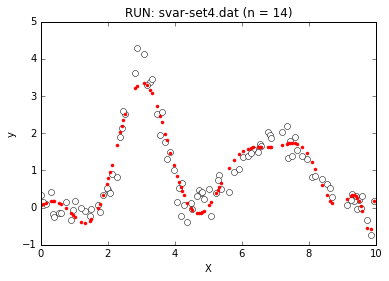

CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0755782	train_rse_avg=4.6048631	
	test_J_avg=0.0937643	test_rse_avg=4.3760447
RUN: svar-set4.dat (n = 15)
applied to all data (n = 15):
	J=0.0777035	rse=3.6592190
running time: 0.00441789627075


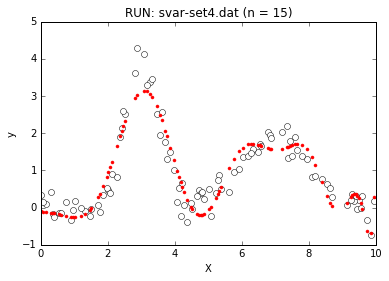

CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.1034183	train_rse_avg=5.6190694	
	test_J_avg=0.3517649	test_rse_avg=12.6740097
RUN: svar-set4.dat (n = 16)
applied to all data (n = 16):
	J=0.1047938	rse=5.7582645
running time: 0.00615501403809


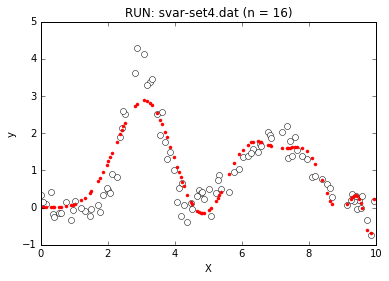

CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.2147082	train_rse_avg=7.0908618	
	test_J_avg=0.3667164	test_rse_avg=12.8041226
RUN: svar-set4.dat (n = 17)
applied to all data (n = 17):
	J=0.2180392	rse=7.4709128
running time: 0.00530815124512


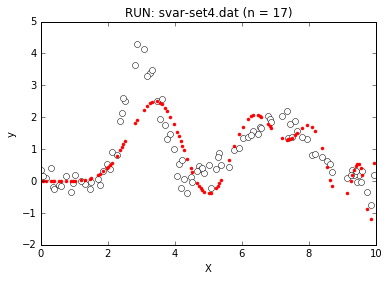

CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.3555272	train_rse_avg=12.4221111	
	test_J_avg=0.5872347	test_rse_avg=24.5091308
RUN: svar-set4.dat (n = 18)
applied to all data (n = 18):
	J=0.3592665	rse=13.2156166
running time: 0.0049409866333


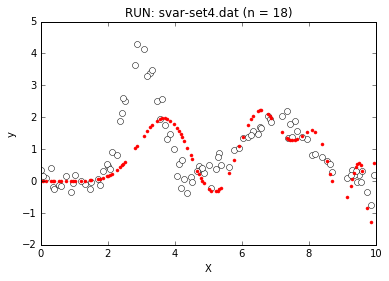

CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.4761215	train_rse_avg=15.7964648	
	test_J_avg=0.6401391	test_rse_avg=28.7623947
RUN: svar-set4.dat (n = 19)
applied to all data (n = 19):
	J=0.4784343	rse=16.4892135
running time: 0.00605702400208


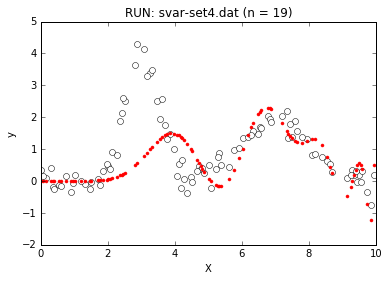

CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.5587979	train_rse_avg=14.7418760	
	test_J_avg=0.9340559	test_rse_avg=30.0453717
RUN: svar-set4.dat (n = 20)
applied to all data (n = 20):
	J=0.5611769	rse=15.1587633
running time: 0.00549602508545


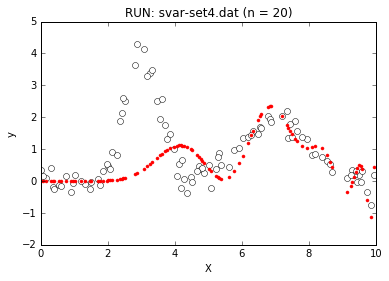

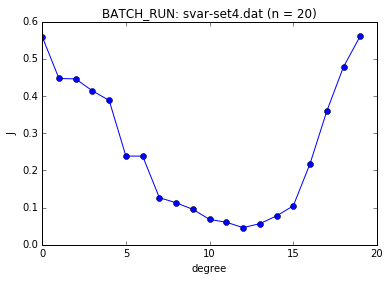

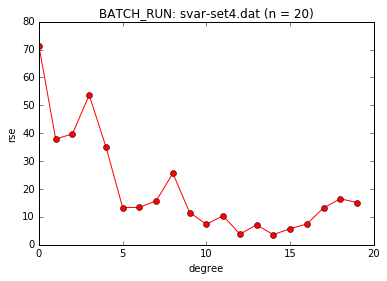

BATCH_RUN: svar-set4.dat (n = 20)
J_min = 0.0461803	n = 13
rse_min = 3.6592190	n = 15
running time: [0.0019121170043945312, 0.0020439624786376953, 0.002241849899291992, 0.002749204635620117, 0.002565145492553711, 0.003362894058227539, 0.003942012786865234, 0.0029790401458740234, 0.004016876220703125, 0.0038390159606933594, 0.0041751861572265625, 0.005576133728027344, 0.005593061447143555, 0.004608869552612305, 0.004417896270751953, 0.0061550140380859375, 0.0053081512451171875, 0.004940986633300781, 0.006057024002075195, 0.005496025085449219] 




In [132]:
# run all datasets, fit linear regression model with degree from 1 to 20, truncate data to 50%
# plot all results and graphs
batch_run(s_fnames, 'explicit', 20, truncate=0.5, \
          r_verbose=True, pl_verbose=True, bpl_verbose=True)

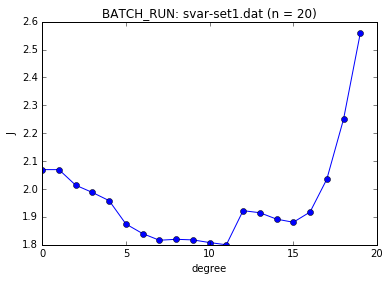

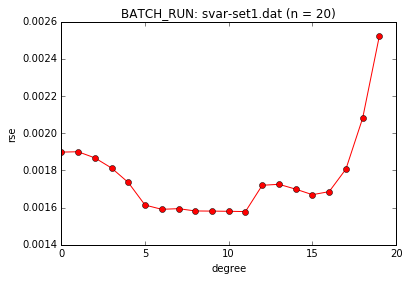

BATCH_RUN: svar-set1.dat (n = 20)
J_min = 1.8000921	n = 12
rse_min = 0.0015786	n = 12
running time: [0.006309032440185547, 0.006662130355834961, 0.007350921630859375, 0.005959033966064453, 0.0061991214752197266, 0.005599021911621094, 0.0058629512786865234, 0.006411075592041016, 0.008952856063842773, 0.006763935089111328, 0.00870513916015625, 0.01040792465209961, 0.008867025375366211, 0.008965015411376953, 0.007475137710571289, 0.007989883422851562, 0.007866859436035156, 0.008107900619506836, 0.00828409194946289, 0.008604049682617188] 




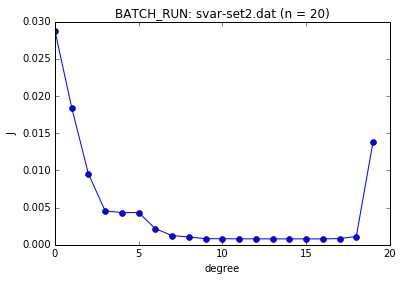

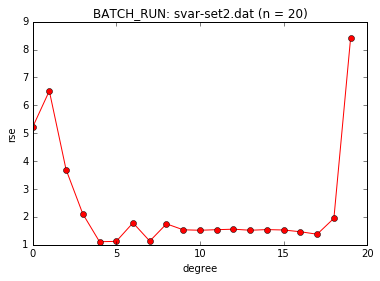

BATCH_RUN: svar-set2.dat (n = 20)
J_min = 0.0007888	n = 17
rse_min = 1.1099932	n = 5
running time: [0.007409095764160156, 0.006688117980957031, 0.005268096923828125, 0.006031990051269531, 0.005406856536865234, 0.006941795349121094, 0.00905299186706543, 0.007816791534423828, 0.00824117660522461, 0.008734941482543945, 0.0075299739837646484, 0.007303953170776367, 0.0077860355377197266, 0.007325172424316406, 0.007471799850463867, 0.007756948471069336, 0.00793600082397461, 0.00820302963256836, 0.008448123931884766, 0.0086669921875] 




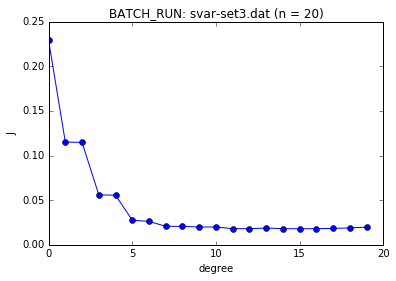

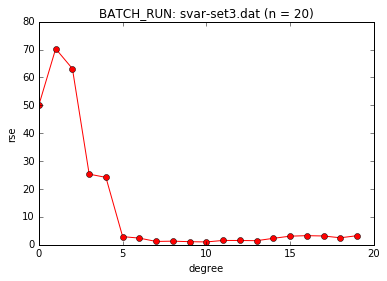

BATCH_RUN: svar-set3.dat (n = 20)
J_min = 0.0179638	n = 16
rse_min = 1.0274919	n = 11
running time: [0.005036830902099609, 0.006111860275268555, 0.006231069564819336, 0.005405902862548828, 0.00671696662902832, 0.005871772766113281, 0.006627082824707031, 0.006227970123291016, 0.0069239139556884766, 0.006644010543823242, 0.007245063781738281, 0.006951808929443359, 0.007458925247192383, 0.007472038269042969, 0.009307146072387695, 0.007904052734375, 0.00847005844116211, 0.008299827575683594, 0.009130001068115234, 0.008731842041015625] 




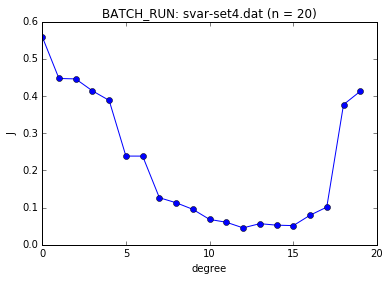

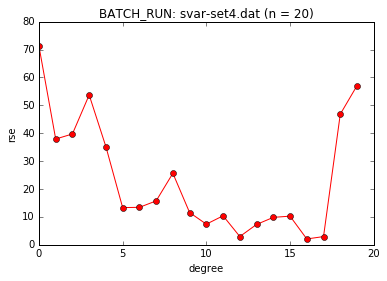

BATCH_RUN: svar-set4.dat (n = 20)
J_min = 0.0455139	n = 13
rse_min = 2.0940392	n = 17
running time: [0.005804777145385742, 0.006823062896728516, 0.008823156356811523, 0.008997201919555664, 0.006978034973144531, 0.005856990814208984, 0.008033990859985352, 0.008002042770385742, 0.008920907974243164, 0.012064933776855469, 0.015511035919189453, 0.014403104782104492, 0.011178016662597656, 0.009510040283203125, 0.011024951934814453, 0.010351896286010742, 0.008996963500976562, 0.010420083999633789, 0.00931406021118164, 0.008814811706542969] 




In [133]:
# run all datasets, fit sklearn linear regression model with degree from 1 to 20, truncate data to 50%
batch_run(s_fnames, 'sklearn', 20, truncate=0.5, bpl_verbose=True)

SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=2.0643317	train_rse_avg=0.0018915	
	test_J_avg=2.1685898	test_rse_avg=0.0020159
RUN: svar-set1.dat (n = 1)
applied to all data (n = 1):
	J=2.0694722	rse=0.0018983
running time: 0.00613403320312


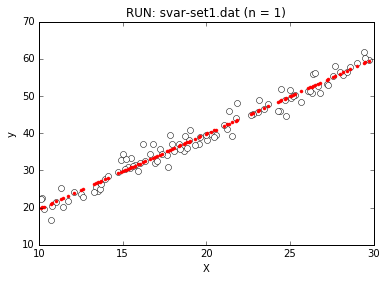

SKLEARN_CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=2.0622641	train_rse_avg=0.0018917	
	test_J_avg=2.2065425	test_rse_avg=0.0020648
RUN: svar-set1.dat (n = 2)
applied to all data (n = 2):
	J=2.0694477	rse=0.0019003
running time: 0.00601291656494


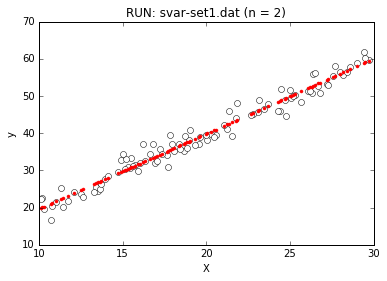

SKLEARN_CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=2.0022439	train_rse_avg=0.0018537	
	test_J_avg=2.2353678	test_rse_avg=0.0021270
RUN: svar-set1.dat (n = 3)
applied to all data (n = 3):
	J=2.0135952	rse=0.0018674
running time: 0.00582718849182


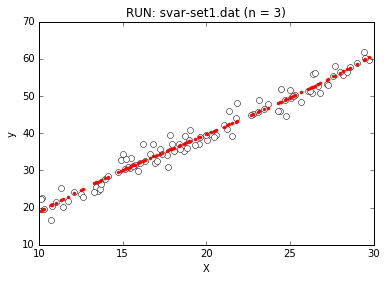

SKLEARN_CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=1.9739085	train_rse_avg=0.0017967	
	test_J_avg=2.2557561	test_rse_avg=0.0021103
RUN: svar-set1.dat (n = 4)
applied to all data (n = 4):
	J=1.9875761	rse=0.0018128
running time: 0.0062940120697


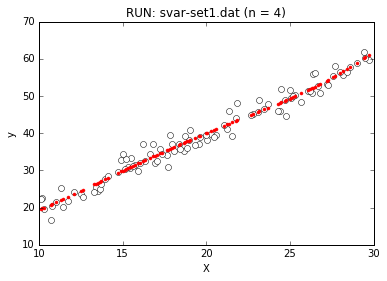

SKLEARN_CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=1.9419203	train_rse_avg=0.0017181	
	test_J_avg=2.2786572	test_rse_avg=0.0020700
RUN: svar-set1.dat (n = 5)
applied to all data (n = 5):
	J=1.9581699	rse=0.0017349
running time: 0.00625014305115


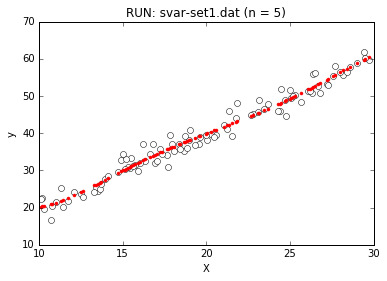

SKLEARN_CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=1.8564719	train_rse_avg=0.0015962	
	test_J_avg=2.2727266	test_rse_avg=0.0019416
RUN: svar-set1.dat (n = 6)
applied to all data (n = 6):
	J=1.8745809	rse=0.0016137
running time: 0.00893688201904


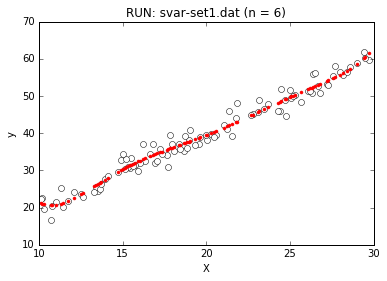

SKLEARN_CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=1.8217375	train_rse_avg=0.0015723	
	test_J_avg=2.2297081	test_rse_avg=0.0019425
RUN: svar-set1.dat (n = 7)
applied to all data (n = 7):
	J=1.8401500	rse=0.0015908
running time: 0.00632190704346


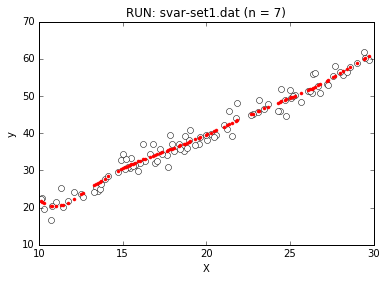

SKLEARN_CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=1.7957792	train_rse_avg=0.0015653	
	test_J_avg=2.2417561	test_rse_avg=0.0020228
RUN: svar-set1.dat (n = 8)
applied to all data (n = 8):
	J=1.8163658	rse=0.0015943
running time: 0.00851702690125


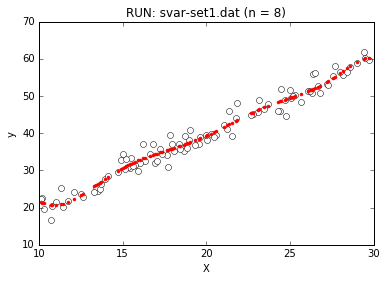

SKLEARN_CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=1.7991041	train_rse_avg=0.0015593	
	test_J_avg=2.2538707	test_rse_avg=0.0020054
RUN: svar-set1.dat (n = 9)
applied to all data (n = 9):
	J=1.8197077	rse=0.0015820
running time: 0.0070788860321


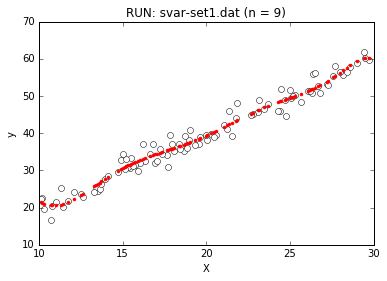

SKLEARN_CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=1.7969978	train_rse_avg=0.0015609	
	test_J_avg=2.2687005	test_rse_avg=0.0019784
RUN: svar-set1.dat (n = 10)
applied to all data (n = 10):
	J=1.8175996	rse=0.0015811
running time: 0.00700998306274


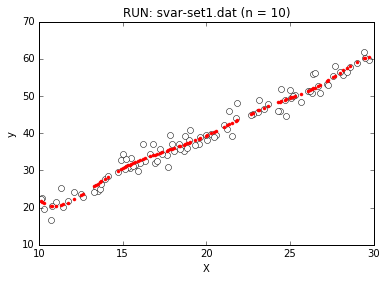

SKLEARN_CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=1.7871141	train_rse_avg=0.0015599	
	test_J_avg=2.3061259	test_rse_avg=0.0019650
RUN: svar-set1.dat (n = 11)
applied to all data (n = 11):
	J=1.8080206	rse=0.0015801
running time: 0.00835108757019


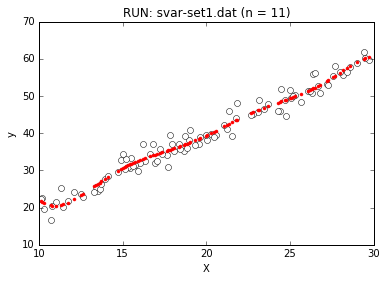

SKLEARN_CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=1.8075360	train_rse_avg=0.0015827	
	test_J_avg=2.4462652	test_rse_avg=0.0020703
RUN: svar-set1.dat (n = 12)
applied to all data (n = 12):
	J=1.8000921	rse=0.0015786
running time: 0.00718903541565


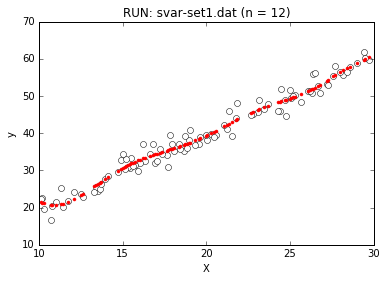

SKLEARN_CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=1.9020780	train_rse_avg=0.0017018	
	test_J_avg=2.3536346	test_rse_avg=0.0021113
RUN: svar-set1.dat (n = 13)
applied to all data (n = 13):
	J=1.9223213	rse=0.0017201
running time: 0.0108098983765


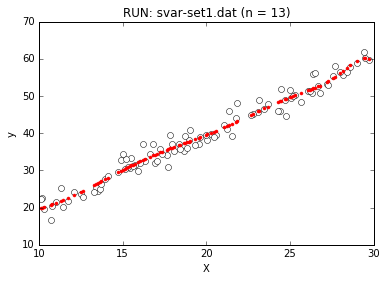

SKLEARN_CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=1.8938826	train_rse_avg=0.0017070	
	test_J_avg=2.4098689	test_rse_avg=0.0021247
RUN: svar-set1.dat (n = 14)
applied to all data (n = 14):
	J=1.9150030	rse=0.0017252
running time: 0.008868932724


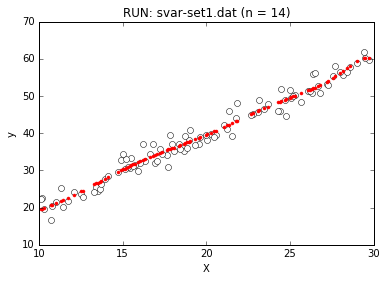

SKLEARN_CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=1.8700763	train_rse_avg=0.0016817	
	test_J_avg=2.5005954	test_rse_avg=0.0021008
RUN: svar-set1.dat (n = 15)
applied to all data (n = 15):
	J=1.8920646	rse=0.0016992
running time: 0.00887608528137


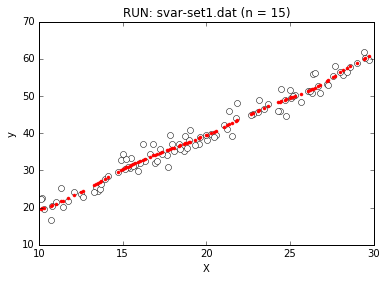

SKLEARN_CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=1.8572082	train_rse_avg=0.0016523	
	test_J_avg=2.7004328	test_rse_avg=0.0020914
RUN: svar-set1.dat (n = 16)
applied to all data (n = 16):
	J=1.8807855	rse=0.0016694
running time: 0.00782799720764


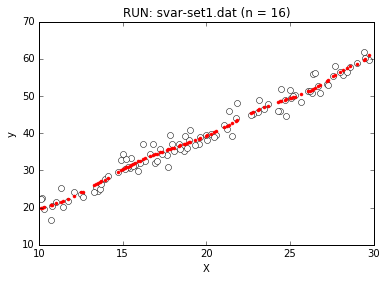

SKLEARN_CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=1.8908453	train_rse_avg=0.0016675	
	test_J_avg=3.1003434	test_rse_avg=0.0021738
RUN: svar-set1.dat (n = 17)
applied to all data (n = 17):
	J=1.9174424	rse=0.0016858
running time: 0.00825595855713


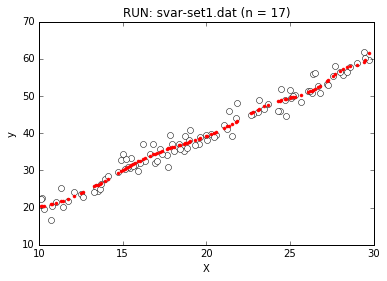

SKLEARN_CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=2.0035209	train_rse_avg=0.0017847	
	test_J_avg=3.7720331	test_rse_avg=0.0024273
RUN: svar-set1.dat (n = 18)
applied to all data (n = 18):
	J=2.0348301	rse=0.0018069
running time: 0.00912094116211


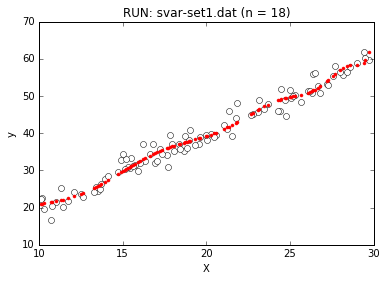

SKLEARN_CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=2.2127592	train_rse_avg=0.0020509	
	test_J_avg=4.7169717	test_rse_avg=0.0028991
RUN: svar-set1.dat (n = 19)
applied to all data (n = 19):
	J=2.2498643	rse=0.0020806
running time: 0.00861716270447


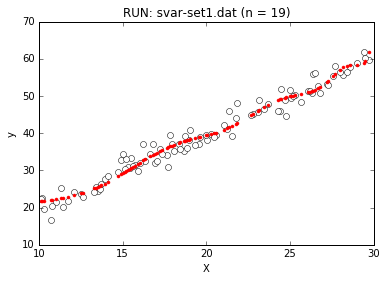

SKLEARN_CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=2.5152033	train_rse_avg=0.0024858	
	test_J_avg=5.8434672	test_rse_avg=0.0035805
RUN: svar-set1.dat (n = 20)
applied to all data (n = 20):
	J=2.5578524	rse=0.0025235
running time: 0.00883388519287


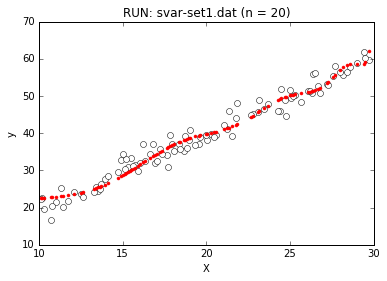

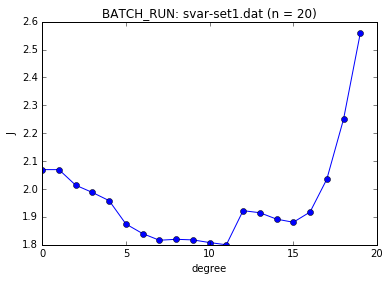

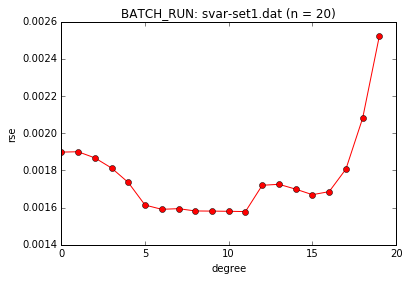

BATCH_RUN: svar-set1.dat (n = 20)
J_min = 1.8000921	n = 12
rse_min = 0.0015786	n = 12
running time: [0.006134033203125, 0.006012916564941406, 0.005827188491821289, 0.0062940120697021484, 0.006250143051147461, 0.008936882019042969, 0.006321907043457031, 0.008517026901245117, 0.007078886032104492, 0.007009983062744141, 0.00835108757019043, 0.007189035415649414, 0.010809898376464844, 0.008868932723999023, 0.00887608528137207, 0.007827997207641602, 0.008255958557128906, 0.009120941162109375, 0.008617162704467773, 0.008833885192871094] 


SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.0286683	train_rse_avg=5.2005515	
	test_J_avg=0.0308225	test_rse_avg=5.6053626
RUN: svar-set2.dat (n = 1)
applied to all data (n = 1):
	J=0.0287758	rse=5.2097647
running time: 0.00675916671753


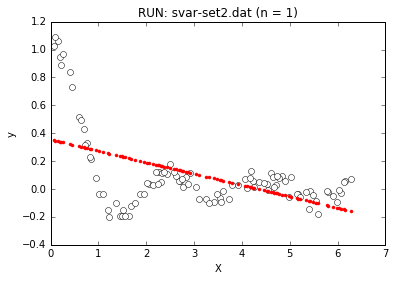

SKLEARN_CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.0183687	train_rse_avg=6.4556556	
	test_J_avg=0.0198116	test_rse_avg=7.3447779
RUN: svar-set2.dat (n = 2)
applied to all data (n = 2):
	J=0.0184402	rse=6.5149939
running time: 0.00572490692139


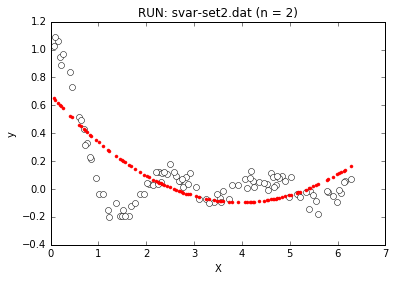

SKLEARN_CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.0094800	train_rse_avg=3.7362961	
	test_J_avg=0.0103021	test_rse_avg=3.8304332
RUN: svar-set2.dat (n = 3)
applied to all data (n = 3):
	J=0.0095203	rse=3.6971767
running time: 0.00545883178711


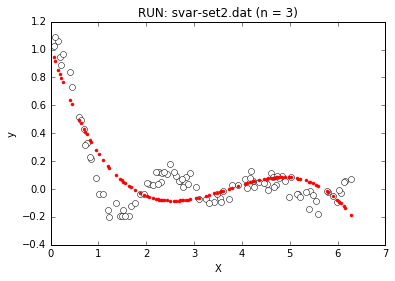

SKLEARN_CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.0045413	train_rse_avg=2.1193901	
	test_J_avg=0.0050205	test_rse_avg=2.2620405
RUN: svar-set2.dat (n = 4)
applied to all data (n = 4):
	J=0.0045647	rse=2.1084881
running time: 0.00556921958923


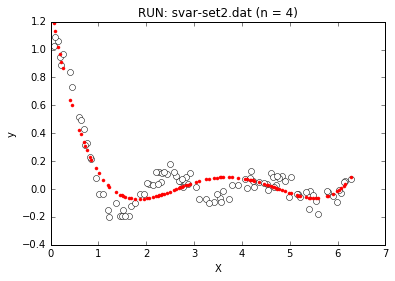

SKLEARN_CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.0043005	train_rse_avg=1.1297810	
	test_J_avg=0.0049440	test_rse_avg=1.0799055
RUN: svar-set2.dat (n = 5)
applied to all data (n = 5):
	J=0.0043313	rse=1.1099932
running time: 0.0078341960907


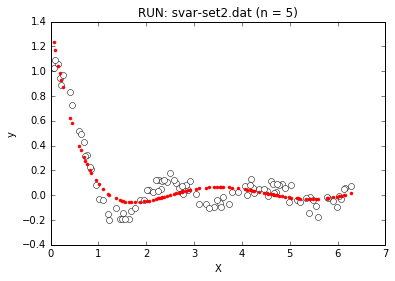

SKLEARN_CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.0042860	train_rse_avg=1.1429967	
	test_J_avg=0.0051383	test_rse_avg=1.1258600
RUN: svar-set2.dat (n = 6)
applied to all data (n = 6):
	J=0.0043253	rse=1.1236189
running time: 0.00854897499084


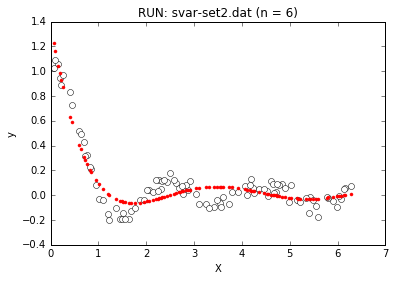

SKLEARN_CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.0021174	train_rse_avg=1.7905264	
	test_J_avg=0.0033269	test_rse_avg=2.5815545
RUN: svar-set2.dat (n = 7)
applied to all data (n = 7):
	J=0.0021606	rse=1.7876160
running time: 0.006756067276


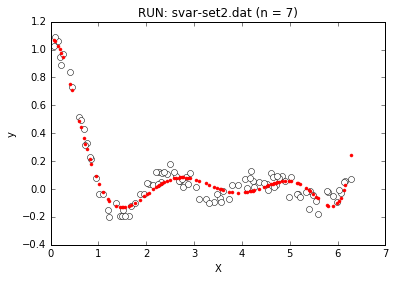

SKLEARN_CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.0012220	train_rse_avg=1.1327665	
	test_J_avg=0.0016415	test_rse_avg=1.3339461
RUN: svar-set2.dat (n = 8)
applied to all data (n = 8):
	J=0.0012404	rse=1.1322852
running time: 0.00756096839905


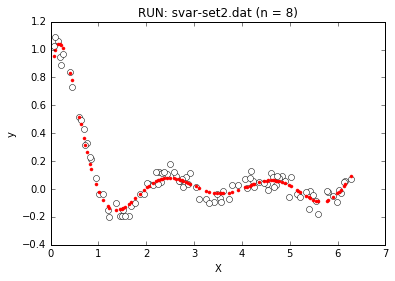

SKLEARN_CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.0010382	train_rse_avg=1.7197498	
	test_J_avg=0.0015506	test_rse_avg=2.2249585
RUN: svar-set2.dat (n = 9)
applied to all data (n = 9):
	J=0.0010567	rse=1.7504877
running time: 0.00651216506958


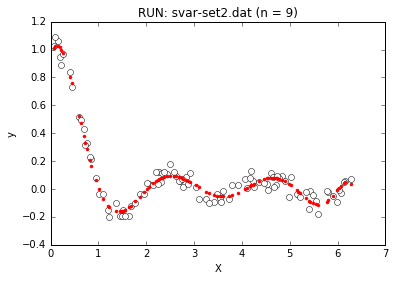

SKLEARN_CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0008055	train_rse_avg=1.5266145	
	test_J_avg=0.0011567	test_rse_avg=1.7036023
RUN: svar-set2.dat (n = 10)
applied to all data (n = 10):
	J=0.0008189	rse=1.5377517
running time: 0.00854802131653


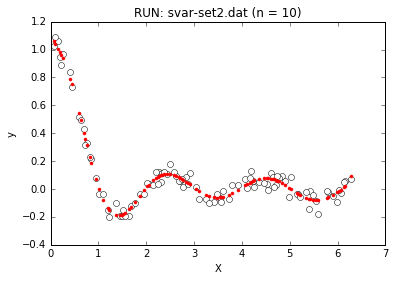

SKLEARN_CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0008036	train_rse_avg=1.5142537	
	test_J_avg=0.0012322	test_rse_avg=1.7414052
RUN: svar-set2.dat (n = 11)
applied to all data (n = 11):
	J=0.0008186	rse=1.5213129
running time: 0.00689005851746


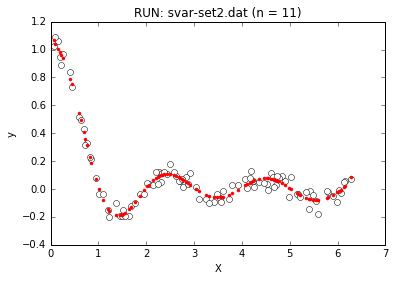

SKLEARN_CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0007869	train_rse_avg=1.5262064	
	test_J_avg=0.0011982	test_rse_avg=1.8587288
RUN: svar-set2.dat (n = 12)
applied to all data (n = 12):
	J=0.0008020	rse=1.5415949
running time: 0.00773811340332


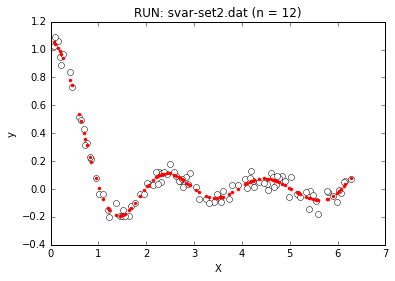

SKLEARN_CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0007842	train_rse_avg=1.5364391	
	test_J_avg=0.0014166	test_rse_avg=1.9743415
RUN: svar-set2.dat (n = 13)
applied to all data (n = 13):
	J=0.0008017	rse=1.5596372
running time: 0.00749611854553


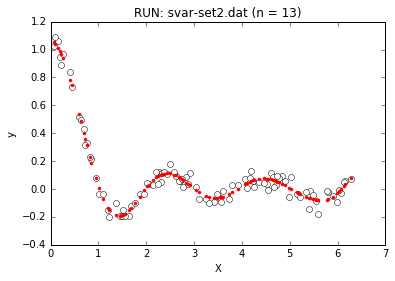

SKLEARN_CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0007711	train_rse_avg=1.4904571	
	test_J_avg=0.0025534	test_rse_avg=2.1258168
RUN: svar-set2.dat (n = 14)
applied to all data (n = 14):
	J=0.0007938	rse=1.5216230
running time: 0.00768613815308


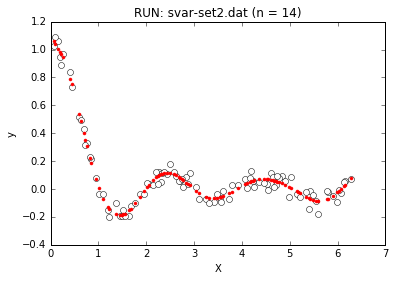

SKLEARN_CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0007699	train_rse_avg=1.5103173	
	test_J_avg=0.0046043	test_rse_avg=2.6027149
RUN: svar-set2.dat (n = 15)
applied to all data (n = 15):
	J=0.0007930	rse=1.5449705
running time: 0.00930094718933


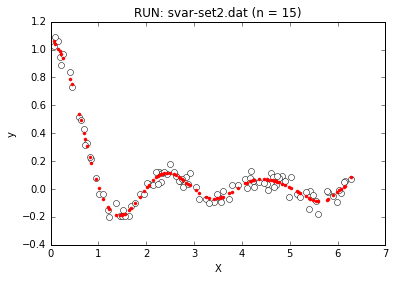

SKLEARN_CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0007741	train_rse_avg=1.4981191	
	test_J_avg=0.0069410	test_rse_avg=3.0560855
RUN: svar-set2.dat (n = 16)
applied to all data (n = 16):
	J=0.0007970	rse=1.5307750
running time: 0.00834989547729


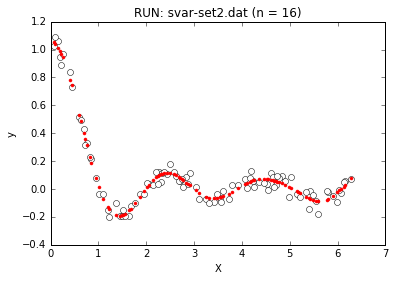

SKLEARN_CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.0007674	train_rse_avg=1.4343031	
	test_J_avg=0.0078711	test_rse_avg=3.1103853
RUN: svar-set2.dat (n = 17)
applied to all data (n = 17):
	J=0.0007888	rse=1.4676708
running time: 0.00991106033325


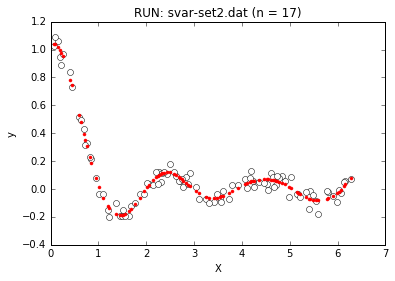

SKLEARN_CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.0008085	train_rse_avg=1.4505698	
	test_J_avg=0.0114523	test_rse_avg=3.7392733
RUN: svar-set2.dat (n = 18)
applied to all data (n = 18):
	J=0.0008369	rse=1.3790716
running time: 0.0138580799103


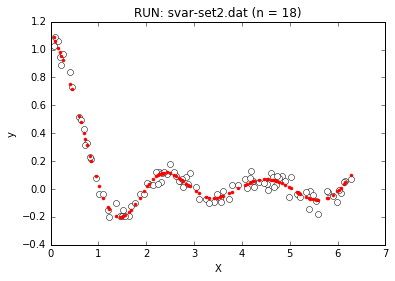

SKLEARN_CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.0013283	train_rse_avg=1.7618150	
	test_J_avg=0.0341226	test_rse_avg=8.5581924
RUN: svar-set2.dat (n = 19)
applied to all data (n = 19):
	J=0.0011133	rse=1.9494969
running time: 0.0163099765778


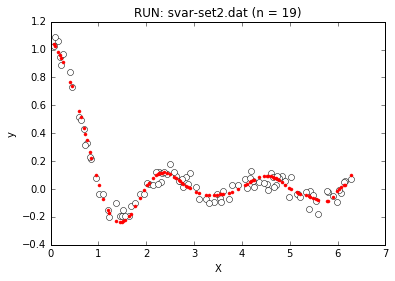

SKLEARN_CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.0135585	train_rse_avg=8.0786228	
	test_J_avg=0.3623992	test_rse_avg=77.8614490
RUN: svar-set2.dat (n = 20)
applied to all data (n = 20):
	J=0.0137950	rse=8.4220543
running time: 0.00968790054321


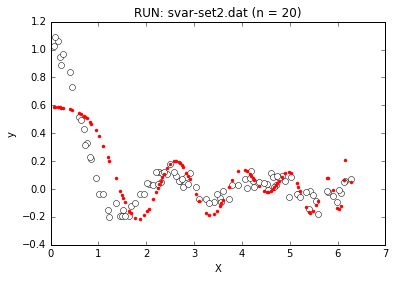

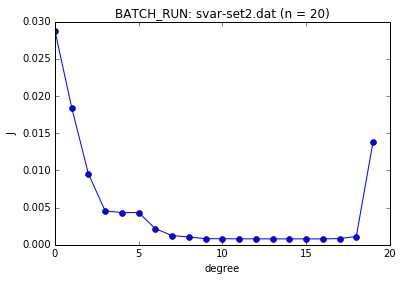

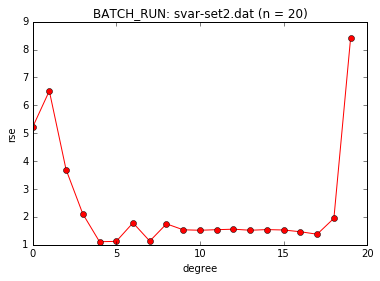

BATCH_RUN: svar-set2.dat (n = 20)
J_min = 0.0007888	n = 17
rse_min = 1.1099932	n = 5
running time: [0.006759166717529297, 0.005724906921386719, 0.005458831787109375, 0.0055692195892333984, 0.007834196090698242, 0.008548974990844727, 0.0067560672760009766, 0.0075609683990478516, 0.006512165069580078, 0.00854802131652832, 0.006890058517456055, 0.0077381134033203125, 0.0074961185455322266, 0.007686138153076172, 0.009300947189331055, 0.008349895477294922, 0.009911060333251953, 0.01385807991027832, 0.01630997657775879, 0.00968790054321289] 


SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.2288148	train_rse_avg=49.9801182	
	test_J_avg=0.2343282	test_rse_avg=53.8409696
RUN: svar-set3.dat (n = 1)
applied to all data (n = 1):
	J=0.2290910	rse=50.1815958
running time: 0.00607895851135


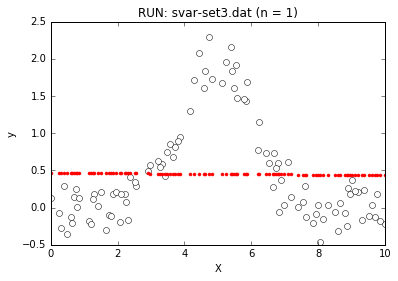

SKLEARN_CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.1148312	train_rse_avg=69.2213625	
	test_J_avg=0.1212989	test_rse_avg=81.6430001
RUN: svar-set3.dat (n = 2)
applied to all data (n = 2):
	J=0.1151508	rse=70.2664711
running time: 0.00628399848938


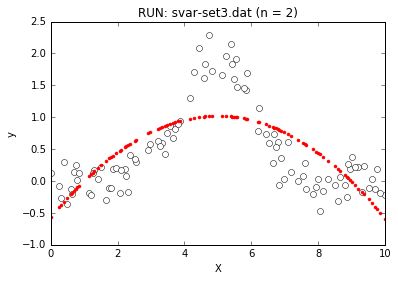

SKLEARN_CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.1142800	train_rse_avg=62.4351871	
	test_J_avg=0.1220732	test_rse_avg=71.6042065
RUN: svar-set3.dat (n = 3)
applied to all data (n = 3):
	J=0.1146650	rse=63.1183518
running time: 0.0056791305542


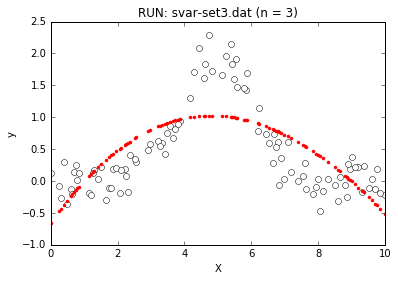

SKLEARN_CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.0557606	train_rse_avg=24.7988956	
	test_J_avg=0.0618210	test_rse_avg=30.2885870
RUN: svar-set3.dat (n = 4)
applied to all data (n = 4):
	J=0.0560557	rse=25.3282794
running time: 0.00559115409851


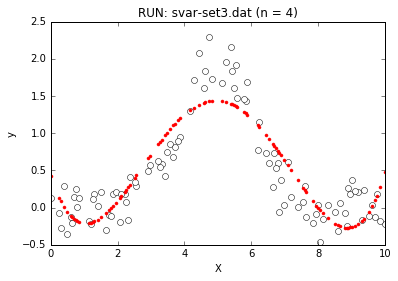

SKLEARN_CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.0551369	train_rse_avg=23.7655279	
	test_J_avg=0.0626400	test_rse_avg=27.6757428
RUN: svar-set3.dat (n = 5)
applied to all data (n = 5):
	J=0.0554907	rse=24.1668667
running time: 0.00703501701355


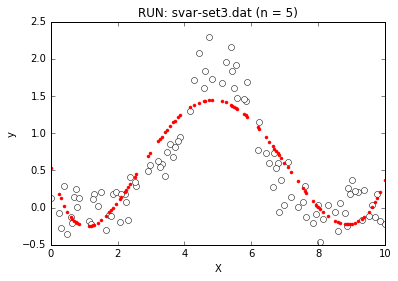

SKLEARN_CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.0272657	train_rse_avg=2.9568053	
	test_J_avg=0.0356761	test_rse_avg=3.3805553
RUN: svar-set3.dat (n = 6)
applied to all data (n = 6):
	J=0.0276046	rse=2.9284690
running time: 0.0072009563446


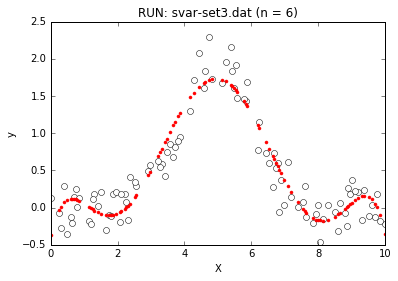

SKLEARN_CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.0258229	train_rse_avg=2.3924741	
	test_J_avg=0.0355266	test_rse_avg=3.4762415
RUN: svar-set3.dat (n = 7)
applied to all data (n = 7):
	J=0.0261758	rse=2.3931988
running time: 0.0060760974884


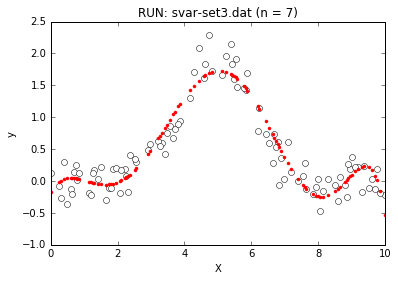

SKLEARN_CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.0205319	train_rse_avg=1.2349465	
	test_J_avg=0.0245126	test_rse_avg=1.7293868
RUN: svar-set3.dat (n = 8)
applied to all data (n = 8):
	J=0.0207178	rse=1.2032168
running time: 0.00887393951416


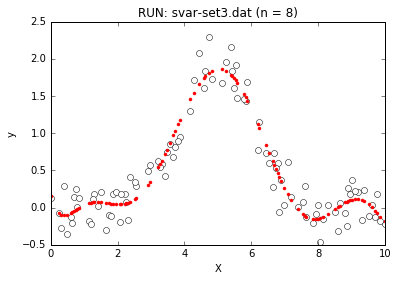

SKLEARN_CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.0204643	train_rse_avg=1.3446330	
	test_J_avg=0.0250438	test_rse_avg=1.8131085
RUN: svar-set3.dat (n = 9)
applied to all data (n = 9):
	J=0.0206779	rse=1.3044434
running time: 0.00892186164856


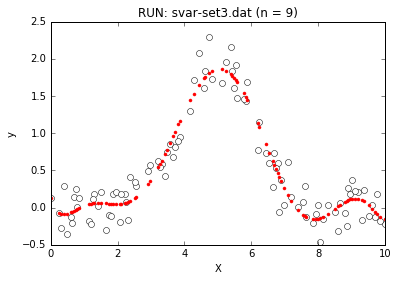

SKLEARN_CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0196447	train_rse_avg=1.1723782	
	test_J_avg=0.0299402	test_rse_avg=1.7099993
RUN: svar-set3.dat (n = 10)
applied to all data (n = 10):
	J=0.0199225	rse=1.1173959
running time: 0.00783586502075


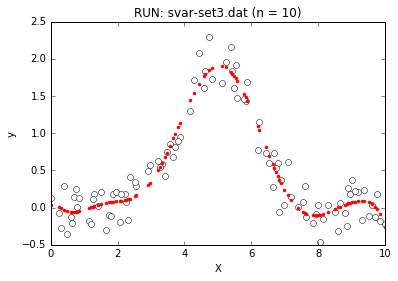

SKLEARN_CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0195779	train_rse_avg=1.0872203	
	test_J_avg=0.0352728	test_rse_avg=1.7413546
RUN: svar-set3.dat (n = 11)
applied to all data (n = 11):
	J=0.0198935	rse=1.0274919
running time: 0.00773000717163


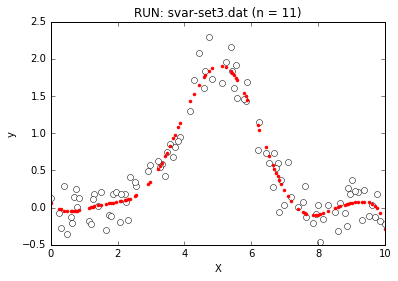

SKLEARN_CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0178130	train_rse_avg=1.7009815	
	test_J_avg=0.0270109	test_rse_avg=1.5394720
RUN: svar-set3.dat (n = 12)
applied to all data (n = 12):
	J=0.0180815	rse=1.5603409
running time: 0.00957894325256


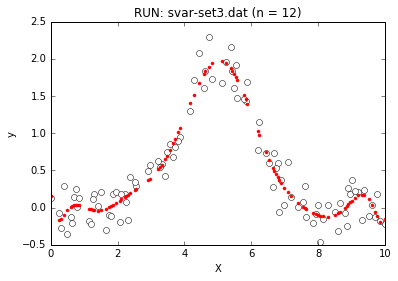

SKLEARN_CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0178052	train_rse_avg=1.7101077	
	test_J_avg=0.0295157	test_rse_avg=1.4194853
RUN: svar-set3.dat (n = 13)
applied to all data (n = 13):
	J=0.0180642	rse=1.5462335
running time: 0.00909519195557


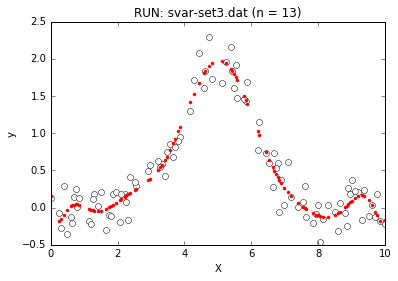

SKLEARN_CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0184268	train_rse_avg=1.6175200	
	test_J_avg=0.0301090	test_rse_avg=1.5598476
RUN: svar-set3.dat (n = 14)
applied to all data (n = 14):
	J=0.0187540	rse=1.4733051
running time: 0.00882411003113


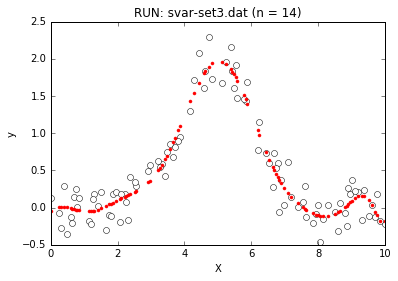

SKLEARN_CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0178989	train_rse_avg=2.4351995	
	test_J_avg=0.0228722	test_rse_avg=1.9099488
RUN: svar-set3.dat (n = 15)
applied to all data (n = 15):
	J=0.0180836	rse=2.3199265
running time: 0.00794291496277


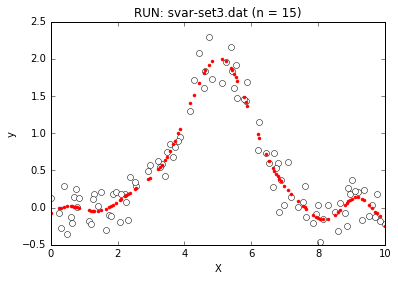

SKLEARN_CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0177257	train_rse_avg=3.2102838	
	test_J_avg=0.0239931	test_rse_avg=2.6584485
RUN: svar-set3.dat (n = 16)
applied to all data (n = 16):
	J=0.0179638	rse=3.0958599
running time: 0.00813102722168


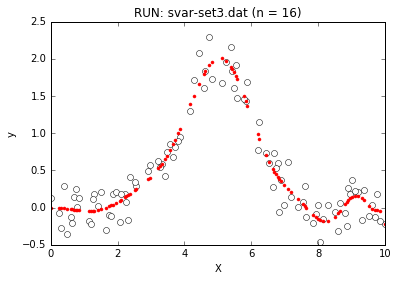

SKLEARN_CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.0178301	train_rse_avg=3.4037382	
	test_J_avg=0.0262131	test_rse_avg=2.9036490
RUN: svar-set3.dat (n = 17)
applied to all data (n = 17):
	J=0.0180495	rse=3.2741782
running time: 0.00814700126648


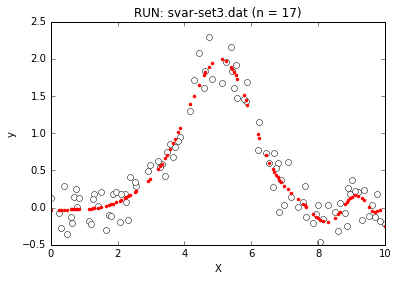

SKLEARN_CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.0180534	train_rse_avg=3.3921779	
	test_J_avg=0.0364718	test_rse_avg=2.9097227
RUN: svar-set3.dat (n = 18)
applied to all data (n = 18):
	J=0.0183053	rse=3.1644136
running time: 0.0103552341461


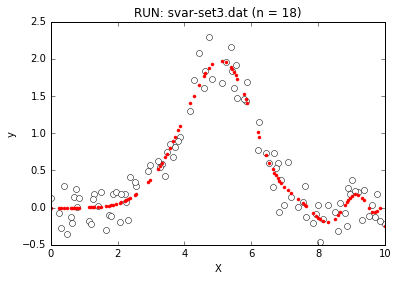

SKLEARN_CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.0187871	train_rse_avg=2.6281862	
	test_J_avg=0.0241247	test_rse_avg=2.2055549
RUN: svar-set3.dat (n = 19)
applied to all data (n = 19):
	J=0.0189881	rse=2.5141586
running time: 0.009122133255


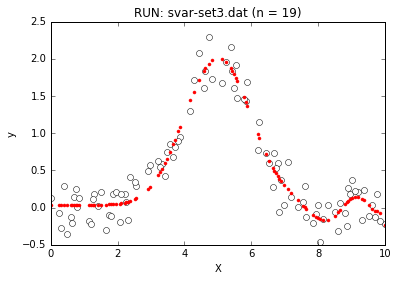

SKLEARN_CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.0195114	train_rse_avg=3.3411876	
	test_J_avg=0.0237144	test_rse_avg=3.0039792
RUN: svar-set3.dat (n = 20)
applied to all data (n = 20):
	J=0.0197035	rse=3.2586786
running time: 0.0107750892639


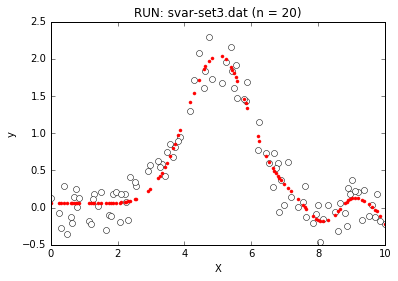

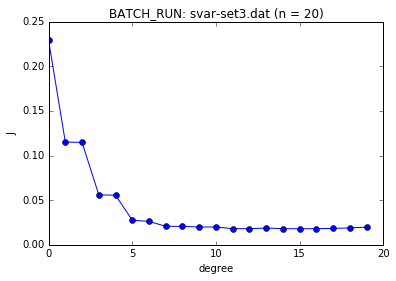

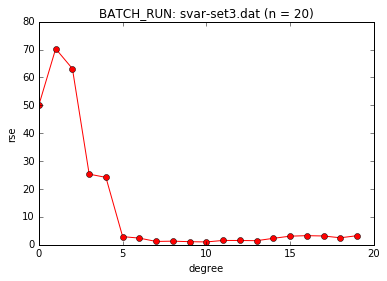

BATCH_RUN: svar-set3.dat (n = 20)
J_min = 0.0179638	n = 16
rse_min = 1.0274919	n = 11
running time: [0.006078958511352539, 0.006283998489379883, 0.005679130554199219, 0.005591154098510742, 0.007035017013549805, 0.007200956344604492, 0.00607609748840332, 0.008873939514160156, 0.00892186164855957, 0.007835865020751953, 0.007730007171630859, 0.009578943252563477, 0.009095191955566406, 0.00882411003112793, 0.007942914962768555, 0.008131027221679688, 0.008147001266479492, 0.010355234146118164, 0.009122133255004883, 0.010775089263916016] 


SKLEARN_CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.5584135	train_rse_avg=71.1031188	
	test_J_avg=0.5826224	test_rse_avg=77.0753268
RUN: svar-set4.dat (n = 1)
applied to all data (n = 1):
	J=0.5595999	rse=71.1868910
running time: 0.00704193115234


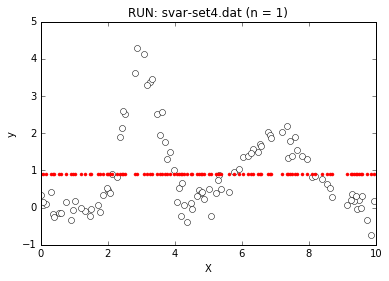

SKLEARN_CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.4460499	train_rse_avg=38.0015449	
	test_J_avg=0.4682255	test_rse_avg=39.6004111
RUN: svar-set4.dat (n = 2)
applied to all data (n = 2):
	J=0.4471481	rse=37.9125617
running time: 0.00707697868347


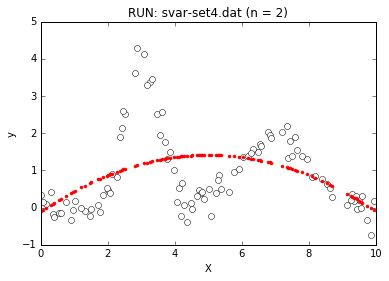

SKLEARN_CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.4443140	train_rse_avg=39.7423176	
	test_J_avg=0.4766730	test_rse_avg=41.9820278
RUN: svar-set4.dat (n = 3)
applied to all data (n = 3):
	J=0.4459183	rse=39.7282392
running time: 0.0103228092194


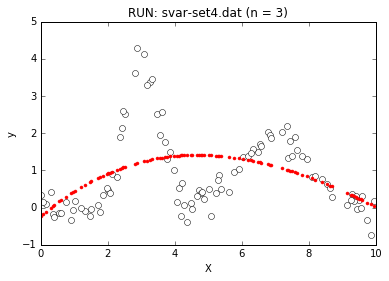

SKLEARN_CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.4120559	train_rse_avg=53.6824282	
	test_J_avg=0.4476551	test_rse_avg=55.0554268
RUN: svar-set4.dat (n = 4)
applied to all data (n = 4):
	J=0.4138121	rse=53.7050457
running time: 0.00576090812683


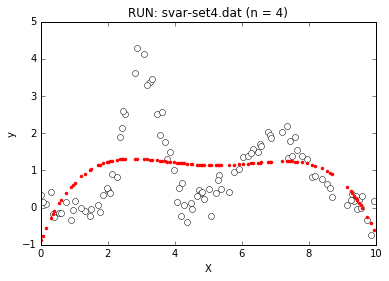

SKLEARN_CROSS_VALIDATION (K = 10) (n = 5):
average results (n = 5):
	train_J_avg=0.3856856	train_rse_avg=35.3217686	
	test_J_avg=0.4374772	test_rse_avg=36.3815835
RUN: svar-set4.dat (n = 5)
applied to all data (n = 5):
	J=0.3881810	rse=35.1514362
running time: 0.0070059299469


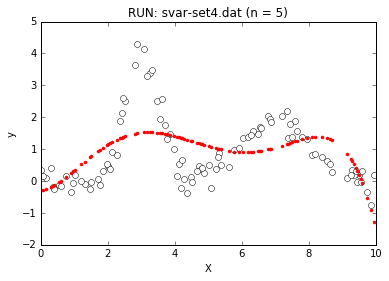

SKLEARN_CROSS_VALIDATION (K = 10) (n = 6):
average results (n = 6):
	train_J_avg=0.2366933	train_rse_avg=13.3493576	
	test_J_avg=0.2747423	test_rse_avg=15.5840402
RUN: svar-set4.dat (n = 6)
applied to all data (n = 6):
	J=0.2384964	rse=13.3370489
running time: 0.00835800170898


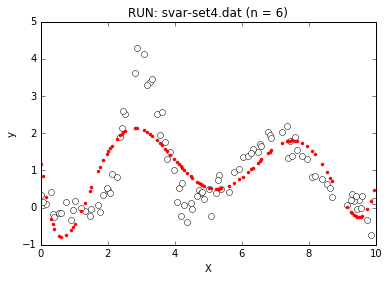

SKLEARN_CROSS_VALIDATION (K = 10) (n = 7):
average results (n = 7):
	train_J_avg=0.2362691	train_rse_avg=13.4455592	
	test_J_avg=0.2825825	test_rse_avg=16.2093688
RUN: svar-set4.dat (n = 7)
applied to all data (n = 7):
	J=0.2384277	rse=13.4301897
running time: 0.00826501846313


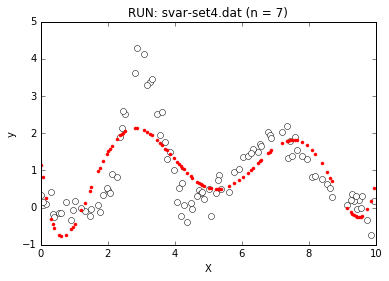

SKLEARN_CROSS_VALIDATION (K = 10) (n = 8):
average results (n = 8):
	train_J_avg=0.1246813	train_rse_avg=15.4516729	
	test_J_avg=0.1705104	test_rse_avg=20.7985409
RUN: svar-set4.dat (n = 8)
applied to all data (n = 8):
	J=0.1264949	rse=15.7266911
running time: 0.00705695152283


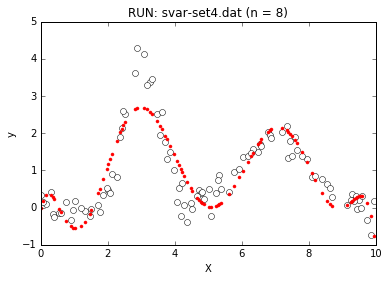

SKLEARN_CROSS_VALIDATION (K = 10) (n = 9):
average results (n = 9):
	train_J_avg=0.1112115	train_rse_avg=24.9546677	
	test_J_avg=0.1598166	test_rse_avg=32.9901679
RUN: svar-set4.dat (n = 9)
applied to all data (n = 9):
	J=0.1130436	rse=25.6327531
running time: 0.00880408287048


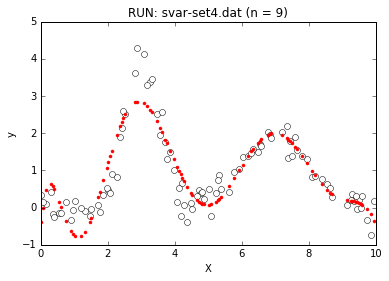

SKLEARN_CROSS_VALIDATION (K = 10) (n = 10):
average results (n = 10):
	train_J_avg=0.0942115	train_rse_avg=11.6080744	
	test_J_avg=0.1201511	test_rse_avg=13.7796045
RUN: svar-set4.dat (n = 10)
applied to all data (n = 10):
	J=0.0953119	rse=11.5578681
running time: 0.00880694389343


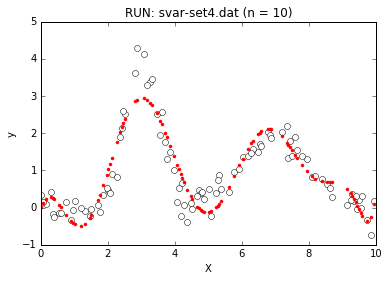

SKLEARN_CROSS_VALIDATION (K = 10) (n = 11):
average results (n = 11):
	train_J_avg=0.0663064	train_rse_avg=7.6370943	
	test_J_avg=0.1312037	test_rse_avg=10.7919967
RUN: svar-set4.dat (n = 11)
applied to all data (n = 11):
	J=0.0681635	rse=7.3944353
running time: 0.00965189933777


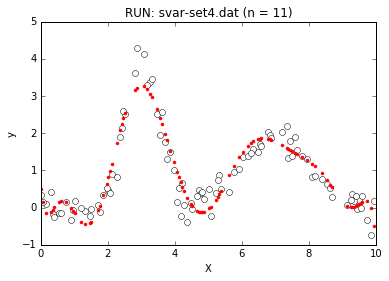

SKLEARN_CROSS_VALIDATION (K = 10) (n = 12):
average results (n = 12):
	train_J_avg=0.0592295	train_rse_avg=10.3109815	
	test_J_avg=0.1068865	test_rse_avg=14.3976959
RUN: svar-set4.dat (n = 12)
applied to all data (n = 12):
	J=0.0606366	rse=10.3974730
running time: 0.00814890861511


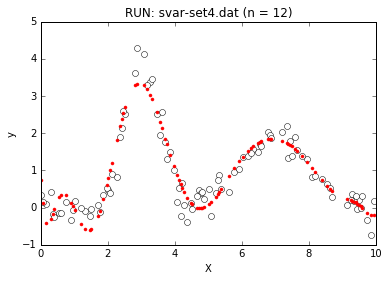

SKLEARN_CROSS_VALIDATION (K = 10) (n = 13):
average results (n = 13):
	train_J_avg=0.0448751	train_rse_avg=3.0232799	
	test_J_avg=0.0593804	test_rse_avg=3.9256820
RUN: svar-set4.dat (n = 13)
applied to all data (n = 13):
	J=0.0455139	rse=2.9616231
running time: 0.0146028995514


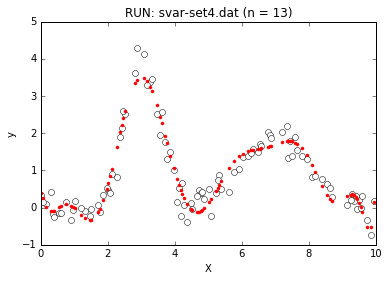

SKLEARN_CROSS_VALIDATION (K = 10) (n = 14):
average results (n = 14):
	train_J_avg=0.0559630	train_rse_avg=7.3093998	
	test_J_avg=0.0754058	test_rse_avg=8.9834978
RUN: svar-set4.dat (n = 14)
applied to all data (n = 14):
	J=0.0568142	rse=7.2989370
running time: 0.00969815254211


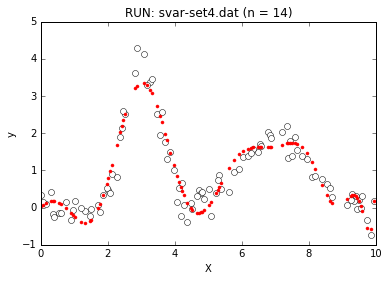

SKLEARN_CROSS_VALIDATION (K = 10) (n = 15):
average results (n = 15):
	train_J_avg=0.0535703	train_rse_avg=11.0092944	
	test_J_avg=0.0807353	test_rse_avg=13.3595106
RUN: svar-set4.dat (n = 15)
applied to all data (n = 15):
	J=0.0527976	rse=9.8328241
running time: 0.0103030204773


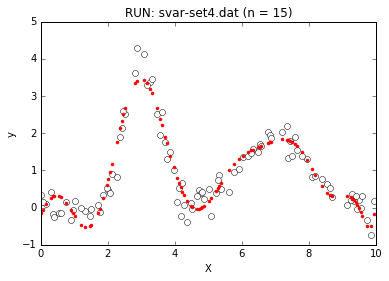

SKLEARN_CROSS_VALIDATION (K = 10) (n = 16):
average results (n = 16):
	train_J_avg=0.0512195	train_rse_avg=10.5709216	
	test_J_avg=0.1346781	test_rse_avg=13.5742858
RUN: svar-set4.dat (n = 16)
applied to all data (n = 16):
	J=0.0515617	rse=10.2668009
running time: 0.0138111114502


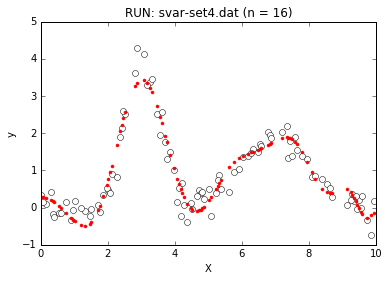

SKLEARN_CROSS_VALIDATION (K = 10) (n = 17):
average results (n = 17):
	train_J_avg=0.0780293	train_rse_avg=2.2681288	
	test_J_avg=0.1631298	test_rse_avg=4.3742525
RUN: svar-set4.dat (n = 17)
applied to all data (n = 17):
	J=0.0795179	rse=2.0940392
running time: 0.0100722312927


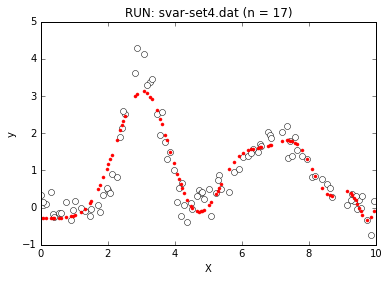

SKLEARN_CROSS_VALIDATION (K = 10) (n = 18):
average results (n = 18):
	train_J_avg=0.0967708	train_rse_avg=2.9034950	
	test_J_avg=0.4988092	test_rse_avg=13.4740228
RUN: svar-set4.dat (n = 18)
applied to all data (n = 18):
	J=0.1013004	rse=2.9455658
running time: 0.00875806808472


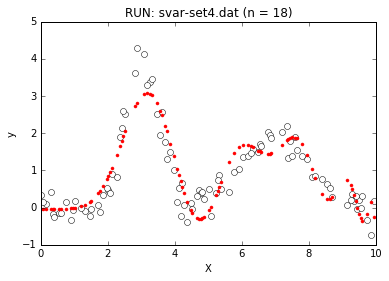

SKLEARN_CROSS_VALIDATION (K = 10) (n = 19):
average results (n = 19):
	train_J_avg=0.3739978	train_rse_avg=46.0458268	
	test_J_avg=0.5073809	test_rse_avg=54.0048998
RUN: svar-set4.dat (n = 19)
applied to all data (n = 19):
	J=0.3768464	rse=46.8094845
running time: 0.00843787193298


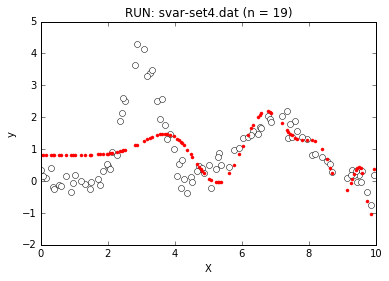

SKLEARN_CROSS_VALIDATION (K = 10) (n = 20):
average results (n = 20):
	train_J_avg=0.4106594	train_rse_avg=56.6629483	
	test_J_avg=0.4949281	test_rse_avg=63.0336004
RUN: svar-set4.dat (n = 20)
applied to all data (n = 20):
	J=0.4126988	rse=57.0371804
running time: 0.0187439918518


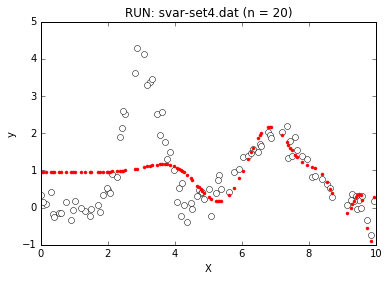

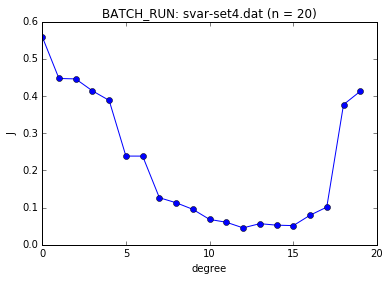

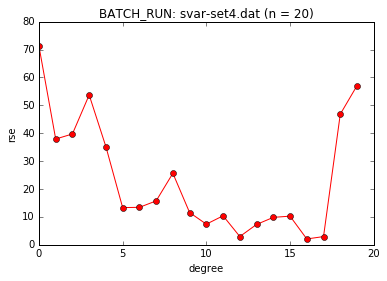

BATCH_RUN: svar-set4.dat (n = 20)
J_min = 0.0455139	n = 13
rse_min = 2.0940392	n = 17
running time: [0.00704193115234375, 0.00707697868347168, 0.010322809219360352, 0.005760908126831055, 0.007005929946899414, 0.008358001708984375, 0.008265018463134766, 0.0070569515228271484, 0.008804082870483398, 0.008806943893432617, 0.009651899337768555, 0.008148908615112305, 0.014602899551391602, 0.009698152542114258, 0.010303020477294922, 0.013811111450195312, 0.01007223129272461, 0.008758068084716797, 0.008437871932983398, 0.01874399185180664] 




In [134]:
# run all datasets, fit sklearn linear regression model with degree from 1 to 20, truncate data to 50%
# plot all results and graphs
batch_run(s_fnames, 'sklearn', 20, truncate=0.5, \
          r_verbose=True, pl_verbose=True, bpl_verbose=True)

# 2. Multivariate regression

#### (a) Load the multiple feature data sets, and map them to a higher dimensional feature space using combination of features.

#### (b) Perform linear regression in the higher dimensional space, Evaluate different mappings in terms of the testing error they produce. Choose a single model and Justify your selection. Compute the mean square error when using the training set and when using the test set.

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.1293361	train_rse_avg=360.4082295	
	test_J_avg=0.1296423	test_rse_avg=375.2359958
RUN: mvar-set1.dat (n = 1)
applied to all data (n = 1):
	J=0.1293514	rse=361.8288696
running time: 0.00731897354126
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.1291610	train_rse_avg=331.5389082	
	test_J_avg=0.1298879	test_rse_avg=355.3820723
RUN: mvar-set1.dat (n = 2)
applied to all data (n = 2):
	J=0.1291973	rse=333.7110219
running time: 0.00883197784424
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.1291316	train_rse_avg=325.3745843	
	test_J_avg=0.1301966	test_rse_avg=342.8463671
RUN: mvar-set1.dat (n = 3)
applied to all data (n = 3):
	J=0.1291847	rse=327.0355973
running time: 0.0108468532562
CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=0.1287080	train_rse_avg=361.0206686	
	test_J_avg=0.1297006	test_rse_avg=359.2957687
RUN: mvar-set1.dat (n = 4

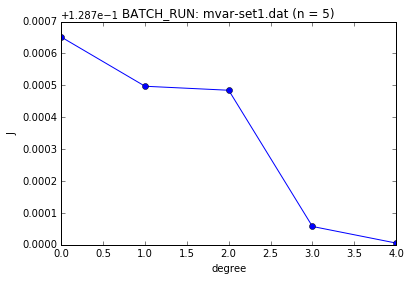

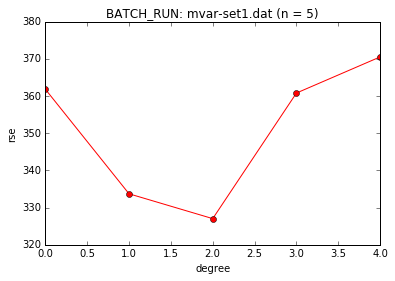

BATCH_RUN: mvar-set1.dat (n = 5)
J_min = 0.1287054	n = 5
rse_min = 327.0355973	n = 3
running time: [0.007318973541259766, 0.008831977844238281, 0.010846853256225586, 0.014140844345092773, 0.01969313621520996] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.0099544	train_rse_avg=2068.3546415	
	test_J_avg=0.0099844	test_rse_avg=2107.1489057
RUN: mvar-set2.dat (n = 1)
applied to all data (n = 1):
	J=0.0099559	rse=2070.6570848
running time: 0.0043740272522
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.0099551	train_rse_avg=2075.8166669	
	test_J_avg=0.0099712	test_rse_avg=2035.1350778
RUN: mvar-set2.dat (n = 2)
applied to all data (n = 2):
	J=0.0099559	rse=2069.9818947
running time: 0.00557112693787
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.0066955	train_rse_avg=7019.8767267	
	test_J_avg=0.0067341	test_rse_avg=6946.6595219
RUN: mvar-set2.dat (n = 3)
applied to all data (n = 3):
	J=0.0066974	rse=7006.

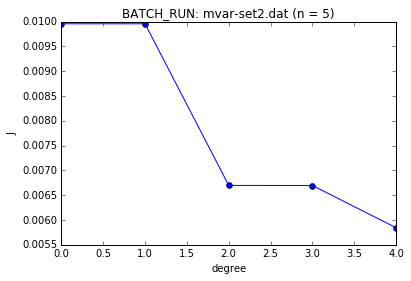

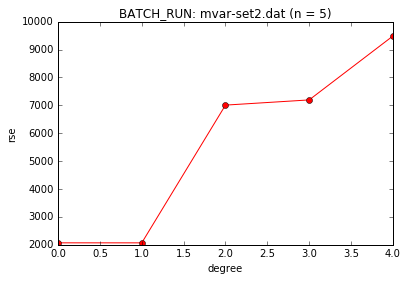

BATCH_RUN: mvar-set2.dat (n = 5)
J_min = 0.0058433	n = 5
rse_min = 2069.9818947	n = 2
running time: [0.004374027252197266, 0.005571126937866211, 0.008754968643188477, 0.012500762939453125, 0.015529155731201172] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.1253708	train_rse_avg=1767.5635246	
	test_J_avg=0.1253855	test_rse_avg=1781.9418229
RUN: mvar-set3.dat (n = 1)
applied to all data (n = 1):
	J=0.1253716	rse=1767.6242337
running time: 0.241888999939
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.1253664	train_rse_avg=1604.5079904	
	test_J_avg=0.1253963	test_rse_avg=1638.3303119
RUN: mvar-set3.dat (n = 2)
applied to all data (n = 2):
	J=0.1253679	rse=1607.0286321
running time: 0.438097000122
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.1253555	train_rse_avg=1530.7531346	
	test_J_avg=0.1254056	test_rse_avg=1610.1606114
RUN: mvar-set3.dat (n = 3)
applied to all data (n = 3):
	J=0.1253580	rse=1536.5

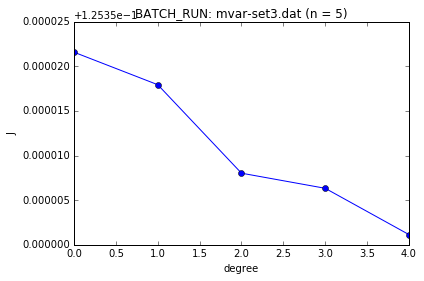

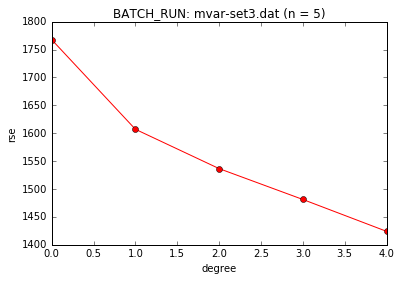

BATCH_RUN: mvar-set3.dat (n = 5)
J_min = 0.1253511	n = 5
rse_min = 1424.1506508	n = 5
running time: [0.24188899993896484, 0.4380970001220703, 0.865044116973877, 1.3560309410095215, 1.8996341228485107] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=0.0020946	train_rse_avg=28604.0763035	
	test_J_avg=0.0020948	test_rse_avg=28009.2614007
RUN: mvar-set4.dat (n = 1)
applied to all data (n = 1):
	J=0.0020946	rse=28540.8761884
running time: 0.228445053101
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=0.0019436	train_rse_avg=398692.0562956	
	test_J_avg=0.0019440	test_rse_avg=392473.7256691
RUN: mvar-set4.dat (n = 2)
applied to all data (n = 2):
	J=0.0019436	rse=398054.0375159
running time: 0.439096927643
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=0.0019435	train_rse_avg=402334.6828772	
	test_J_avg=0.0019440	test_rse_avg=392825.4464926
RUN: mvar-set4.dat (n = 3)
applied to all data (n = 3):
	J=0.0019435	rse=401

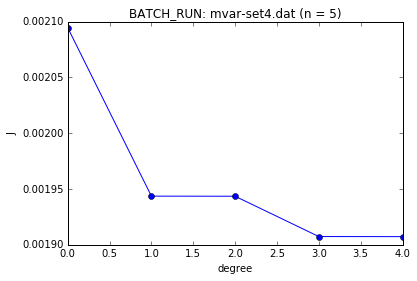

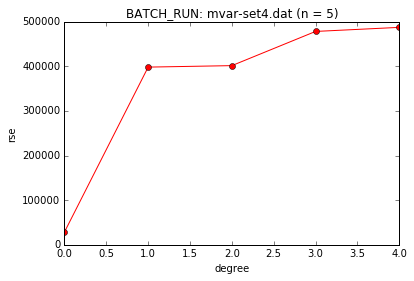

BATCH_RUN: mvar-set4.dat (n = 5)
J_min = 0.0019073	n = 5
rse_min = 28540.8761884	n = 1
running time: [0.22844505310058594, 0.43909692764282227, 0.861929178237915, 1.352808952331543, 1.9798588752746582] 




In [135]:
# run all multivariates datasets, fit linear regression model with degree from 1 to 5
# plot all results and graphs
batch_run(m_fnames, 'explicit', 5, \
          r_verbose=True, bpl_verbose=True)

#### (c) Solve the regression problem using an explicit solution and using an iterative solution. Compare the two solutions.

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=202.8286713	train_rse_avg=572422.3559783	
	test_J_avg=205.9570663	test_rse_avg=1361024.4978712
RUN: mvar-set1.dat (n = 1)
applied to all data (n = 1):
	J=22.8881674	rse=23956.3826203
running time: 0.0709998607635
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=394.2638381	train_rse_avg=1130193.2410242	
	test_J_avg=392.0790274	test_rse_avg=2857234.6983269
RUN: mvar-set1.dat (n = 2)
applied to all data (n = 2):
	J=1029.1894221	rse=2415429.6948611
running time: 0.150083065033
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=1909.0281614	train_rse_avg=6549678.3843818	
	test_J_avg=1935.2356749	test_rse_avg=16272213.8401219
RUN: mvar-set1.dat (n = 3)
applied to all data (n = 3):
	J=4277.3637483	rse=10419433.3813267
running time: 0.0796971321106
CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	train_J_avg=4599.0943461	train_rse_avg=23897547.2366395	
	test_J_avg

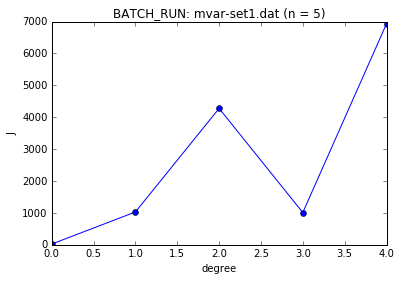

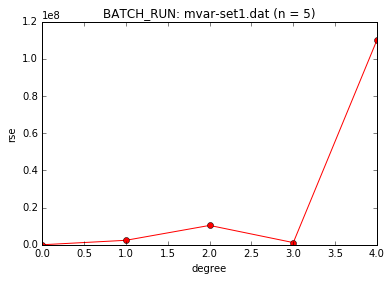

BATCH_RUN: mvar-set1.dat (n = 5)
J_min = 22.8881674	n = 1
rse_min = 23956.3826203	n = 1
running time: [0.0709998607635498, 0.15008306503295898, 0.0796971321105957, 0.10282516479492188, 0.09668397903442383] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=112.8245631	train_rse_avg=190213071.8920090	
	test_J_avg=104.6048386	test_rse_avg=53728940.8753818
RUN: mvar-set2.dat (n = 1)
applied to all data (n = 1):
	J=44.6899099	rse=32183081.5898044
running time: 0.0649518966675
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=545.4377277	train_rse_avg=778321032.4986173	
	test_J_avg=571.3959987	test_rse_avg=347517955.3663061
RUN: mvar-set2.dat (n = 2)
applied to all data (n = 2):
	J=667.8971428	rse=2548598151.4122791
running time: 0.107996940613
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=1347.9727378	train_rse_avg=3362454547.2077131	
	test_J_avg=1332.0776649	test_rse_avg=614305770.1418971
RUN: mvar-set2.dat (n = 3)

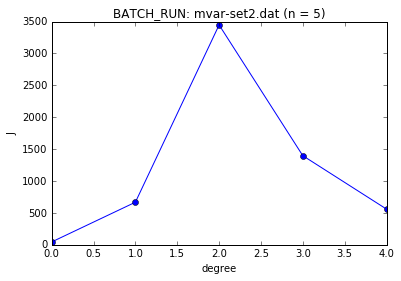

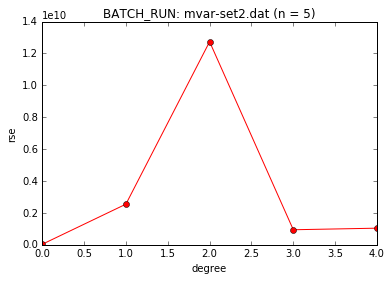

BATCH_RUN: mvar-set2.dat (n = 5)
J_min = 44.6899099	n = 1
rse_min = 32183081.5898044	n = 1
running time: [0.06495189666748047, 0.10799694061279297, 0.07150697708129883, 0.07298517227172852, 0.07330799102783203] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=477.6168061	train_rse_avg=401866174.7810403	
	test_J_avg=474.3067988	test_rse_avg=50304964.3033073
RUN: mvar-set3.dat (n = 1)
applied to all data (n = 1):
	J=455.5522243	rse=343735547.1871337
running time: 2.57862997055
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=1727.7887226	train_rse_avg=2554611509.8350320	
	test_J_avg=1716.0605707	test_rse_avg=20920960.3038750
RUN: mvar-set3.dat (n = 2)
applied to all data (n = 2):
	J=1212.1543571	rse=1317761104.9344943
running time: 2.71088600159
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=6094.4414379	train_rse_avg=11304507464.8149738	
	test_J_avg=6122.7608316	test_rse_avg=3427882605.2362738
RUN: mvar-set3.da

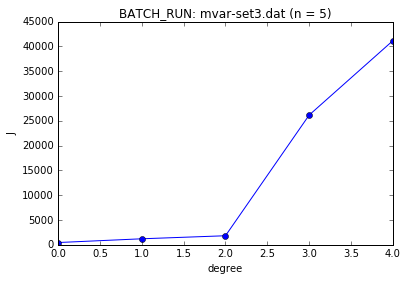

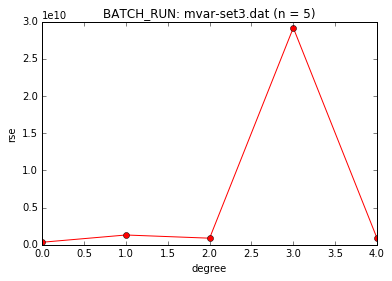

BATCH_RUN: mvar-set3.dat (n = 5)
J_min = 455.5522243	n = 1
rse_min = 343735547.1871337	n = 1
running time: [2.578629970550537, 2.710886001586914, 2.9876351356506348, 3.317218065261841, 3.645366907119751] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=456.5979647	train_rse_avg=116983299049.8673859	
	test_J_avg=459.3192153	test_rse_avg=510657199752.0978394
RUN: mvar-set4.dat (n = 1)
applied to all data (n = 1):
	J=700.2639543	rse=215523990002.5590515
running time: 2.57942795753
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=1346.5216402	train_rse_avg=181292141856.3600159	
	test_J_avg=1352.0719613	test_rse_avg=253460255818.0941467
RUN: mvar-set4.dat (n = 2)
applied to all data (n = 2):
	J=1244.1309442	rse=141254247120.8588867
running time: 2.6913459301
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=6551.0266322	train_rse_avg=392705898896.1884155	
	test_J_avg=6506.1879179	test_rse_avg=425172203514.5186768
RUN:

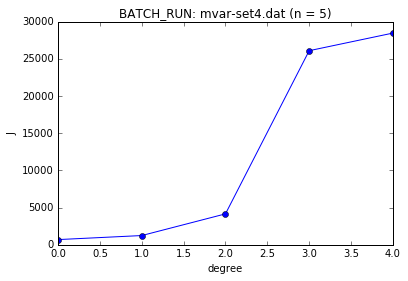

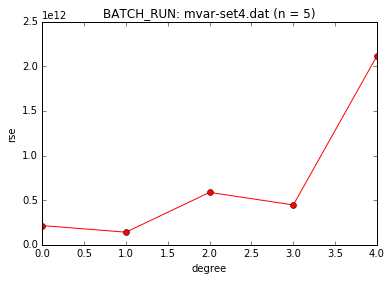

BATCH_RUN: mvar-set4.dat (n = 5)
J_min = 700.2639543	n = 1
rse_min = 141254247120.8588867	n = 2
running time: [2.57942795753479, 2.6913459300994873, 3.0147910118103027, 3.3639090061187744, 3.6426429748535156] 




In [136]:
# run all multivariates datasets, fit linear regression model with stochastic gradient descent, degree from 1 to 5
# plot all results and graphs
batch_run(m_fnames, 'iterative', 5, alpha=0.1 ** 5, epsilon=0.1 ** 4, stochastic=True, \
          r_verbose=True, bpl_verbose=True)

#### (d) Using a Gaussian kernal function, solve the dual linear regression problem. Compare the time performance and accuracy of the dual regression and primal regression problem you solved earlier.

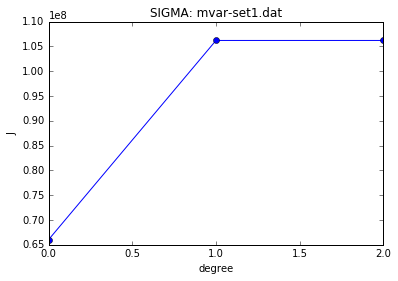

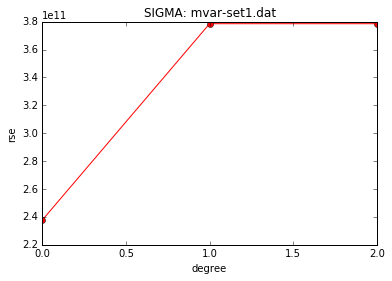

EPSILON:  mvar-set1.dat
J_min = 66036217.5190033	J_idx = 0
rse_min = 237669102794.0010376	J_idx = 0


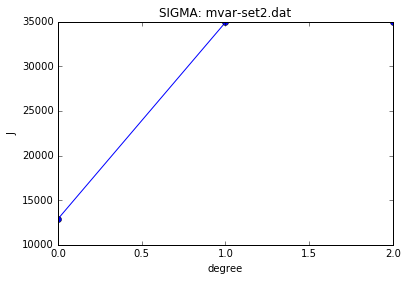

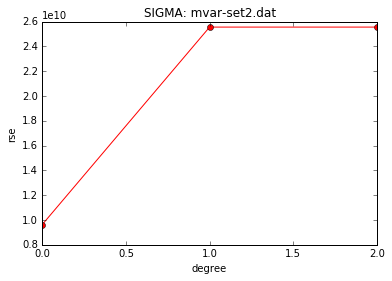

EPSILON:  mvar-set2.dat
J_min = 12911.9211948	J_idx = 0
rse_min = 9626560015.2140369	J_idx = 0


In [169]:
# try different sigma (0.1 - 0.0001)
for fname in m_fnames[:2]:
    Js = []
    rses = []

    for i in range(1, 4):
        J, rse, duration = run(fname, 'explicit', 2, sigma=0.1 ** i)
        Js.append(J)
        rses.append(rse)

    plt.plot(range(len(Js)), Js, 'bo-')
    plt.title('SIGMA: ' + fname)
    plt.xlabel('degree')
    plt.ylabel('J')
    plt.show()

    plt.plot(range(len(rses)), rses, 'ro-')
    plt.title('SIGMA: ' + fname)
    plt.xlabel('degree')
    plt.ylabel('rse')
    plt.show()

    J_idx = Js.index(min(Js))
    rse_idx = rses.index(min(rses))

    print 'EPSILON: ', fname
    print 'J_min = %.7f\t' % Js[J_idx], 'J_idx = %d' % J_idx
    print 'rse_min = %.7f\t' % rses[rse_idx], 'J_idx = %d' % rse_idx

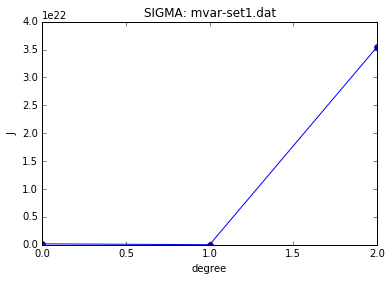

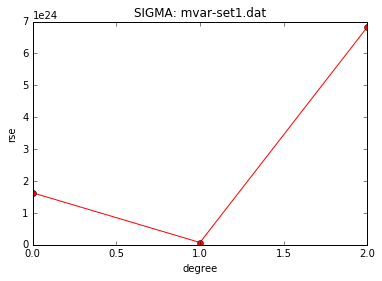

EPSILON:  mvar-set1.dat
J_min = 18344847154473512960.0000000	J_idx = 1
rse_min = 71949581007041127776256.0000000	J_idx = 1


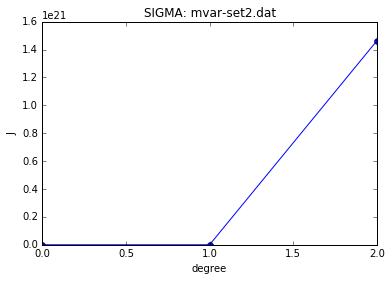

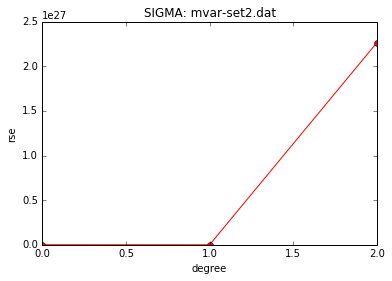

EPSILON:  mvar-set2.dat
J_min = 282506304574316768.0000000	J_idx = 1
rse_min = 283401606516936217198592.0000000	J_idx = 1


In [32]:
# try different sigma (10 - 1000)
for fname in m_fnames[:2]:
    Js = []
    rses = []

    for i in range(1, 4):
        J, rse, duration = run(fname, 'explicit', 2, sigma=10 ** i)
        Js.append(J)
        rses.append(rse)

    plt.plot(range(len(Js)), Js, 'bo-')
    plt.title('SIGMA: ' + fname)
    plt.xlabel('degree')
    plt.ylabel('J')
    plt.show()

    plt.plot(range(len(rses)), rses, 'ro-')
    plt.title('SIGMA: ' + fname)
    plt.xlabel('degree')
    plt.ylabel('rse')
    plt.show()

    J_idx = Js.index(min(Js))
    rse_idx = rses.index(min(rses))

    print 'EPSILON: ', fname
    print 'J_min = %.7f\t' % Js[J_idx], 'J_idx = %d' % J_idx
    print 'rse_min = %.7f\t' % rses[rse_idx], 'J_idx = %d' % rse_idx

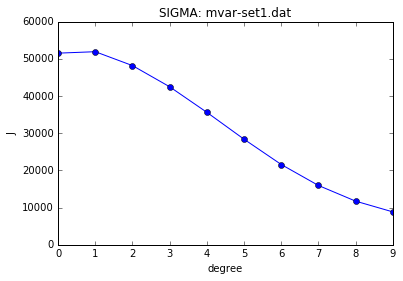

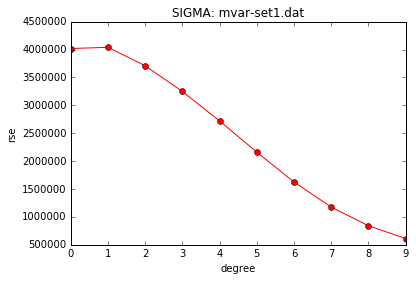

EPSILON:  mvar-set1.dat
J_min = 8842.8540765	J_idx = 9
rse_min = 612105.1094346	J_idx = 9


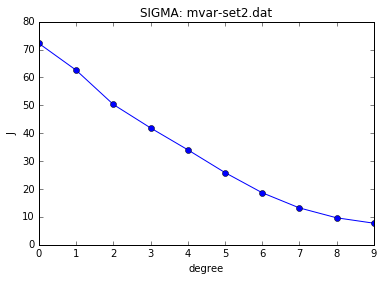

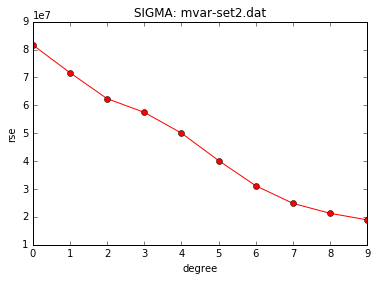

EPSILON:  mvar-set2.dat
J_min = 7.7464149	J_idx = 9
rse_min = 18930472.5406759	J_idx = 9


In [171]:
# try different sigma (0.1 - 1)
for fname in m_fnames[:2]:
    Js = []
    rses = []

    for i in range(1, 11):
        J, rse, duration = run(fname, 'explicit', 2, truncate=0.03, sigma=0.1 * i)
        Js.append(J)
        rses.append(rse)

    plt.plot(range(len(Js)), Js, 'bo-')
    plt.title('SIGMA: ' + fname)
    plt.xlabel('degree')
    plt.ylabel('J')
    plt.show()

    plt.plot(range(len(rses)), rses, 'ro-')
    plt.title('SIGMA: ' + fname)
    plt.xlabel('degree')
    plt.ylabel('rse')
    plt.show()

    J_idx = Js.index(min(Js))
    rse_idx = rses.index(min(rses))

    print 'EPSILON: ', fname
    print 'J_min = %.7f\t' % Js[J_idx], 'J_idx = %d' % J_idx
    print 'rse_min = %.7f\t' % rses[rse_idx], 'J_idx = %d' % rse_idx

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=670028188885652078592.0000000	train_rse_avg=3410170167060686459371520.0000000	
	test_J_avg=727507128992269205504.0000000	test_rse_avg=229800095436835867590656.0000000
RUN: mvar-set1.dat (n = 1)
applied to all data (n = 1):
	J=1457441315670978304.0000000	rse=1317034329271323328512.0000000
running time: 5.7227230072
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=1188869828564594196480.0000000	train_rse_avg=8319449195280136910405632.0000000	
	test_J_avg=990923141077480505344.0000000	test_rse_avg=80065697446519684202496.0000000
RUN: mvar-set1.dat (n = 2)
applied to all data (n = 2):
	J=581133909784591616.0000000	rse=1462229076651040047104.0000000
running time: 5.86933588982
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=119883959854760032.0000000	train_rse_avg=712024198708490665984.0000000	
	test_J_avg=112373881877913984.0000000	test_rse_avg=2301542222125451968512.00

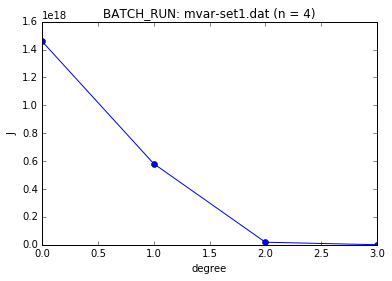

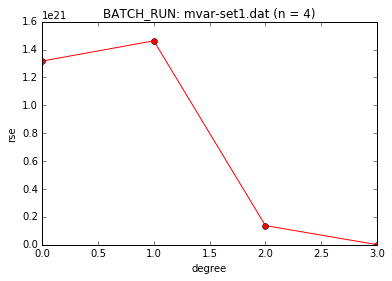

BATCH_RUN: mvar-set1.dat (n = 4)
J_min = 695371634254531.1250000	n = 4
rse_min = 1087127567223539200.0000000	n = 4
running time: [5.722723007202148, 5.869335889816284, 6.991420030593872, 6.544603109359741] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=105921797478896816.0000000	train_rse_avg=262444354290795732271104.0000000	
	test_J_avg=109446056400618336.0000000	test_rse_avg=43454561287936231342080.0000000
RUN: mvar-set2.dat (n = 1)
applied to all data (n = 1):
	J=339513706050613.0625000	rse=500416148687933865984.0000000
running time: 6.17938995361
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=2230725966970104576.0000000	train_rse_avg=3827330577347763566018560.0000000	
	test_J_avg=2124469737318087936.0000000	test_rse_avg=541940131544433931845632.0000000
RUN: mvar-set2.dat (n = 2)
applied to all data (n = 2):
	J=3177034497238459.0000000	rse=6280256745601955266560.0000000
running time: 6.42620801926
CROSS_VALIDATION (K = 10) (n = 

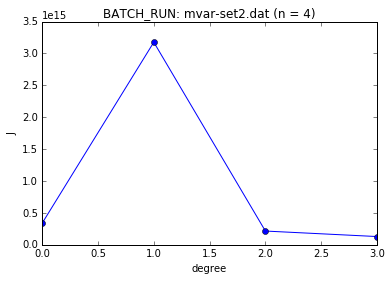

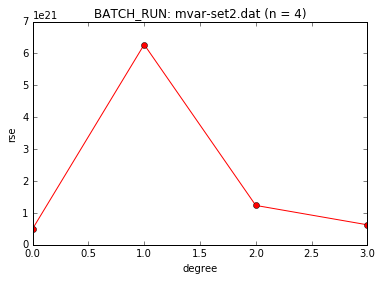

BATCH_RUN: mvar-set2.dat (n = 4)
J_min = 129413924462165.8593750	n = 4
rse_min = 500416148687933865984.0000000	n = 1
running time: [6.179389953613281, 6.426208019256592, 6.197997093200684, 6.231640100479126] 




In [139]:
# run all first two multivariates datasets
# fit dual linear regression model with degree from 1 to r, sigma=1.0
# plot all results and graphs
batch_run(m_fnames[:2], 'explicit', 4, sigma=1.0, r_verbose=True, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=2956521324727686144.0000000	train_rse_avg=1787560211291810824192.0000000	
	test_J_avg=3146058841344267776.0000000	test_rse_avg=53547564207191957504.0000000
RUN: mvar-set1.dat (n = 1)
applied to all data (n = 1):
	J=137457019128856297472.0000000	rse=446841890266465334984704.0000000
running time: 4.84992003441
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=32590269886669.7421875	train_rse_avg=111145492382160560.0000000	
	test_J_avg=32984629074578.4687500	test_rse_avg=207011910160678912.0000000
RUN: mvar-set1.dat (n = 2)
applied to all data (n = 2):
	J=13940219883480.9218750	rse=677791823600182.1250000
running time: 5.6183578968
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=6467699818781.7851562	train_rse_avg=24167961430738316.0000000	
	test_J_avg=6680435236489.5253906	test_rse_avg=221833427066713440.0000000
RUN: mvar-set1.dat (n = 3)
applied to all data (n = 3):
	

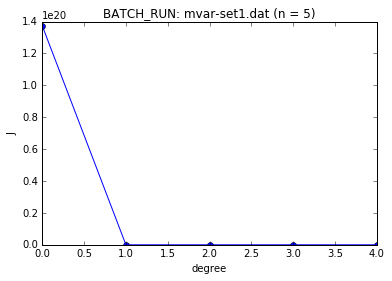

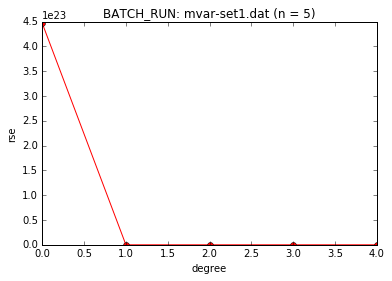

BATCH_RUN: mvar-set1.dat (n = 5)
J_min = 121684586.7192356	n = 3
rse_min = 6438470182.5554018	n = 3
running time: [4.849920034408569, 5.61835789680481, 5.749138832092285, 6.971886157989502, 31.392091035842896] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=45486183264661656.0000000	train_rse_avg=78233294592306327846912.0000000	
	test_J_avg=45990295065831544.0000000	test_rse_avg=16732237065648284368896.0000000
RUN: mvar-set2.dat (n = 1)
applied to all data (n = 1):
	J=65285574451604360.0000000	rse=130845664093622566387712.0000000
running time: 5.4446709156
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=615886523828.8566895	train_rse_avg=737160255444754816.0000000	
	test_J_avg=616932318818.0675049	test_rse_avg=3753082949420937216.0000000
RUN: mvar-set2.dat (n = 2)
applied to all data (n = 2):
	J=1677136420310.9938965	rse=4957907967026520064.0000000
running time: 5.65098404884
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3)

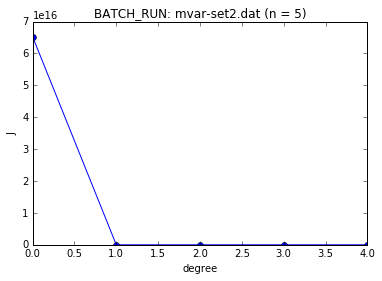

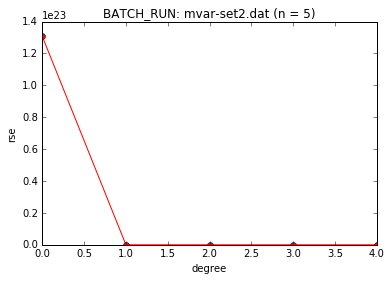

BATCH_RUN: mvar-set2.dat (n = 5)
J_min = 22010.8303697	n = 4
rse_min = 72511460314.0558624	n = 4
running time: [5.444670915603638, 5.650984048843384, 5.692847013473511, 7.5043721199035645, 32.12519407272339] 




In [137]:
# run all first two multivariates datasets
# fit dual linear regression model with degree from 1 to r, sigma=0.5
# plot all results and graphs
batch_run(m_fnames[:2], 'explicit', 4, sigma=0.5, r_verbose=True, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=114325952306254336.0000000	train_rse_avg=634028661670426968064.0000000	
	test_J_avg=119235795029726624.0000000	test_rse_avg=17901613989985507328.0000000
RUN: mvar-set1.dat (n = 1)
applied to all data (n = 1):
	J=20750615120895116.0000000	rse=85355818446403452928.0000000
running time: 4.68170309067
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=4462886.8806719	train_rse_avg=17862912446.9144554	
	test_J_avg=4442319.1188147	test_rse_avg=8463917138.7798824
RUN: mvar-set1.dat (n = 2)
applied to all data (n = 2):
	J=3497131.0920753	rse=12782996415.3123989
running time: 5.21068096161
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=304758357.3424045	train_rse_avg=24305303623.6295700	
	test_J_avg=302164891.2677428	test_rse_avg=5326457755.9206409
RUN: mvar-set1.dat (n = 3)
applied to all data (n = 3):
	J=334059453.3237417	rse=8930482160.3208542
running time: 6.63253903389
C

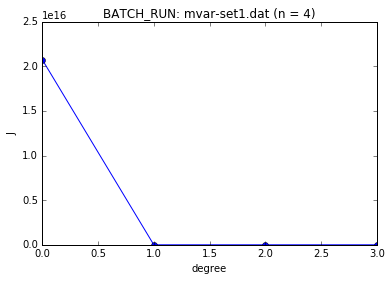

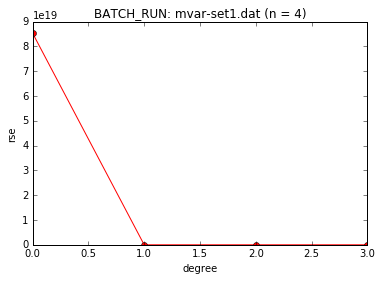

BATCH_RUN: mvar-set1.dat (n = 4)
J_min = 3497131.0920753	n = 2
rse_min = 8930482160.3208542	n = 3
running time: [4.681703090667725, 5.210680961608887, 6.6325390338897705, 20.94023108482361] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=447260056474862.0625000	train_rse_avg=576564350223135211520.0000000	
	test_J_avg=460752816510253.6250000	test_rse_avg=4271880448852249018368.0000000
RUN: mvar-set2.dat (n = 1)
applied to all data (n = 1):
	J=71008505583883.8593750	rse=174672960286992793600.0000000
running time: 6.49500989914
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=3320.6542861	train_rse_avg=3900396242.0884314	
	test_J_avg=3314.9896550	test_rse_avg=1788185739.8832085
RUN: mvar-set2.dat (n = 2)
applied to all data (n = 2):
	J=288.9125067	rse=220229352.2931253
running time: 6.43061089516
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=105835.9040333	train_rse_avg=189428901185.2466125	
	test_J_avg=112421.

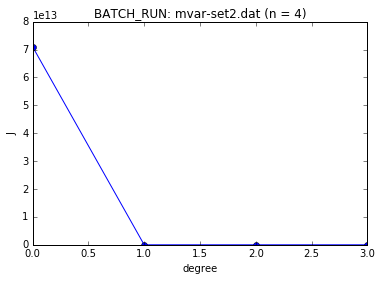

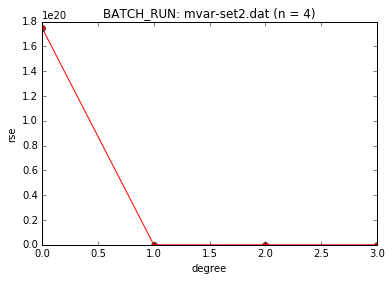

BATCH_RUN: mvar-set2.dat (n = 4)
J_min = 288.9125067	n = 2
rse_min = 220229352.2931253	n = 2
running time: [6.495009899139404, 6.43061089515686, 7.164928913116455, 20.840436935424805] 




In [27]:
# run all first two multivariates datasets
# fit dual linear regression model with degree from 1 to r, sigma=0.3
# plot all results and graphs
batch_run(m_fnames[:2], 'explicit', 4, sigma=0.3, r_verbose=True, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=1003809.8920651	train_rse_avg=78182131.2163554	
	test_J_avg=1003352.1990555	test_rse_avg=78618858.0268393
RUN: mvar-set1.dat (n = 1)
applied to all data (n = 1):
	J=1020617.9590138	rse=79757336.5691438
running time: 5.30655908585
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=55727828.4107478	train_rse_avg=200492738199.5550842	
	test_J_avg=55575249.7331403	test_rse_avg=199168915127.5007324
RUN: mvar-set1.dat (n = 2)
applied to all data (n = 2):
	J=66036217.5190033	rse=237669102794.0010376
running time: 11.5161159039
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=671728961.4658854	train_rse_avg=11641522243.2386436	
	test_J_avg=668186689.2618682	test_rse_avg=11080396642.6692810
RUN: mvar-set1.dat (n = 3)
applied to all data (n = 3):
	J=809215530.1192247	rse=13646349049.7663212
running time: 48.2260150909
CROSS_VALIDATION (K = 10) (n = 4):
average results (n = 4):
	

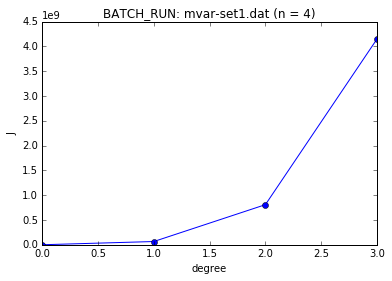

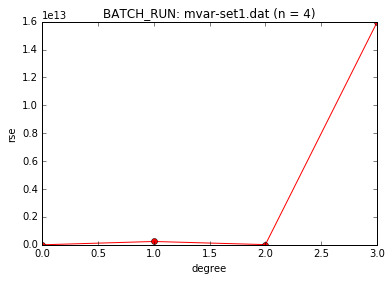

BATCH_RUN: mvar-set1.dat (n = 4)
J_min = 1020617.9590138	n = 1
rse_min = 79757336.5691438	n = 1
running time: [5.306559085845947, 11.51611590385437, 48.22601509094238, 18.187160968780518] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=1575.9020651	train_rse_avg=1160116443.6679690	
	test_J_avg=1575.3227983	test_rse_avg=1154745786.8762374
RUN: mvar-set2.dat (n = 1)
applied to all data (n = 1):
	J=1593.0793671	rse=1174526269.7126796
running time: 5.97690296173
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=11418.0619436	train_rse_avg=8507929637.2965603	
	test_J_avg=11385.2932839	test_rse_avg=8534255136.1887951
RUN: mvar-set2.dat (n = 2)
applied to all data (n = 2):
	J=12911.9211948	rse=9626560015.2140369
running time: 11.6037299633
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=330353.9494529	train_rse_avg=160463876930.7758484	
	test_J_avg=330582.1001406	test_rse_avg=159068243807.3128967
RUN: mvar-set2.dat (n

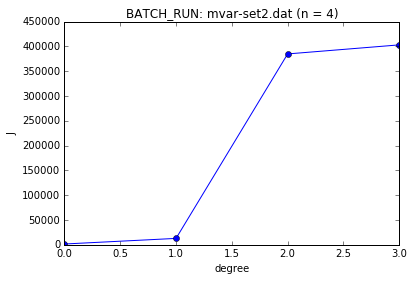

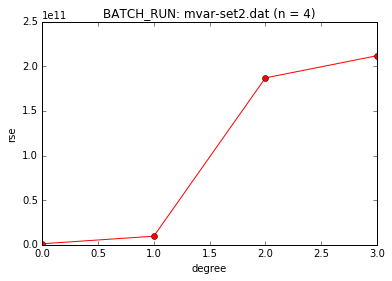

BATCH_RUN: mvar-set2.dat (n = 4)
J_min = 1593.0793671	n = 1
rse_min = 1174526269.7126796	n = 1
running time: [5.976902961730957, 11.603729963302612, 47.725635051727295, 18.141860961914062] 




In [138]:
# run all first two multivariates datasets
# fit dual linear regression model with degree from 1 to r, sigma=0.1
# plot all results and graphs
batch_run(m_fnames[:2], 'explicit', 4, sigma=0.1, r_verbose=True, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=15878617.7628447	train_rse_avg=1325286641.6673267	
	test_J_avg=15809616.4640172	test_rse_avg=1379906315.5066874
RUN: mvar-set1.dat (n = 1)
applied to all data (n = 1):
	J=19591750.7025947	rse=1640932318.2028282
running time: 4.86586999893
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=86078750.2529618	train_rse_avg=303779940977.1246338	
	test_J_avg=85772205.2224547	test_rse_avg=333005445382.2936401
RUN: mvar-set1.dat (n = 2)
applied to all data (n = 2):
	J=106197992.2074331	rse=378487423603.6662598
running time: 5.15591716766
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=871376755.3481109	train_rse_avg=14280620670.2709961	
	test_J_avg=868024928.8803917	test_rse_avg=10006984267.2858315
RUN: mvar-set1.dat (n = 3)
applied to all data (n = 3):
	J=1075195191.2162805	rse=16166268528.0554066
running time: 5.03806805611
CROSS_VALIDATION (K = 10) (n = 4):
average results

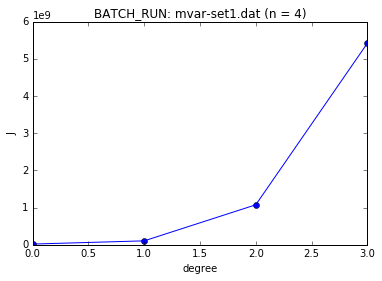

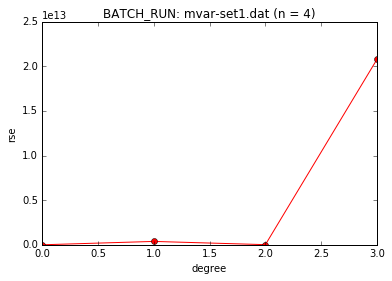

BATCH_RUN: mvar-set1.dat (n = 4)
J_min = 19591750.7025947	n = 1
rse_min = 1640932318.2028282	n = 1
running time: [4.865869998931885, 5.155917167663574, 5.038068056106567, 5.207916975021362] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=28214.2205388	train_rse_avg=20189895537.5783501	
	test_J_avg=28180.9372835	test_rse_avg=20141693443.7347984
RUN: mvar-set2.dat (n = 1)
applied to all data (n = 1):
	J=34821.3752606	rse=24904846253.6220703
running time: 5.22860193253
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=28308.2957450	train_rse_avg=20758674869.4090500	
	test_J_avg=28244.0842711	test_rse_avg=20435756248.6358261
RUN: mvar-set2.dat (n = 2)
applied to all data (n = 2):
	J=34920.5561386	rse=25557292820.0107269
running time: 5.44636106491
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=594837.6057311	train_rse_avg=284274310985.8860474	
	test_J_avg=593839.9630409	test_rse_avg=286401409873.6291504
RUN: mvar-

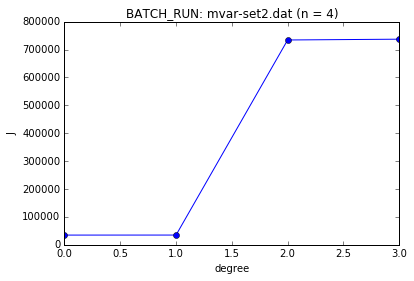

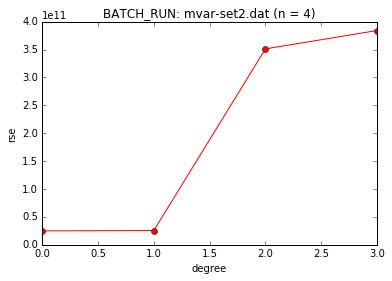

BATCH_RUN: mvar-set2.dat (n = 4)
J_min = 34821.3752606	n = 1
rse_min = 24904846253.6220703	n = 1
running time: [5.228601932525635, 5.446361064910889, 5.645294904708862, 5.812044858932495] 




In [140]:
# run all first two multivariates datasets
# fit dual linear regression model with degree from 1 to r, sigma=0.01
# plot all results and graphs
batch_run(m_fnames[:2], 'explicit', 4, sigma=0.01, r_verbose=True, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=26923038189520007725056.0000000	train_rse_avg=10396609344287160286576640.0000000	
	test_J_avg=26955193125202009522176.0000000	test_rse_avg=1321519929588372541014016.0000000
RUN: mvar-set3.dat (n = 1)
applied to all data (n = 1):
	J=184055979523996712960.0000000	rse=814716712269599584813056.0000000
running time: 5.02486205101
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=35918571911.1312485	train_rse_avg=136487563771772.6718750	
	test_J_avg=35271816536.6593781	test_rse_avg=11020066343167.2460938
RUN: mvar-set3.dat (n = 2)
applied to all data (n = 2):
	J=89055877299.3456268	rse=238196286753562.8750000
running time: 5.53818917274
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=569759317.9552031	train_rse_avg=377689898905.8952637	
	test_J_avg=553855395.8800261	test_rse_avg=527351489021.4879761
RUN: mvar-set3.dat (n = 3)
applied to all data (n = 3):
	J=1155735048.8920

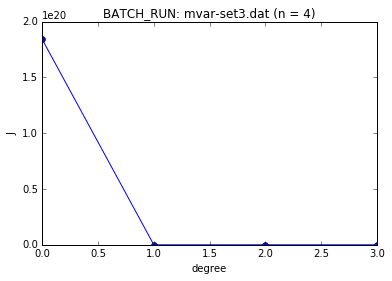

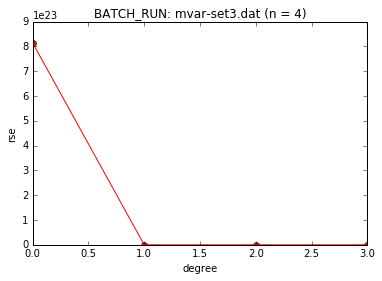

BATCH_RUN: mvar-set3.dat (n = 4)
J_min = 1155735048.8920178	n = 3
rse_min = 276741764515.1958008	n = 4
running time: [5.024862051010132, 5.538189172744751, 5.773802042007446, 6.486726999282837] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=11977970110781259776.0000000	train_rse_avg=56374357820074695118028800.0000000	
	test_J_avg=11478022695202238464.0000000	test_rse_avg=2824233468021988992745472.0000000
RUN: mvar-set4.dat (n = 1)
applied to all data (n = 1):
	J=3699133909679524864.0000000	rse=24040966806482345005154304.0000000
running time: 6.29724216461
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=115560665.4997387	train_rse_avg=770477458018945.1250000	
	test_J_avg=118660227.9782744	test_rse_avg=1424858659435599.5000000
RUN: mvar-set4.dat (n = 2)
applied to all data (n = 2):
	J=98616959.6569366	rse=242836198026626.7500000
running time: 6.24907183647
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=244291

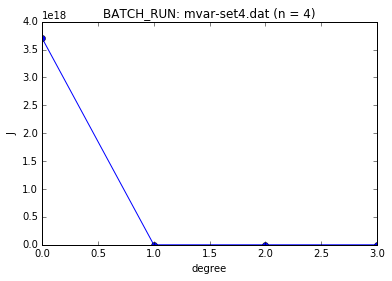

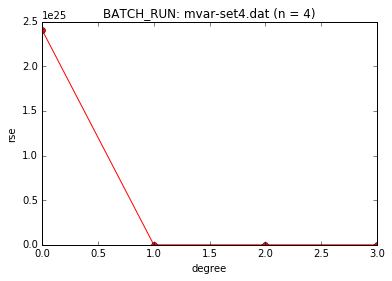

BATCH_RUN: mvar-set4.dat (n = 4)
J_min = 623630.2143973	n = 4
rse_min = 5156760256292.1748047	n = 4
running time: [6.297242164611816, 6.249071836471558, 6.1631810665130615, 6.520951986312866] 




In [30]:
# run all last two multivariates datasets
# fit dual linear regression model with degree from 1 to r, sigma=10.0, truncate data to 2.5%
# plot all results and graphs
batch_run(m_fnames[2:], 'explicit', 4, truncate=0.025, sigma=10.0, \
          r_verbose=True, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=5774927.1317820	train_rse_avg=1253557276.3427930	
	test_J_avg=5769510.8175091	test_rse_avg=1181508937.1457267
RUN: mvar-set3.dat (n = 1)
applied to all data (n = 1):
	J=6236736.2438531	rse=1415652947.9357581
running time: 28.7998290062
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=1549176982.2342811	train_rse_avg=980908872484.8951416	
	test_J_avg=1545924934.8674951	test_rse_avg=1000491253844.8474121
RUN: mvar-set3.dat (n = 2)
applied to all data (n = 2):
	J=1818832587.2162952	rse=1151708796127.1916504
running time: 29.7787470818
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=47287068158.0624466	train_rse_avg=22055999026538.1484375	
	test_J_avg=47134242021.0766220	test_rse_avg=21502096749512.8593750
RUN: mvar-set3.dat (n = 3)
applied to all data (n = 3):
	J=57894887518.9523392	rse=26951646411787.7656250
running time: 30.8933820724
CROSS_VALIDATION (K = 10) (n = 4

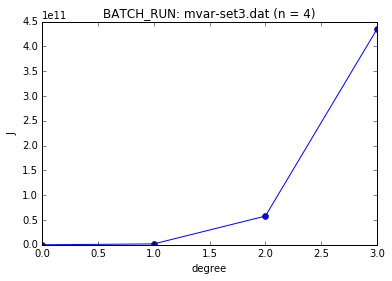

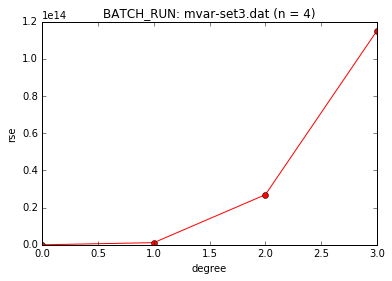

BATCH_RUN: mvar-set3.dat (n = 4)
J_min = 6236736.2438531	n = 1
rse_min = 1415652947.9357581	n = 1
running time: [28.79982900619507, 29.778747081756592, 30.89338207244873, 193.28428101539612] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=81.5188111	train_rse_avg=293788657.5852719	
	test_J_avg=80.7848015	test_rse_avg=148950563.2192642
RUN: mvar-set4.dat (n = 1)
applied to all data (n = 1):
	J=113.4556707	rse=352057434.0254115
running time: 31.2484619617
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=325.7297527	train_rse_avg=1524938148.7975826	
	test_J_avg=328.5601603	test_rse_avg=2956624221.7996564
RUN: mvar-set4.dat (n = 2)
applied to all data (n = 2):
	J=200.4387224	rse=1077291404.0104530
running time: 32.8137528896
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=19441.1788628	train_rse_avg=139298229049.9418640	
	test_J_avg=19174.7445318	test_rse_avg=232246073284.8623047
RUN: mvar-set4.dat (n = 3)
applied

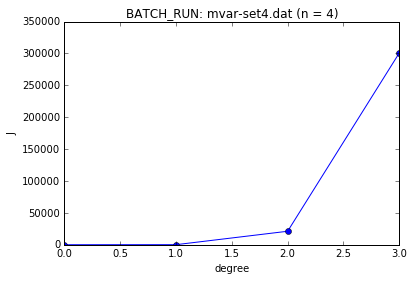

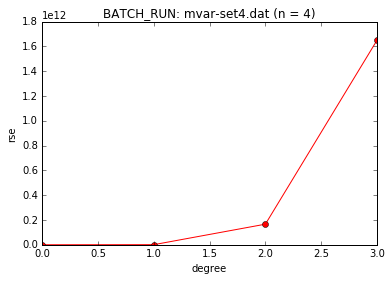

BATCH_RUN: mvar-set4.dat (n = 4)
J_min = 113.4556707	n = 1
rse_min = 352057434.0254115	n = 1
running time: [31.248461961746216, 32.81375288963318, 34.65014982223511, 199.02502417564392] 




In [26]:
# run all last two multivariates datasets
# fit dual linear regression model with degree from 1 to r, sigma=1.0, truncate data to 5%
# plot all results and graphs
batch_run(m_fnames[2:], 'explicit', 4, truncate=0.05, sigma=1.0, \
          r_verbose=True, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=3419227.2769392	train_rse_avg=1165105878.2297289	
	test_J_avg=3410063.5858285	test_rse_avg=1126282553.3525615
RUN: mvar-set3.dat (n = 1)
applied to all data (n = 1):
	J=3699982.6190080	rse=1271822039.5052419
running time: 4.7898709774
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=389658858.2553841	train_rse_avg=438777707039.8164062	
	test_J_avg=388260062.5496361	test_rse_avg=463238788698.1850586
RUN: mvar-set3.dat (n = 2)
applied to all data (n = 2):
	J=463084102.0068910	rse=523327379400.0723267
running time: 5.5111849308
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=11440688969.5796089	train_rse_avg=11334143148022.8007812	
	test_J_avg=11341693927.1426849	test_rse_avg=9992697975486.3457031
RUN: mvar-set3.dat (n = 3)
applied to all data (n = 3):
	J=14034155424.2671852	rse=13755099026228.3339844
running time: 5.86031413078
CROSS_VALIDATION (K = 10) (n = 4):
avera

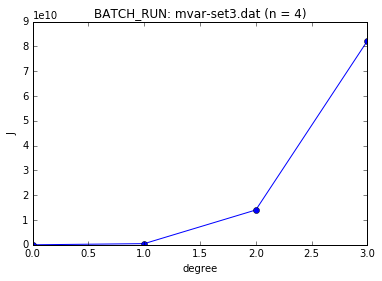

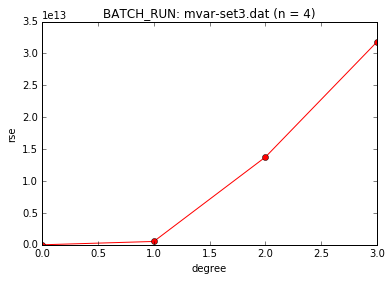

BATCH_RUN: mvar-set3.dat (n = 4)
J_min = 3699982.6190080	n = 1
rse_min = 1271822039.5052419	n = 1
running time: [4.789870977401733, 5.511184930801392, 5.860314130783081, 34.84700798988342] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=10.3205966	train_rse_avg=17524271.2258087	
	test_J_avg=10.4385000	test_rse_avg=51768499.8766569
RUN: mvar-set4.dat (n = 1)
applied to all data (n = 1):
	J=13.2487614	rse=17436265.1146318
running time: 6.17719912529
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=818.4081861	train_rse_avg=8714782703.0725441	
	test_J_avg=824.5921926	test_rse_avg=4778924611.7204618
RUN: mvar-set4.dat (n = 2)
applied to all data (n = 2):
	J=740.5926198	rse=7735658642.1991205
running time: 6.33204603195
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=9634.1679661	train_rse_avg=189481131614.7018738	
	test_J_avg=9562.7378442	test_rse_avg=239597391322.1867065
RUN: mvar-set4.dat (n = 3)
applied to all 

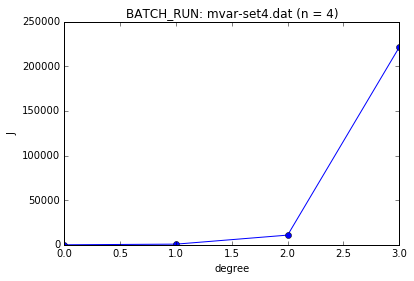

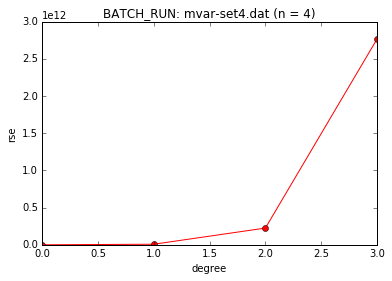

BATCH_RUN: mvar-set4.dat (n = 4)
J_min = 13.2487614	n = 1
rse_min = 17436265.1146318	n = 1
running time: [6.177199125289917, 6.332046031951904, 6.6379618644714355, 38.54115700721741] 




In [25]:
# run all last two multivariates datasets
# fit dual linear regression model with degree from 1 to r, sigma=1.0, truncate data to 2.5%
# plot all results and graphs
batch_run(m_fnames[2:], 'explicit', 4, truncate=0.025, sigma=1.0, \
          r_verbose=True, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=50501314.0779794	train_rse_avg=10529931811.6606922	
	test_J_avg=50248300.3030806	test_rse_avg=10028242898.6526451
RUN: mvar-set3.dat (n = 1)
applied to all data (n = 1):
	J=59153796.6920777	rse=12491358538.5781269
running time: 5.51678109169
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=603672899.8029904	train_rse_avg=707711509214.2183838	
	test_J_avg=600906996.9771279	test_rse_avg=704249150844.7498779
RUN: mvar-set3.dat (n = 2)
applied to all data (n = 2):
	J=742547369.6083194	rse=869840147700.9383545
running time: 6.18692398071
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=12032263634.7234688	train_rse_avg=11501268655529.9414062	
	test_J_avg=11955000060.1158257	test_rse_avg=12884987812280.4726562
RUN: mvar-set3.dat (n = 3)
applied to all data (n = 3):
	J=14838962606.7076321	rse=14359901744907.0039062
running time: 45.934112072
CROSS_VALIDATION (K = 10) (n = 4

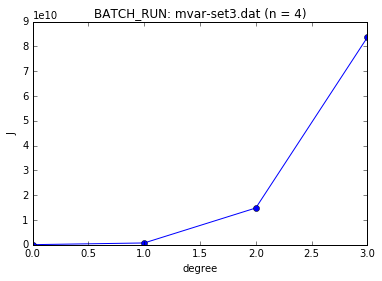

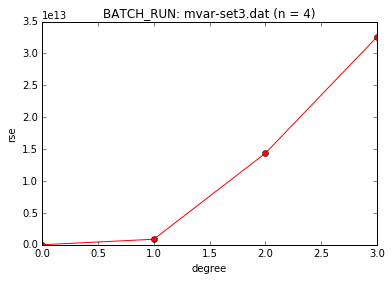

BATCH_RUN: mvar-set3.dat (n = 4)
J_min = 59153796.6920777	n = 1
rse_min = 12491358538.5781269	n = 1
running time: [5.5167810916900635, 6.186923980712891, 45.93411207199097, 25.95249891281128] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=112.8037662	train_rse_avg=1027741428.5107672	
	test_J_avg=112.6116471	test_rse_avg=1250158652.9760442
RUN: mvar-set4.dat (n = 1)
applied to all data (n = 1):
	J=124.5781665	rse=1136500174.1815579
running time: 6.25826883316
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=7989.1324803	train_rse_avg=76321838903.1535950	
	test_J_avg=7992.0566997	test_rse_avg=92346739162.6373291
RUN: mvar-set4.dat (n = 2)
applied to all data (n = 2):
	J=9615.8354033	rse=94026064163.5254211
running time: 5.99806308746
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=15075.5380441	train_rse_avg=289730022786.0270386	
	test_J_avg=15133.3225216	test_rse_avg=311674230394.0886841
RUN: mvar-set4.dat (n 

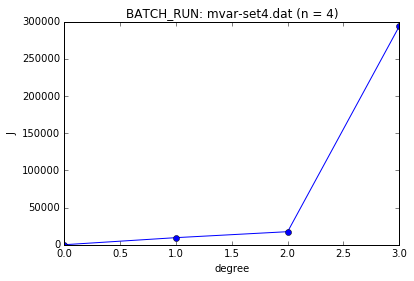

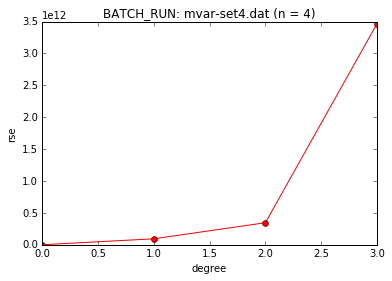

BATCH_RUN: mvar-set4.dat (n = 4)
J_min = 124.5781665	n = 1
rse_min = 1136500174.1815579	n = 1
running time: [6.2582688331604, 5.998063087463379, 46.897762060165405, 24.414037942886353] 




In [22]:
# run all last two multivariates datasets
# fit dual linear regression model with degree from 1 to r, sigma=0.5, truncate data to 2.5%
# plot all results and graphs
batch_run(m_fnames[2:], 'explicit', 4, truncate=0.025, sigma=0.5, \
          r_verbose=True, bpl_verbose=True)

CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=89777605.9602005	train_rse_avg=14784991127.3975525	
	test_J_avg=89434602.1548829	test_rse_avg=12440261275.0401955
RUN: mvar-set3.dat (n = 1)
applied to all data (n = 1):
	J=110777294.1343732	rse=17905027595.7566948
running time: 94.5055799484
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=617013087.4206527	train_rse_avg=720012739709.6556396	
	test_J_avg=614695071.1159790	test_rse_avg=771569501795.2561035
RUN: mvar-set3.dat (n = 2)
applied to all data (n = 2):
	J=760850263.2112875	rse=894335557346.7119141
running time: 5.42549920082
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=12047200760.7636261	train_rse_avg=11712583095895.5332031	
	test_J_avg=11963534972.2897530	test_rse_avg=10982935697365.4160156
RUN: mvar-set3.dat (n = 3)
applied to all data (n = 3):
	J=14858157233.9315968	rse=14363260830968.0996094
running time: 5.9528799057
CROSS_VALIDATION (K = 10) (n = 

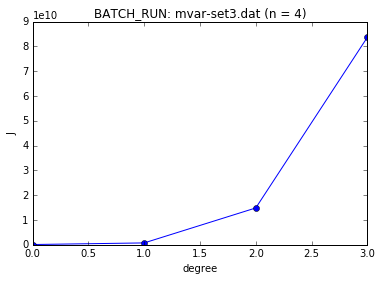

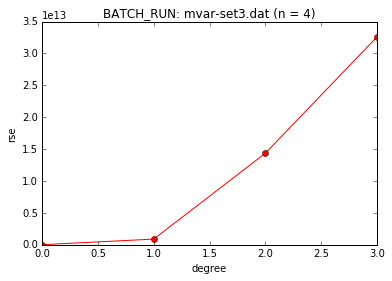

BATCH_RUN: mvar-set3.dat (n = 4)
J_min = 110777294.1343732	n = 1
rse_min = 17905027595.7566948	n = 1
running time: [94.5055799484253, 5.425499200820923, 5.952879905700684, 5.7450110912323] 


CROSS_VALIDATION (K = 10) (n = 1):
average results (n = 1):
	train_J_avg=289.5451136	train_rse_avg=3082156426.3256035	
	test_J_avg=289.4973430	test_rse_avg=3475079564.3158913
RUN: mvar-set4.dat (n = 1)
applied to all data (n = 1):
	J=353.3196770	rse=3806741521.6009274
running time: 92.652974844
CROSS_VALIDATION (K = 10) (n = 2):
average results (n = 2):
	train_J_avg=9179.6239878	train_rse_avg=88725151317.9536896	
	test_J_avg=9138.3836507	test_rse_avg=95073925127.2076111
RUN: mvar-set4.dat (n = 2)
applied to all data (n = 2):
	J=11083.9378402	rse=108037222226.2362366
running time: 5.3989109993
CROSS_VALIDATION (K = 10) (n = 3):
average results (n = 3):
	train_J_avg=15288.7802960	train_rse_avg=299295093382.3359375	
	test_J_avg=15092.5644801	test_rse_avg=223372275698.0680237
RUN: mvar-set4.dat (n = 3

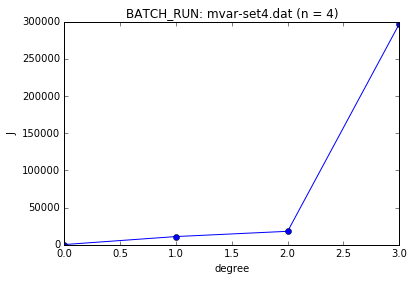

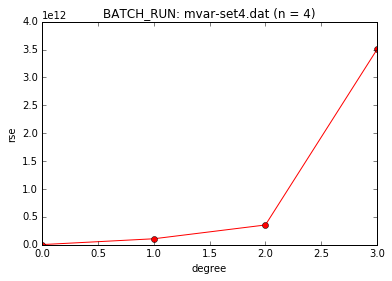

BATCH_RUN: mvar-set4.dat (n = 4)
J_min = 353.3196770	n = 1
rse_min = 3806741521.6009274	n = 1
running time: [92.65297484397888, 5.398910999298096, 5.712867021560669, 5.891973972320557] 




In [23]:
# run all last two multivariates datasets
# fit dual linear regression model with degree from 1 to r, sigma=0.1, truncate data to 2.5%
# plot all results and graphs
batch_run(m_fnames[2:], 'explicit', 4, truncate=0.025, sigma=0.1, \
          r_verbose=True, bpl_verbose=True)